# Test run WFlow and LISFLOOD together using GLOFRIM

In this notebook we test a one-way coupled run for wflow and lisflood. We particularly focus on whether the coupling locations are as expected as we need to ensure that coordinates are projected from one system (Wflow) to the other correctly. The experiment we setup is a simple one-way coupling where routed WFlow discharge (RiverRunoff) goes to the 1D channels in LISFLOOD-FP of Barotse.

In [1]:
%matplotlib inline
import cartopy
import cartopy.crs as ccrs
import cartopy.io.img_tiles as img_tiles
import rasterio.warp
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import sys, os
from datetime import datetime
import glofrim.glofrim_lib as glib

# import Glofrim itself
from glofrim import Glofrim


Setup the Glofrim object with the Glofrim .ini file

In [2]:
cbmi = Glofrim()
root_dir = '/home/hcwinsemius/git/barotse/experiments/'
config_fn = os.path.join(root_dir, 'glofrim_barotse_1way1Donly.ini')
cbmi.initialize_config(config_fn) #, env_fn=env_fn)


2020-04-28 08:26:56,808 - GLOFRIM - INFO - Reading ini file..
2020-04-28 08:26:57,235 - GLOFRIM.WFL - INFO - Read ini at /home/hcwinsemius/Barotse/zambezi_4km/wflow_sbm.ini
2020-04-28 08:26:57,245 - wflow_sbm.ini - wf_DynamicFramework - INFO - wflow_sbm.ini 2019.2.dev9+ge8b26553 Case: /home/hcwinsemius/Barotse/zambezi_4km Runid: run_default
2020-04-28 08:26:57,247 - wflow_sbm.ini - wf_DynamicFramework - INFO - Initialise framework version: 2019.2.dev9+ge8b26553
2020-04-28 08:26:57,250 - wflow_sbm.ini - wf_DynamicFramework - WARNING - Ini file made for wflow_sbm but found wflow.wflow_sbm in code.
2020-04-28 08:26:57,251 - GLOFRIM.WFL - INFO - Config initialized
2020-04-28 08:26:57,251 - GLOFRIM.WFL - INFO - Getting rgrid info based on wflow_subcatch.map
2020-04-28 08:26:57,477 - GLOFRIM.WFL - INFO - Getting drainage direction from wflow_ldd.map
2020-04-28 08:26:57,484 - GLOFRIM.LFP - INFO - Config initialized
2020-04-28 08:26:57,485 - GLOFRIM.LFP - INFO - Getting rgrid info based on ele

Set a start and end time interactively. Now just a couple of days for testing

In [3]:
t_start = datetime(2000,1,1)
t_end = datetime(2000,12,31)
cbmi.set_start_time(t_start)
cbmi.set_end_time(t_end)
try:
    t_start == cbmi.get_start_time()
    t_end == cbmi.get_end_time()
except:
    sys.exit('start or end time differ with set_var and get_var')
print('start time is: {:s}\nEnd time is {:s}'.format(t_start.strftime('%Y-%m-%d %H:%M:%S'), t_end.strftime('%Y-%m-%d %H:%M:%S')))


start time is: 2000-01-01 00:00:00
End time is 2000-12-31 00:00:00


Now initialize the Glofrim coupled model instance

In [4]:
cbmi.initialize_model()

2020-04-28 08:26:59,860 - GLOFRIM - INFO - set coupled grids for: SpatialCoupling object from WFL to LFP based on grid_us_2_1d_us method
2020-04-28 08:26:59,872 - wflow_sbm.ini - wf_DynamicFramework - INFO - Not reading time from ini file, assuming it is set by BMI or otherwise (calls = 3)
2020-04-28 08:26:59,879 - wflow_sbm.ini - wf_netcdfio - INFO - Reading input from netCDF file: /home/hcwinsemius/Barotse/zambezi_4km/inmaps/forcing-2000_2018.nc
2020-04-28 08:26:59,986 - wflow_sbm.ini - wf_netcdfio - WARNING - Variable IF not found in netcdf file: /home/hcwinsemius/Barotse/zambezi_4km/inmaps/forcing-2000_2018.nc
2020-04-28 08:26:59,987 - wflow_sbm.ini - wf_netcdfio - WARNING - Variable IF not found in netcdf file: /home/hcwinsemius/Barotse/zambezi_4km/inmaps/forcing-2000_2018.nc
2020-04-28 08:26:59,989 - wflow_sbm.ini - wf_netcdfio - INFO - Setting up netcdf output: /home/hcwinsemius/Barotse/zambezi_4km/run_default/outmaps.nc
2020-04-28 08:26:59,991 - wflow_sbm.ini - wf_netcdfio - IN

2020-04-28 08:27:00,111 - wflow_sbm.ini - wf_DynamicFramework - INFO - Creating map from table: /home/hcwinsemius/Barotse/zambezi_4km/intbl/TT.tbl
2020-04-28 08:27:00,114 - wflow_sbm.ini - wf_DynamicFramework - INFO - Creating map from table: /home/hcwinsemius/Barotse/zambezi_4km/intbl/TTM.tbl
2020-04-28 08:27:00,118 - wflow_sbm.ini - wf_DynamicFramework - INFO - Creating map from table: /home/hcwinsemius/Barotse/zambezi_4km/intbl/Cfmax.tbl
2020-04-28 08:27:00,124 - wflow_sbm.ini - wf_DynamicFramework - INFO - Creating map from table: /home/hcwinsemius/Barotse/zambezi_4km/intbl/WHC.tbl
2020-04-28 08:27:00,127 - wflow_sbm.ini - wf_DynamicFramework - WARNING - tbl file not found (/home/hcwinsemius/Barotse/zambezi_4km/intbl/w_soil.tbl) returning default value: 0.1125
2020-04-28 08:27:00,150 - wflow_sbm.ini - wflow_sbm - INFO - A total of 0 simple reservoirs and 1 lakes found.
2020-04-28 08:27:00,171 - wflow_sbm.ini - wf_DynamicFramework - WARNING - tbl file not found (/home/hcwinsemius/Ba

With the code below we print what dictionaries are currently inside the cbmi object

In [5]:
cbmi.__dict__

{'bmimodels': OrderedDict([('WFL', <glofrim.wfl_bmi.WFL at 0x7fe22510a128>),
              ('LFP', <glofrim.lfp_bmi.LFP at 0x7fe21ec0a630>)]),
 'exchanges': [('update', 'WFL'),
  ('exchange',
   {'from_mod': 'WFL',
    'from_vars': ['RiverRunoff', 86400.0],
    'from_unit': ['4', 'unknown'],
    'to_mod': 'LFP',
    'to_vars': ['SGCQin', 86400.0],
    'to_unit': ['m3/s', 'unknown'],
    'coupling': SpatialCoupling object from WFL to LFP based on grid_us_2_1d_us method,
    'name': 'WFL.RiverRunoff_to_LFP.SGCQin'}),
  ('update', 'LFP')],
 '_var_sep': '.',
 '_mult_sep': '*',
 '_ind_sep': '@',
 '_coord_sep': '|',
 '_loglevel': 20,
 'logger': <Logger GLOFRIM (INFO)>,
 'wb_logger': <Logger wb (INFO)>,
 'initialized': True,
 'obs': None,
 '_config_fn': '/home/hcwinsemius/git/barotse/experiments/glofrim_barotse_1way1Donly.ini',
 '_root': '/home/hcwinsemius/git/glofrim/tests/model_test_data',
 '_config': <configparser.ConfigParser at 0x7fe227b50438>,
 '_wb_header': ['time', 'WFL.RiverRunoff_to

Let's check the 'exchanges'. Here we should see the (3) different steps that are done to update the coupled model to the next time step. We see here the following:
1. 'update': 'WFL' - first, Wflow is updated by a single (day) time step.
2. 'exchange': {}  - second, RiverRunoff is exchanged from 'WFL' (Wflow) to 'SGCQin' (Subgrid Channel lateral Inflow) in LFP (LISFLOOD-FP) using a multiplier of 86400. This is to convert RiverRunoff in m3/s to a total amount of m3 in the full time step of one day (i.e. one day holds 86400 seconds). The method 'grid_us_2_1d_us' is used, which means exchanging upstream boundary conditions from a 2D grid domain (grid_us) to upstream boundary conditions in a 1D domain (1d_us).
3. 'update': 'LFP' - third, LISFLOOD is now run for a full day (WITH adaptive time stepping) using the upstream flow from WFlow imposed on upstream points in the domain.

After these steps, the next time step is ready to run, and will also go through all 3 steps.

Let's first investigate where we can find the grid information inside the different model instances. See cell below

In [6]:
# first let's see dictionaries inside WFL
print('WFlow model object:\n')
print(cbmi.bmimodels['WFL'].__dict__)
# the grid is what we're looking for, let's check what's inside
print('\nWFlow grid information:\n')
print(cbmi.bmimodels['WFL'].grid.__dict__)
# 
# the 1D grid is what we're looking for, let's check the 1D elements in there (see '_1d')
print('\nWFlow 1D grid information:\n')
print(cbmi.bmimodels['WFL'].grid._1d.__dict__)
# the 'nodes' hold the information of the 1D grid


WFlow model object:

{'_bmi': <wflow.wflow_bmi.wflowbmi_csdms object at 0x7fe22510a160>, 'logger': <Logger GLOFRIM.WFL (INFO)>, '_loglevel': 20, 'initialized': True, 'grid': <glofrim.grids.RGrid object at 0x7fe21eba9710>, '_config_fn': '/home/hcwinsemius/Barotse/zambezi_4km/wflow_sbm.ini', '_config': <configparser.ConfigParser object at 0x7fe21ebd06a0>, '_datefmt': '%Y-%m-%d %H:%M:%S', '_dt': datetime.timedelta(1), '_startTime': datetime.datetime(2000, 1, 1, 0, 0), '_endTime': datetime.datetime(2000, 12, 31, 0, 0), '_t': datetime.datetime(2000, 1, 1, 0, 0)}

WFlow grid information:

{'transform': Affine(0.03333333333333333, 0.0, 18.366666666666667,
       0.0, -0.03333333333333333, -10.866666666666667), 'height': 241, 'width': 239, 'shape': (241, 239), 'bounds': (18.366666666666667, -18.9, 26.333333333333336, -10.866666666666667), 'res': 0.03333333333333333, 'NtoS': True, 'crs': '+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs', 'mask': array([[False, False, False, ..., False, False, 

Check the 'coupling' object inside Glofrim, and plot coordinates from one grid to the other in one gerographical plot. The following steps are needed:
- extract the indices of the grids of the 'to' and the 'from' model
- convert these into geographical coordinates using the 'grid' object of the resp. models
- plot the grids in one graph, using the CRS of the grids of the 'to' (LFP) and 'from' (WFL) models.


In [7]:
# extract indices. WFL is 2d grid, LFP 1D
ind_WFL_2D = cbmi.exchanges[1][1]['coupling'].from_ind
ind_LFP_1D = cbmi.exchanges[1][1]['coupling'].to_ind

# convert to coordinates
ind_WFL_2D


array([29046, 29285, 23804, 25507, 25508, 25747, 25984, 22118, 22357,
       32186, 32424], dtype=int32)

Text(0, 0.5, 'y UTM 34S [m]')

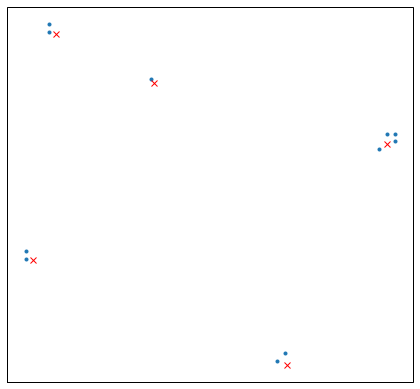

In [8]:
x_from, y_from = cbmi.bmimodels['WFL'].grid.xy(ind_WFL_2D)
x_to, y_to = cbmi.bmimodels['LFP'].grid.xy(ind_LFP_1D)
row_from, col_from = rasterio.transform.rowcol(cbmi.bmimodels['WFL'].grid.transform, x_from, y_from)
# read a streamorder map
s_order_fn = r'/home/hcwinsemius/Barotse/zambezi_4km/staticmaps/wflow_streamorder.map'
with rasterio.open(s_order_fn) as ds:
    s_order = ds.read(1)


f = plt.figure(figsize=(16, 10))
plt.subplot(121, projection=ccrs.PlateCarree())  # == WGS84 Latlon
plt.plot(x_from, y_from, '.')
plt.xlabel('lon [deg.]')
plt.ylabel('lat [deg.]')

# plt.subplot(122)
plt.plot(x_to, y_to, 'rx', transform=ccrs.UTM(34, southern_hemisphere=True))
plt.xlabel('x UTM 34S [m]')
plt.ylabel('y UTM 34S [m]')



Below, we mask any value in the DEM of lisflood model that lies upstream of the inflow points, to make sure we are not going to double count whilst updating 2D cells with local runoff

In [9]:
# # get wflow points into a pcraster map
# cp = cbmi.exchanges[1][1]['coupling']
# model_dir = r'/home/hcwinsemius/Barotse/zambezi_4km/staticmaps'
# with open(os.path.join(model_dir, 'barotse_inflow.col'), 'w') as f:
#     for n, (x, y) in enumerate(zip(x_from, y_from)):
#         f.write('{:f} {:f} {:d}\n'.format(x, y, n + 1))
# !col2map --clone "/home/hcwinsemius/Barotse/zambezi_4km/staticmaps/wflow_dem.map" -N "/home/hcwinsemius/Barotse/zambezi_4km/staticmaps/barotse_inflow.col" "/home/hcwinsemius/Barotse/zambezi_4km/staticmaps/barotse_inflow.map"
# import pcraster as pcr
# ldd = pcr.readmap(os.path.join(model_dir, 'wflow_ldd.map'))
# points = pcr.readmap(os.path.join(model_dir, 'barotse_inflow.map'))
# subcatch = pcr.subcatchment(ldd, points)
# subcatch_np = np.flipud(pcr.pcr2numpy(subcatch, -1))
# # plt.imshow(subcatch_np)
# mask = rasterio.warp.reproject(subcatch_np,
#                         destination=np.zeros((cp.to_bmi.grid.height,
#                                               cp.to_bmi.grid.width)),
#                         src_transform=cp.from_bmi.grid.transform,
#                         src_crs=cp.from_bmi.grid.crs,
#                         src_nodata=-1,
#                         dst_transform=cp.to_bmi.grid.transform,
#                         dst_crs=cp.to_bmi.grid.crs,
#                         dst_nodata=-1,
#                         resampling=rasterio.enums.Resampling.nearest)[0]


# with rasterio.open(r'/home/hcwinsemius/Barotse/Barotse_500m_MERIT/elevtn.asc') as dem:
#     data = dem.read(1)
#     data[mask>0] = -9999
#     profile = dem.profile
#     with rasterio.open(r'/home/hcwinsemius/Barotse/Barotse_500m_MERIT/elevtn_masked.asc', 'w', **profile) as dst:
#         dst.write(data.astype(rasterio.float32), 1)



Check the overlap between points in river stream network and the boundary conditions. It seems that there is double counting of flow as multiple entries in the stream network are found iun the same river

(70.0, 145.0)

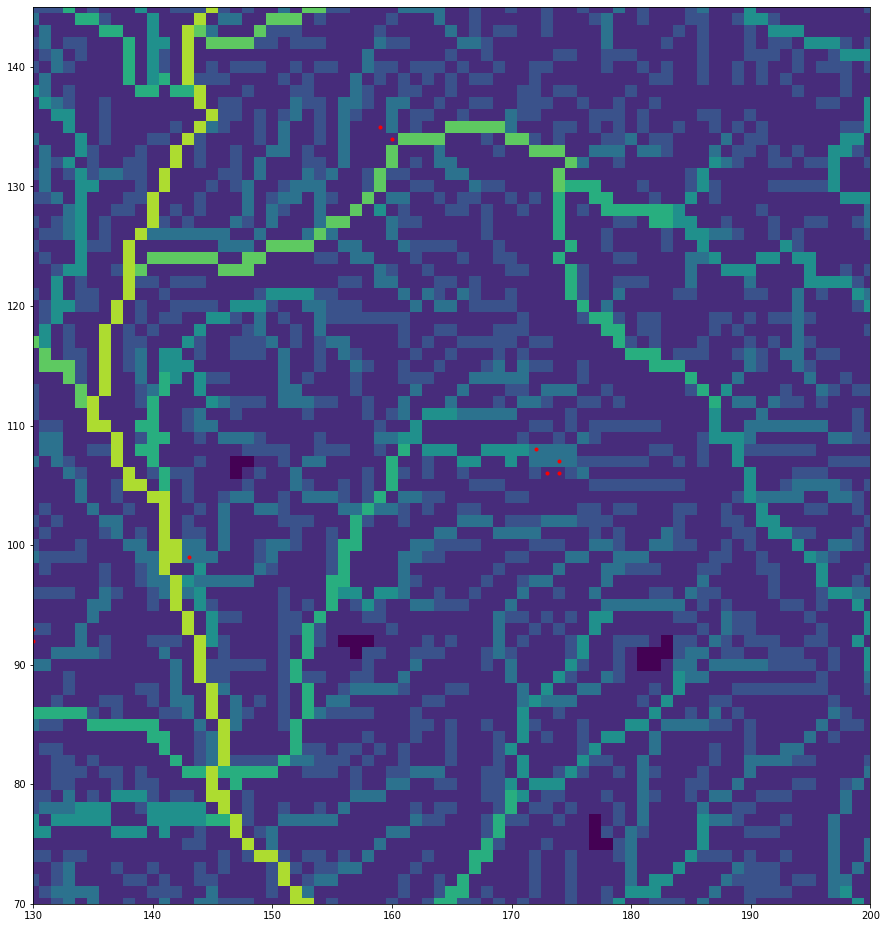

In [10]:
plt.figure(figsize=(15, 20))
# plt.imshow(np.flipud(s_order), vmin=0, origin='lower', interpolation='nearest')
plt.imshow(np.flipud(s_order), origin='lower', vmin=0, interpolation='nearest')
plt.plot(np.array(col_from), np.array(row_from), 'r.')
plt.xlim([130, 200])
plt.ylim([70, 145])

plot these in one geographical figure with a nice mapbox background to check if projections give a match

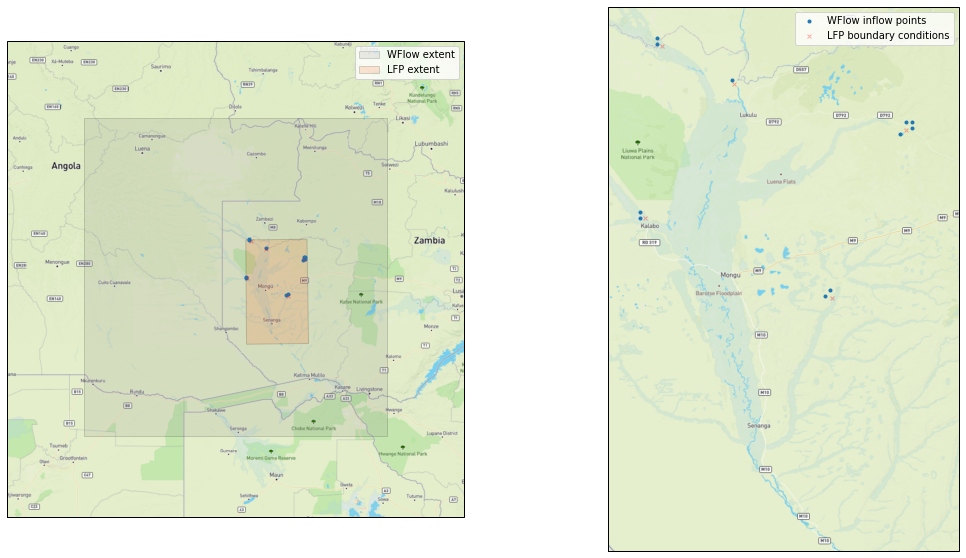

In [11]:
token = 'pk.eyJ1IjoiaGN3aW5zZW1pdXMiLCJhIjoiY2l2MHd3aDN4MDA0OTJ6dDU2Y2F6MWk0dCJ9.mLH0b46r4cHNdb1w9-dLcQ'
outdoor = img_tiles.MapboxStyleTiles(token, 'hcwinsemius', 'ck4ohy7u59mfg1cmi0z2twtll')
f = plt.figure(figsize=(18, 10))

# WFlow
xmin, ymin, xmax, ymax = cbmi.bmimodels['WFL'].grid.bounds
extent_wflow = (xmin-2, xmax+2, ymin-2, ymax+2)
rect_wflow = patches.Rectangle((xmin,ymin),xmax-xmin,ymax-ymin,linewidth=1,edgecolor='k',facecolor='gray', alpha=0.15, transform=ccrs.PlateCarree(), label='WFlow extent')

# LFP
xmin, ymin, xmax, ymax = cbmi.bmimodels['LFP'].grid.bounds
extent_lfp = (xmin-2e4, xmax+2e4, ymin-2e4, ymax+2e4)
rect_lfp = patches.Rectangle((xmin,ymin),xmax-xmin,ymax-ymin,linewidth=1,edgecolor='k',facecolor='#FF5500', alpha=0.15, transform=ccrs.UTM(34, southern_hemisphere=True), label='LFP extent')

# start a geographical axis
ax1 = plt.subplot(121, projection=outdoor.crs)
# limit spatial extent to WFlow model lat-lon bounds (note that ccrs.PlateCarree is the same as WGS84 lat lon)
ax1.set_extent(extent_wflow, crs=ccrs.PlateCarree())
ax1.add_image(outdoor, 7, interpolation='bilinear')
ax1.plot(x_from, y_from, '.', transform=ccrs.PlateCarree())
ax1.plot(x_to, y_to, 'rx', markersize=4., alpha=0.3, transform=ccrs.UTM(34, southern_hemisphere=True))
# Add the patch to the Axes
ax1.add_patch(rect_wflow)
ax1.add_patch(rect_lfp)
ax1.legend()

# start a second geographical axis, zoomed to LFP domain
ax2 = plt.subplot(122, projection=outdoor.crs)
# limit spatial extent to WFlow model lat-lon bounds (note that ccrs.PlateCarree is the same as WGS84 lat lon)
ax2.set_extent(extent_lfp, crs=ccrs.UTM(34, southern_hemisphere=True))
ax2.add_image(outdoor, 9, interpolation='bilinear')
ax2.plot(x_from, y_from, '.', transform=ccrs.PlateCarree(), label='WFlow inflow points')
ax2.plot(x_to, y_to, 'rx', markersize=4., alpha=0.3, transform=ccrs.UTM(34, southern_hemisphere=True), label='LFP boundary conditions')
ax2.legend()


Run the model for a number of time steps and store results

In [11]:
H = []
Q = []
Qx = []
Qy = []
t = []
try:
    i = 0
    while i < 365:
        print(cbmi.get_current_time())
        cbmi.update()
        t.append(cbmi.get_current_time())
        H.append(cbmi.get_value('LFP.H'))
        Q.append(cbmi.get_value('LFP.SGCQin'))
        qx = cbmi.get_value('LFP.Qx')
        qy = cbmi.get_value('LFP.Qy')
        qx, qy = convert_Qs(qx, qy)
        Qx.append(qx)
        Qy.append(qy)
        # q_sim_PCR = cbmi.get_value_at_indices('PCR.discharge', obs_ind_PCR)
        # q_sim_LFP = cbmi.get_value_at_indices('LFP.H', obs_ind_LFP)
        # print(q_sim_PCR, q_sim_LFP)
        i += 1
except Exception as e:
    print(e)
    sys.exit('something is going wrong in updating - please check!')

LFP_outputs = ['SGCQin', 'H']
LFP_attrs = [{'units': 'm3 s-1',
              'short_name': 'river_flow',
              'long_name': 'River Flow'
             },
             {'units': 'm',
              'short_name': 'water_depth',
              'long_name': 'Water Depth'
             }
            ]





2000-01-01 00:00:00


/home/hcwinsemius/miniconda3/envs/barotse/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1372: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/home/hcwinsemius/miniconda3/envs/barotse/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1372: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
2020-04-28 08:29:19,618 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:29:19,660 - GLOFRIM.WFL - INFO - updated model to datetime 2000-01-02 00:00
2020-04-28 08:29:19,660 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:29:22,798 - GLOFRIM.LFP - INFO - updated model to datetime 2000-01-02 00:00:00 in 1440 iterations


2000-01-02 00:00:00


2020-04-28 08:29:23,362 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:29:23,370 - GLOFRIM.WFL - INFO - updated model to datetime 2000-01-03 00:00
2020-04-28 08:29:23,370 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:29:25,924 - GLOFRIM.LFP - INFO - updated model to datetime 2000-01-03 00:00:00 in 1440 iterations


2000-01-03 00:00:00


2020-04-28 08:29:26,506 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:29:26,512 - GLOFRIM.WFL - INFO - updated model to datetime 2000-01-04 00:00
2020-04-28 08:29:26,513 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:29:29,084 - GLOFRIM.LFP - INFO - updated model to datetime 2000-01-04 00:00:00 in 1440 iterations


2000-01-04 00:00:00


2020-04-28 08:29:29,658 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:29:29,665 - GLOFRIM.WFL - INFO - updated model to datetime 2000-01-05 00:00
2020-04-28 08:29:29,665 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:29:32,198 - GLOFRIM.LFP - INFO - updated model to datetime 2000-01-05 00:00:00 in 1440 iterations


2000-01-05 00:00:00


2020-04-28 08:29:32,788 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:29:32,796 - GLOFRIM.WFL - INFO - updated model to datetime 2000-01-06 00:00
2020-04-28 08:29:32,796 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:29:35,511 - GLOFRIM.LFP - INFO - updated model to datetime 2000-01-06 00:00:14 in 1572 iterations
2020-04-28 08:29:35,512 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-06 00:00:00; LFP: 2000-01-06 00:00:14.467414
2020-04-28 08:29:35,512 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-06 00:00:00; LFP: 2000-01-06 00:00:14.467414
2020-04-28 08:29:35,516 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-06 00:00:00; LFP: 2000-01-06 00:00:14.467414


2000-01-06 00:00:00


2020-04-28 08:29:36,112 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:29:36,119 - GLOFRIM.WFL - INFO - updated model to datetime 2000-01-07 00:00
2020-04-28 08:29:36,120 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:29:39,480 - GLOFRIM.LFP - INFO - updated model to datetime 2000-01-07 00:00:21 in 2047 iterations
2020-04-28 08:29:39,480 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-07 00:00:00; LFP: 2000-01-07 00:00:21.683666
2020-04-28 08:29:39,481 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-07 00:00:00; LFP: 2000-01-07 00:00:21.683666
2020-04-28 08:29:39,484 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-07 00:00:00; LFP: 2000-01-07 00:00:21.683666


2000-01-07 00:00:00


2020-04-28 08:29:40,110 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:29:40,118 - GLOFRIM.WFL - INFO - updated model to datetime 2000-01-08 00:00
2020-04-28 08:29:40,118 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:29:44,172 - GLOFRIM.LFP - INFO - updated model to datetime 2000-01-08 00:00:13 in 2439 iterations
2020-04-28 08:29:44,173 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-08 00:00:00; LFP: 2000-01-08 00:00:13.526803
2020-04-28 08:29:44,173 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-08 00:00:00; LFP: 2000-01-08 00:00:13.526803
2020-04-28 08:29:44,176 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-08 00:00:00; LFP: 2000-01-08 00:00:13.526803


2000-01-08 00:00:00


2020-04-28 08:29:44,818 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:29:44,825 - GLOFRIM.WFL - INFO - updated model to datetime 2000-01-09 00:00
2020-04-28 08:29:44,825 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:29:48,966 - GLOFRIM.LFP - INFO - updated model to datetime 2000-01-09 00:00:08 in 2573 iterations
2020-04-28 08:29:48,967 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-09 00:00:00; LFP: 2000-01-09 00:00:08.991890
2020-04-28 08:29:48,967 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-09 00:00:00; LFP: 2000-01-09 00:00:08.991890
2020-04-28 08:29:48,971 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-09 00:00:00; LFP: 2000-01-09 00:00:08.991890


2000-01-09 00:00:00


2020-04-28 08:29:49,596 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:29:49,605 - GLOFRIM.WFL - INFO - updated model to datetime 2000-01-10 00:00
2020-04-28 08:29:49,606 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:29:54,018 - GLOFRIM.LFP - INFO - updated model to datetime 2000-01-10 00:00:09 in 2587 iterations
2020-04-28 08:29:54,019 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-10 00:00:00; LFP: 2000-01-10 00:00:09.839071
2020-04-28 08:29:54,019 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-10 00:00:00; LFP: 2000-01-10 00:00:09.839071
2020-04-28 08:29:54,022 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-10 00:00:00; LFP: 2000-01-10 00:00:09.839071


2000-01-10 00:00:00


2020-04-28 08:29:54,675 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:29:54,683 - GLOFRIM.WFL - INFO - updated model to datetime 2000-01-11 00:00
2020-04-28 08:29:54,683 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:29:58,935 - GLOFRIM.LFP - INFO - updated model to datetime 2000-01-11 00:00:26 in 2593 iterations
2020-04-28 08:29:58,936 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-11 00:00:00; LFP: 2000-01-11 00:00:26.445895
2020-04-28 08:29:58,936 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-11 00:00:00; LFP: 2000-01-11 00:00:26.445895
2020-04-28 08:29:58,938 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-11 00:00:00; LFP: 2000-01-11 00:00:26.445895


2000-01-11 00:00:00


2020-04-28 08:29:59,605 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:29:59,612 - GLOFRIM.WFL - INFO - updated model to datetime 2000-01-12 00:00
2020-04-28 08:29:59,613 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:30:03,965 - GLOFRIM.LFP - INFO - updated model to datetime 2000-01-12 00:00:01 in 2595 iterations
2020-04-28 08:30:03,966 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-12 00:00:00; LFP: 2000-01-12 00:00:01.005773
2020-04-28 08:30:03,966 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-12 00:00:00; LFP: 2000-01-12 00:00:01.005773
2020-04-28 08:30:03,969 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-12 00:00:00; LFP: 2000-01-12 00:00:01.005773


2000-01-12 00:00:00


2020-04-28 08:30:04,583 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:30:04,591 - GLOFRIM.WFL - INFO - updated model to datetime 2000-01-13 00:00
2020-04-28 08:30:04,591 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:30:08,843 - GLOFRIM.LFP - INFO - updated model to datetime 2000-01-13 00:00:12 in 2599 iterations
2020-04-28 08:30:08,844 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-13 00:00:00; LFP: 2000-01-13 00:00:12.906840
2020-04-28 08:30:08,845 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-13 00:00:00; LFP: 2000-01-13 00:00:12.906840
2020-04-28 08:30:08,847 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-13 00:00:00; LFP: 2000-01-13 00:00:12.906840


2000-01-13 00:00:00


2020-04-28 08:30:09,456 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:30:09,463 - GLOFRIM.WFL - INFO - updated model to datetime 2000-01-14 00:00
2020-04-28 08:30:09,464 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:30:14,031 - GLOFRIM.LFP - INFO - updated model to datetime 2000-01-14 00:00:16 in 2602 iterations
2020-04-28 08:30:14,032 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-14 00:00:00; LFP: 2000-01-14 00:00:16.942322
2020-04-28 08:30:14,033 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-14 00:00:00; LFP: 2000-01-14 00:00:16.942322
2020-04-28 08:30:14,036 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-14 00:00:00; LFP: 2000-01-14 00:00:16.942322


2000-01-14 00:00:00


2020-04-28 08:30:14,665 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:30:14,672 - GLOFRIM.WFL - INFO - updated model to datetime 2000-01-15 00:00
2020-04-28 08:30:14,673 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:30:19,482 - GLOFRIM.LFP - INFO - updated model to datetime 2000-01-15 00:00:06 in 2604 iterations
2020-04-28 08:30:19,482 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-15 00:00:00; LFP: 2000-01-15 00:00:06.551849
2020-04-28 08:30:19,483 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-15 00:00:00; LFP: 2000-01-15 00:00:06.551849
2020-04-28 08:30:19,485 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-15 00:00:00; LFP: 2000-01-15 00:00:06.551849


2000-01-15 00:00:00


2020-04-28 08:30:20,117 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:30:20,124 - GLOFRIM.WFL - INFO - updated model to datetime 2000-01-16 00:00
2020-04-28 08:30:20,125 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:30:24,846 - GLOFRIM.LFP - INFO - updated model to datetime 2000-01-16 00:00:30 in 2607 iterations
2020-04-28 08:30:24,846 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-16 00:00:00; LFP: 2000-01-16 00:00:30.668716
2020-04-28 08:30:24,847 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-16 00:00:00; LFP: 2000-01-16 00:00:30.668716
2020-04-28 08:30:24,849 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-16 00:00:00; LFP: 2000-01-16 00:00:30.668716


2000-01-16 00:00:00


2020-04-28 08:30:25,493 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:30:25,501 - GLOFRIM.WFL - INFO - updated model to datetime 2000-01-17 00:00
2020-04-28 08:30:25,501 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:30:29,861 - GLOFRIM.LFP - INFO - updated model to datetime 2000-01-17 00:00:23 in 2607 iterations
2020-04-28 08:30:29,862 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-17 00:00:00; LFP: 2000-01-17 00:00:23.616409
2020-04-28 08:30:29,862 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-17 00:00:00; LFP: 2000-01-17 00:00:23.616409
2020-04-28 08:30:29,865 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-17 00:00:00; LFP: 2000-01-17 00:00:23.616409


2000-01-17 00:00:00


2020-04-28 08:30:30,537 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:30:30,547 - GLOFRIM.WFL - INFO - updated model to datetime 2000-01-18 00:00
2020-04-28 08:30:30,548 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:30:34,889 - GLOFRIM.LFP - INFO - updated model to datetime 2000-01-18 00:00:01 in 2607 iterations
2020-04-28 08:30:34,889 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-18 00:00:00; LFP: 2000-01-18 00:00:01.753346
2020-04-28 08:30:34,890 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-18 00:00:00; LFP: 2000-01-18 00:00:01.753346
2020-04-28 08:30:34,892 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-18 00:00:00; LFP: 2000-01-18 00:00:01.753346


2000-01-18 00:00:00


2020-04-28 08:30:35,497 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:30:35,504 - GLOFRIM.WFL - INFO - updated model to datetime 2000-01-19 00:00
2020-04-28 08:30:35,505 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:30:39,885 - GLOFRIM.LFP - INFO - updated model to datetime 2000-01-19 00:00:13 in 2609 iterations
2020-04-28 08:30:39,886 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-19 00:00:00; LFP: 2000-01-19 00:00:13.754056
2020-04-28 08:30:39,887 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-19 00:00:00; LFP: 2000-01-19 00:00:13.754056
2020-04-28 08:30:39,890 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-19 00:00:00; LFP: 2000-01-19 00:00:13.754056


2000-01-19 00:00:00


2020-04-28 08:30:40,564 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:30:40,577 - GLOFRIM.WFL - INFO - updated model to datetime 2000-01-20 00:00
2020-04-28 08:30:40,577 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:30:45,127 - GLOFRIM.LFP - INFO - updated model to datetime 2000-01-20 00:00:07 in 2610 iterations
2020-04-28 08:30:45,128 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-20 00:00:00; LFP: 2000-01-20 00:00:07.258174
2020-04-28 08:30:45,128 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-20 00:00:00; LFP: 2000-01-20 00:00:07.258174
2020-04-28 08:30:45,131 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-20 00:00:00; LFP: 2000-01-20 00:00:07.258174


2000-01-20 00:00:00


2020-04-28 08:30:45,866 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:30:45,873 - GLOFRIM.WFL - INFO - updated model to datetime 2000-01-21 00:00
2020-04-28 08:30:45,874 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:30:50,436 - GLOFRIM.LFP - INFO - updated model to datetime 2000-01-21 00:00:12 in 2615 iterations
2020-04-28 08:30:50,437 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-21 00:00:00; LFP: 2000-01-21 00:00:12.893048
2020-04-28 08:30:50,437 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-21 00:00:00; LFP: 2000-01-21 00:00:12.893048
2020-04-28 08:30:50,439 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-21 00:00:00; LFP: 2000-01-21 00:00:12.893048


2000-01-21 00:00:00


2020-04-28 08:30:51,144 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:30:51,152 - GLOFRIM.WFL - INFO - updated model to datetime 2000-01-22 00:00
2020-04-28 08:30:51,152 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:30:56,130 - GLOFRIM.LFP - INFO - updated model to datetime 2000-01-22 00:00:20 in 2624 iterations
2020-04-28 08:30:56,130 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-22 00:00:00; LFP: 2000-01-22 00:00:20.395283
2020-04-28 08:30:56,131 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-22 00:00:00; LFP: 2000-01-22 00:00:20.395283
2020-04-28 08:30:56,134 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-22 00:00:00; LFP: 2000-01-22 00:00:20.395283


2000-01-22 00:00:00


2020-04-28 08:30:56,862 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:30:56,869 - GLOFRIM.WFL - INFO - updated model to datetime 2000-01-23 00:00
2020-04-28 08:30:56,870 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:31:01,789 - GLOFRIM.LFP - INFO - updated model to datetime 2000-01-23 00:00:00 in 2638 iterations
2020-04-28 08:31:01,790 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-23 00:00:00; LFP: 2000-01-23 00:00:00.189893
2020-04-28 08:31:01,790 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-23 00:00:00; LFP: 2000-01-23 00:00:00.189893
2020-04-28 08:31:01,793 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-23 00:00:00; LFP: 2000-01-23 00:00:00.189893


2000-01-23 00:00:00


2020-04-28 08:31:02,540 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:31:02,547 - GLOFRIM.WFL - INFO - updated model to datetime 2000-01-24 00:00
2020-04-28 08:31:02,548 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:31:08,333 - GLOFRIM.LFP - INFO - updated model to datetime 2000-01-24 00:00:01 in 2655 iterations
2020-04-28 08:31:08,334 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-24 00:00:00; LFP: 2000-01-24 00:00:01.993642
2020-04-28 08:31:08,334 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-24 00:00:00; LFP: 2000-01-24 00:00:01.993642
2020-04-28 08:31:08,337 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-24 00:00:00; LFP: 2000-01-24 00:00:01.993642


2000-01-24 00:00:00


2020-04-28 08:31:09,078 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:31:09,086 - GLOFRIM.WFL - INFO - updated model to datetime 2000-01-25 00:00
2020-04-28 08:31:09,086 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:31:13,878 - GLOFRIM.LFP - INFO - updated model to datetime 2000-01-25 00:00:28 in 2678 iterations
2020-04-28 08:31:13,879 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-25 00:00:00; LFP: 2000-01-25 00:00:28.297193
2020-04-28 08:31:13,879 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-25 00:00:00; LFP: 2000-01-25 00:00:28.297193
2020-04-28 08:31:13,882 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-25 00:00:00; LFP: 2000-01-25 00:00:28.297193


2000-01-25 00:00:00


2020-04-28 08:31:14,631 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:31:14,639 - GLOFRIM.WFL - INFO - updated model to datetime 2000-01-26 00:00
2020-04-28 08:31:14,639 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:31:19,529 - GLOFRIM.LFP - INFO - updated model to datetime 2000-01-26 00:00:09 in 2693 iterations
2020-04-28 08:31:19,530 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-26 00:00:00; LFP: 2000-01-26 00:00:09.537353
2020-04-28 08:31:19,530 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-26 00:00:00; LFP: 2000-01-26 00:00:09.537353
2020-04-28 08:31:19,533 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-26 00:00:00; LFP: 2000-01-26 00:00:09.537353


2000-01-26 00:00:00


2020-04-28 08:31:20,303 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:31:20,311 - GLOFRIM.WFL - INFO - updated model to datetime 2000-01-27 00:00
2020-04-28 08:31:20,311 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:31:25,379 - GLOFRIM.LFP - INFO - updated model to datetime 2000-01-27 00:00:26 in 2709 iterations
2020-04-28 08:31:25,379 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-27 00:00:00; LFP: 2000-01-27 00:00:26.491747
2020-04-28 08:31:25,379 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-27 00:00:00; LFP: 2000-01-27 00:00:26.491747
2020-04-28 08:31:25,382 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-27 00:00:00; LFP: 2000-01-27 00:00:26.491747


2000-01-27 00:00:00


2020-04-28 08:31:26,215 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:31:26,223 - GLOFRIM.WFL - INFO - updated model to datetime 2000-01-28 00:00
2020-04-28 08:31:26,223 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:31:31,328 - GLOFRIM.LFP - INFO - updated model to datetime 2000-01-28 00:00:14 in 2728 iterations
2020-04-28 08:31:31,328 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-28 00:00:00; LFP: 2000-01-28 00:00:14.474943
2020-04-28 08:31:31,329 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-28 00:00:00; LFP: 2000-01-28 00:00:14.474943
2020-04-28 08:31:31,331 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-28 00:00:00; LFP: 2000-01-28 00:00:14.474943


2000-01-28 00:00:00


2020-04-28 08:31:32,188 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:31:32,195 - GLOFRIM.WFL - INFO - updated model to datetime 2000-01-29 00:00
2020-04-28 08:31:32,195 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:31:37,482 - GLOFRIM.LFP - INFO - updated model to datetime 2000-01-29 00:00:12 in 2753 iterations
2020-04-28 08:31:37,483 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-29 00:00:00; LFP: 2000-01-29 00:00:12.849713
2020-04-28 08:31:37,483 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-29 00:00:00; LFP: 2000-01-29 00:00:12.849713
2020-04-28 08:31:37,487 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-29 00:00:00; LFP: 2000-01-29 00:00:12.849713


2000-01-29 00:00:00


2020-04-28 08:31:38,463 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:31:38,470 - GLOFRIM.WFL - INFO - updated model to datetime 2000-01-30 00:00
2020-04-28 08:31:38,471 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:31:43,887 - GLOFRIM.LFP - INFO - updated model to datetime 2000-01-30 00:00:17 in 2771 iterations
2020-04-28 08:31:43,888 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-30 00:00:00; LFP: 2000-01-30 00:00:17.268593
2020-04-28 08:31:43,888 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-30 00:00:00; LFP: 2000-01-30 00:00:17.268593
2020-04-28 08:31:43,890 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-30 00:00:00; LFP: 2000-01-30 00:00:17.268593


2000-01-30 00:00:00


2020-04-28 08:31:44,891 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:31:44,898 - GLOFRIM.WFL - INFO - updated model to datetime 2000-01-31 00:00
2020-04-28 08:31:44,899 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:31:50,543 - GLOFRIM.LFP - INFO - updated model to datetime 2000-01-31 00:00:11 in 2779 iterations
2020-04-28 08:31:50,544 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-31 00:00:00; LFP: 2000-01-31 00:00:11.958332
2020-04-28 08:31:50,544 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-31 00:00:00; LFP: 2000-01-31 00:00:11.958332
2020-04-28 08:31:50,546 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-01-31 00:00:00; LFP: 2000-01-31 00:00:11.958332


2000-01-31 00:00:00


2020-04-28 08:31:51,408 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:31:51,415 - GLOFRIM.WFL - INFO - updated model to datetime 2000-02-01 00:00
2020-04-28 08:31:51,415 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:31:57,173 - GLOFRIM.LFP - INFO - updated model to datetime 2000-02-01 00:00:19 in 2779 iterations
2020-04-28 08:31:57,173 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-01 00:00:00; LFP: 2000-02-01 00:00:19.100415
2020-04-28 08:31:57,173 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-01 00:00:00; LFP: 2000-02-01 00:00:19.100415
2020-04-28 08:31:57,176 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-01 00:00:00; LFP: 2000-02-01 00:00:19.100415


2000-02-01 00:00:00


2020-04-28 08:31:57,974 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:31:57,980 - GLOFRIM.WFL - INFO - updated model to datetime 2000-02-02 00:00
2020-04-28 08:31:57,981 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:32:04,109 - GLOFRIM.LFP - INFO - updated model to datetime 2000-02-02 00:00:24 in 2773 iterations
2020-04-28 08:32:04,110 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-02 00:00:00; LFP: 2000-02-02 00:00:24.931771
2020-04-28 08:32:04,110 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-02 00:00:00; LFP: 2000-02-02 00:00:24.931771
2020-04-28 08:32:04,113 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-02 00:00:00; LFP: 2000-02-02 00:00:24.931771


2000-02-02 00:00:00


2020-04-28 08:32:04,927 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:32:04,934 - GLOFRIM.WFL - INFO - updated model to datetime 2000-02-03 00:00
2020-04-28 08:32:04,934 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:32:11,493 - GLOFRIM.LFP - INFO - updated model to datetime 2000-02-03 00:00:30 in 2766 iterations
2020-04-28 08:32:11,494 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-03 00:00:00; LFP: 2000-02-03 00:00:30.480968
2020-04-28 08:32:11,494 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-03 00:00:00; LFP: 2000-02-03 00:00:30.480968
2020-04-28 08:32:11,497 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-03 00:00:00; LFP: 2000-02-03 00:00:30.480968


2000-02-03 00:00:00


2020-04-28 08:32:12,367 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:32:12,374 - GLOFRIM.WFL - INFO - updated model to datetime 2000-02-04 00:00
2020-04-28 08:32:12,375 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:32:19,453 - GLOFRIM.LFP - INFO - updated model to datetime 2000-02-04 00:00:07 in 2757 iterations
2020-04-28 08:32:19,453 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-04 00:00:00; LFP: 2000-02-04 00:00:07.288715
2020-04-28 08:32:19,454 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-04 00:00:00; LFP: 2000-02-04 00:00:07.288715
2020-04-28 08:32:19,456 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-04 00:00:00; LFP: 2000-02-04 00:00:07.288715


2000-02-04 00:00:00


2020-04-28 08:32:20,386 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:32:20,394 - GLOFRIM.WFL - INFO - updated model to datetime 2000-02-05 00:00
2020-04-28 08:32:20,394 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:32:27,630 - GLOFRIM.LFP - INFO - updated model to datetime 2000-02-05 00:00:21 in 2750 iterations
2020-04-28 08:32:27,631 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-05 00:00:00; LFP: 2000-02-05 00:00:21.386297
2020-04-28 08:32:27,631 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-05 00:00:00; LFP: 2000-02-05 00:00:21.386297
2020-04-28 08:32:27,634 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-05 00:00:00; LFP: 2000-02-05 00:00:21.386297


2000-02-05 00:00:00


2020-04-28 08:32:28,494 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:32:28,501 - GLOFRIM.WFL - INFO - updated model to datetime 2000-02-06 00:00
2020-04-28 08:32:28,501 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:32:35,879 - GLOFRIM.LFP - INFO - updated model to datetime 2000-02-06 00:00:08 in 2750 iterations
2020-04-28 08:32:35,880 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-06 00:00:00; LFP: 2000-02-06 00:00:08.090957
2020-04-28 08:32:35,881 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-06 00:00:00; LFP: 2000-02-06 00:00:08.090957
2020-04-28 08:32:35,883 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-06 00:00:00; LFP: 2000-02-06 00:00:08.090957


2000-02-06 00:00:00


2020-04-28 08:32:36,777 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:32:36,784 - GLOFRIM.WFL - INFO - updated model to datetime 2000-02-07 00:00
2020-04-28 08:32:36,784 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:32:44,306 - GLOFRIM.LFP - INFO - updated model to datetime 2000-02-07 00:00:13 in 2750 iterations
2020-04-28 08:32:44,307 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-07 00:00:00; LFP: 2000-02-07 00:00:13.917313
2020-04-28 08:32:44,307 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-07 00:00:00; LFP: 2000-02-07 00:00:13.917313
2020-04-28 08:32:44,310 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-07 00:00:00; LFP: 2000-02-07 00:00:13.917313


2000-02-07 00:00:00


2020-04-28 08:32:45,289 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:32:45,295 - GLOFRIM.WFL - INFO - updated model to datetime 2000-02-08 00:00
2020-04-28 08:32:45,296 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:32:53,191 - GLOFRIM.LFP - INFO - updated model to datetime 2000-02-08 00:00:15 in 2751 iterations
2020-04-28 08:32:53,191 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-08 00:00:00; LFP: 2000-02-08 00:00:15.076794
2020-04-28 08:32:53,192 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-08 00:00:00; LFP: 2000-02-08 00:00:15.076794
2020-04-28 08:32:53,194 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-08 00:00:00; LFP: 2000-02-08 00:00:15.076794


2000-02-08 00:00:00


2020-04-28 08:32:54,114 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:32:54,121 - GLOFRIM.WFL - INFO - updated model to datetime 2000-02-09 00:00
2020-04-28 08:32:54,121 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:33:02,092 - GLOFRIM.LFP - INFO - updated model to datetime 2000-02-09 00:00:00 in 2766 iterations
2020-04-28 08:33:02,092 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-09 00:00:00; LFP: 2000-02-09 00:00:00.907523
2020-04-28 08:33:02,093 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-09 00:00:00; LFP: 2000-02-09 00:00:00.907523
2020-04-28 08:33:02,095 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-09 00:00:00; LFP: 2000-02-09 00:00:00.907523


2000-02-09 00:00:00


2020-04-28 08:33:03,012 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:33:03,019 - GLOFRIM.WFL - INFO - updated model to datetime 2000-02-10 00:00
2020-04-28 08:33:03,020 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:33:11,360 - GLOFRIM.LFP - INFO - updated model to datetime 2000-02-10 00:00:12 in 2777 iterations
2020-04-28 08:33:11,361 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-10 00:00:00; LFP: 2000-02-10 00:00:12.934013
2020-04-28 08:33:11,361 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-10 00:00:00; LFP: 2000-02-10 00:00:12.934013
2020-04-28 08:33:11,363 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-10 00:00:00; LFP: 2000-02-10 00:00:12.934013


2000-02-10 00:00:00


2020-04-28 08:33:12,349 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:33:12,361 - GLOFRIM.WFL - INFO - updated model to datetime 2000-02-11 00:00
2020-04-28 08:33:12,362 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:33:21,171 - GLOFRIM.LFP - INFO - updated model to datetime 2000-02-11 00:00:27 in 2781 iterations
2020-04-28 08:33:21,172 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-11 00:00:00; LFP: 2000-02-11 00:00:27.630386
2020-04-28 08:33:21,172 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-11 00:00:00; LFP: 2000-02-11 00:00:27.630386
2020-04-28 08:33:21,176 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-11 00:00:00; LFP: 2000-02-11 00:00:27.630386


2000-02-11 00:00:00


2020-04-28 08:33:22,128 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:33:22,135 - GLOFRIM.WFL - INFO - updated model to datetime 2000-02-12 00:00
2020-04-28 08:33:22,135 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:33:30,517 - GLOFRIM.LFP - INFO - updated model to datetime 2000-02-12 00:00:17 in 2779 iterations
2020-04-28 08:33:30,518 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-12 00:00:00; LFP: 2000-02-12 00:00:17.392774
2020-04-28 08:33:30,518 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-12 00:00:00; LFP: 2000-02-12 00:00:17.392774
2020-04-28 08:33:30,521 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-12 00:00:00; LFP: 2000-02-12 00:00:17.392774


2000-02-12 00:00:00


2020-04-28 08:33:31,469 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:33:31,477 - GLOFRIM.WFL - INFO - updated model to datetime 2000-02-13 00:00
2020-04-28 08:33:31,477 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:33:40,021 - GLOFRIM.LFP - INFO - updated model to datetime 2000-02-13 00:00:06 in 2775 iterations
2020-04-28 08:33:40,022 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-13 00:00:00; LFP: 2000-02-13 00:00:06.525806
2020-04-28 08:33:40,022 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-13 00:00:00; LFP: 2000-02-13 00:00:06.525806
2020-04-28 08:33:40,024 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-13 00:00:00; LFP: 2000-02-13 00:00:06.525806


2000-02-13 00:00:00


2020-04-28 08:33:41,031 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:33:41,038 - GLOFRIM.WFL - INFO - updated model to datetime 2000-02-14 00:00
2020-04-28 08:33:41,038 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:33:49,547 - GLOFRIM.LFP - INFO - updated model to datetime 2000-02-14 00:00:10 in 2770 iterations
2020-04-28 08:33:49,547 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-14 00:00:00; LFP: 2000-02-14 00:00:10.640951
2020-04-28 08:33:49,548 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-14 00:00:00; LFP: 2000-02-14 00:00:10.640951
2020-04-28 08:33:49,550 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-14 00:00:00; LFP: 2000-02-14 00:00:10.640951


2000-02-14 00:00:00


2020-04-28 08:33:50,553 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:33:50,564 - GLOFRIM.WFL - INFO - updated model to datetime 2000-02-15 00:00
2020-04-28 08:33:50,565 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:33:58,897 - GLOFRIM.LFP - INFO - updated model to datetime 2000-02-15 00:00:23 in 2772 iterations
2020-04-28 08:33:58,897 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-15 00:00:00; LFP: 2000-02-15 00:00:23.284064
2020-04-28 08:33:58,898 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-15 00:00:00; LFP: 2000-02-15 00:00:23.284064
2020-04-28 08:33:58,900 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-15 00:00:00; LFP: 2000-02-15 00:00:23.284064


2000-02-15 00:00:00


2020-04-28 08:33:59,948 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:33:59,955 - GLOFRIM.WFL - INFO - updated model to datetime 2000-02-16 00:00
2020-04-28 08:33:59,955 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:34:08,158 - GLOFRIM.LFP - INFO - updated model to datetime 2000-02-16 00:00:09 in 2831 iterations
2020-04-28 08:34:08,159 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-16 00:00:00; LFP: 2000-02-16 00:00:09.286226
2020-04-28 08:34:08,159 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-16 00:00:00; LFP: 2000-02-16 00:00:09.286226
2020-04-28 08:34:08,161 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-16 00:00:00; LFP: 2000-02-16 00:00:09.286226


2000-02-16 00:00:00


2020-04-28 08:34:09,209 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:34:09,216 - GLOFRIM.WFL - INFO - updated model to datetime 2000-02-17 00:00
2020-04-28 08:34:09,216 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:34:18,044 - GLOFRIM.LFP - INFO - updated model to datetime 2000-02-17 00:00:10 in 3041 iterations
2020-04-28 08:34:18,045 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-17 00:00:00; LFP: 2000-02-17 00:00:10.867022
2020-04-28 08:34:18,045 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-17 00:00:00; LFP: 2000-02-17 00:00:10.867022
2020-04-28 08:34:18,048 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-17 00:00:00; LFP: 2000-02-17 00:00:10.867022


2000-02-17 00:00:00


2020-04-28 08:34:19,163 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:34:19,170 - GLOFRIM.WFL - INFO - updated model to datetime 2000-02-18 00:00
2020-04-28 08:34:19,171 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:34:30,277 - GLOFRIM.LFP - INFO - updated model to datetime 2000-02-18 00:00:25 in 3166 iterations
2020-04-28 08:34:30,278 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-18 00:00:00; LFP: 2000-02-18 00:00:25.478045
2020-04-28 08:34:30,279 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-18 00:00:00; LFP: 2000-02-18 00:00:25.478045
2020-04-28 08:34:30,281 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-18 00:00:00; LFP: 2000-02-18 00:00:25.478045


2000-02-18 00:00:00


2020-04-28 08:34:31,430 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:34:31,438 - GLOFRIM.WFL - INFO - updated model to datetime 2000-02-19 00:00
2020-04-28 08:34:31,438 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:34:40,964 - GLOFRIM.LFP - INFO - updated model to datetime 2000-02-19 00:00:07 in 3242 iterations
2020-04-28 08:34:40,965 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-19 00:00:00; LFP: 2000-02-19 00:00:07.252631
2020-04-28 08:34:40,965 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-19 00:00:00; LFP: 2000-02-19 00:00:07.252631
2020-04-28 08:34:40,968 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-19 00:00:00; LFP: 2000-02-19 00:00:07.252631


2000-02-19 00:00:00


2020-04-28 08:34:42,140 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:34:42,147 - GLOFRIM.WFL - INFO - updated model to datetime 2000-02-20 00:00
2020-04-28 08:34:42,148 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:34:51,878 - GLOFRIM.LFP - INFO - updated model to datetime 2000-02-20 00:00:11 in 3295 iterations
2020-04-28 08:34:51,879 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-20 00:00:00; LFP: 2000-02-20 00:00:11.051323
2020-04-28 08:34:51,879 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-20 00:00:00; LFP: 2000-02-20 00:00:11.051323
2020-04-28 08:34:51,881 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-20 00:00:00; LFP: 2000-02-20 00:00:11.051323


2000-02-20 00:00:00


2020-04-28 08:34:53,049 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:34:53,057 - GLOFRIM.WFL - INFO - updated model to datetime 2000-02-21 00:00
2020-04-28 08:34:53,058 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:35:02,935 - GLOFRIM.LFP - INFO - updated model to datetime 2000-02-21 00:00:18 in 3330 iterations
2020-04-28 08:35:02,936 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-21 00:00:00; LFP: 2000-02-21 00:00:18.885799
2020-04-28 08:35:02,936 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-21 00:00:00; LFP: 2000-02-21 00:00:18.885799
2020-04-28 08:35:02,939 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-21 00:00:00; LFP: 2000-02-21 00:00:18.885799


2000-02-21 00:00:00


2020-04-28 08:35:04,165 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:35:04,173 - GLOFRIM.WFL - INFO - updated model to datetime 2000-02-22 00:00
2020-04-28 08:35:04,173 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:35:15,460 - GLOFRIM.LFP - INFO - updated model to datetime 2000-02-22 00:00:05 in 3352 iterations
2020-04-28 08:35:15,460 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-22 00:00:00; LFP: 2000-02-22 00:00:05.076255
2020-04-28 08:35:15,461 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-22 00:00:00; LFP: 2000-02-22 00:00:05.076255
2020-04-28 08:35:15,464 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-22 00:00:00; LFP: 2000-02-22 00:00:05.076255


2000-02-22 00:00:00


2020-04-28 08:35:16,711 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:35:16,719 - GLOFRIM.WFL - INFO - updated model to datetime 2000-02-23 00:00
2020-04-28 08:35:16,719 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:35:27,092 - GLOFRIM.LFP - INFO - updated model to datetime 2000-02-23 00:00:11 in 3368 iterations
2020-04-28 08:35:27,092 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-23 00:00:00; LFP: 2000-02-23 00:00:11.431136
2020-04-28 08:35:27,093 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-23 00:00:00; LFP: 2000-02-23 00:00:11.431136
2020-04-28 08:35:27,096 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-23 00:00:00; LFP: 2000-02-23 00:00:11.431136


2000-02-23 00:00:00


2020-04-28 08:35:28,269 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:35:28,277 - GLOFRIM.WFL - INFO - updated model to datetime 2000-02-24 00:00
2020-04-28 08:35:28,278 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:35:38,643 - GLOFRIM.LFP - INFO - updated model to datetime 2000-02-24 00:00:07 in 3380 iterations
2020-04-28 08:35:38,643 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-24 00:00:00; LFP: 2000-02-24 00:00:07.706504
2020-04-28 08:35:38,643 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-24 00:00:00; LFP: 2000-02-24 00:00:07.706504
2020-04-28 08:35:38,646 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-24 00:00:00; LFP: 2000-02-24 00:00:07.706504


2000-02-24 00:00:00


2020-04-28 08:35:40,002 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:35:40,010 - GLOFRIM.WFL - INFO - updated model to datetime 2000-02-25 00:00
2020-04-28 08:35:40,011 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:35:50,340 - GLOFRIM.LFP - INFO - updated model to datetime 2000-02-25 00:00:04 in 3392 iterations
2020-04-28 08:35:50,340 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-25 00:00:00; LFP: 2000-02-25 00:00:04.447589
2020-04-28 08:35:50,341 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-25 00:00:00; LFP: 2000-02-25 00:00:04.447589
2020-04-28 08:35:50,343 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-25 00:00:00; LFP: 2000-02-25 00:00:04.447589


2000-02-25 00:00:00


2020-04-28 08:35:51,736 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:35:51,744 - GLOFRIM.WFL - INFO - updated model to datetime 2000-02-26 00:00
2020-04-28 08:35:51,745 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:36:02,920 - GLOFRIM.LFP - INFO - updated model to datetime 2000-02-26 00:00:05 in 3406 iterations
2020-04-28 08:36:02,921 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-26 00:00:00; LFP: 2000-02-26 00:00:05.387087
2020-04-28 08:36:02,922 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-26 00:00:00; LFP: 2000-02-26 00:00:05.387087
2020-04-28 08:36:02,925 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-26 00:00:00; LFP: 2000-02-26 00:00:05.387087


2000-02-26 00:00:00


2020-04-28 08:36:04,140 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:36:04,147 - GLOFRIM.WFL - INFO - updated model to datetime 2000-02-27 00:00
2020-04-28 08:36:04,147 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:36:15,474 - GLOFRIM.LFP - INFO - updated model to datetime 2000-02-27 00:00:14 in 3426 iterations
2020-04-28 08:36:15,475 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-27 00:00:00; LFP: 2000-02-27 00:00:14.703768
2020-04-28 08:36:15,476 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-27 00:00:00; LFP: 2000-02-27 00:00:14.703768
2020-04-28 08:36:15,480 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-27 00:00:00; LFP: 2000-02-27 00:00:14.703768


2000-02-27 00:00:00


2020-04-28 08:36:16,945 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:36:16,953 - GLOFRIM.WFL - INFO - updated model to datetime 2000-02-28 00:00
2020-04-28 08:36:16,953 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:36:29,649 - GLOFRIM.LFP - INFO - updated model to datetime 2000-02-28 00:00:12 in 3456 iterations
2020-04-28 08:36:29,650 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-28 00:00:00; LFP: 2000-02-28 00:00:12.048524
2020-04-28 08:36:29,651 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-28 00:00:00; LFP: 2000-02-28 00:00:12.048524
2020-04-28 08:36:29,654 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-28 00:00:00; LFP: 2000-02-28 00:00:12.048524


2000-02-28 00:00:00


2020-04-28 08:36:30,961 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:36:30,969 - GLOFRIM.WFL - INFO - updated model to datetime 2000-02-29 00:00
2020-04-28 08:36:30,969 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:36:41,896 - GLOFRIM.LFP - INFO - updated model to datetime 2000-02-29 00:00:07 in 3498 iterations
2020-04-28 08:36:41,896 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-29 00:00:00; LFP: 2000-02-29 00:00:07.702293
2020-04-28 08:36:41,896 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-29 00:00:00; LFP: 2000-02-29 00:00:07.702293
2020-04-28 08:36:41,899 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-02-29 00:00:00; LFP: 2000-02-29 00:00:07.702293


2000-02-29 00:00:00


2020-04-28 08:36:43,251 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:36:43,259 - GLOFRIM.WFL - INFO - updated model to datetime 2000-03-01 00:00
2020-04-28 08:36:43,260 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:36:54,632 - GLOFRIM.LFP - INFO - updated model to datetime 2000-03-01 00:00:00 in 3546 iterations
2020-04-28 08:36:54,633 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-01 00:00:00; LFP: 2000-03-01 00:00:00.849660
2020-04-28 08:36:54,633 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-01 00:00:00; LFP: 2000-03-01 00:00:00.849660
2020-04-28 08:36:54,635 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-01 00:00:00; LFP: 2000-03-01 00:00:00.849660


2000-03-01 00:00:00


2020-04-28 08:36:55,945 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:36:55,953 - GLOFRIM.WFL - INFO - updated model to datetime 2000-03-02 00:00
2020-04-28 08:36:55,953 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:37:10,537 - GLOFRIM.LFP - INFO - updated model to datetime 2000-03-02 00:00:02 in 3592 iterations
2020-04-28 08:37:10,538 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-02 00:00:00; LFP: 2000-03-02 00:00:02.527050
2020-04-28 08:37:10,539 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-02 00:00:00; LFP: 2000-03-02 00:00:02.527050
2020-04-28 08:37:10,541 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-02 00:00:00; LFP: 2000-03-02 00:00:02.527050


2000-03-02 00:00:00


2020-04-28 08:37:11,834 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:37:11,842 - GLOFRIM.WFL - INFO - updated model to datetime 2000-03-03 00:00
2020-04-28 08:37:11,842 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:37:24,025 - GLOFRIM.LFP - INFO - updated model to datetime 2000-03-03 00:00:07 in 3630 iterations
2020-04-28 08:37:24,025 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-03 00:00:00; LFP: 2000-03-03 00:00:07.746477
2020-04-28 08:37:24,026 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-03 00:00:00; LFP: 2000-03-03 00:00:07.746477
2020-04-28 08:37:24,028 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-03 00:00:00; LFP: 2000-03-03 00:00:07.746477


2000-03-03 00:00:00


2020-04-28 08:37:25,201 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:37:25,208 - GLOFRIM.WFL - INFO - updated model to datetime 2000-03-04 00:00
2020-04-28 08:37:25,209 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:37:36,553 - GLOFRIM.LFP - INFO - updated model to datetime 2000-03-04 00:00:00 in 3657 iterations
2020-04-28 08:37:36,554 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-04 00:00:00; LFP: 2000-03-04 00:00:00.154281
2020-04-28 08:37:36,554 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-04 00:00:00; LFP: 2000-03-04 00:00:00.154281
2020-04-28 08:37:36,558 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-04 00:00:00; LFP: 2000-03-04 00:00:00.154281


2000-03-04 00:00:00


2020-04-28 08:37:37,853 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:37:37,860 - GLOFRIM.WFL - INFO - updated model to datetime 2000-03-05 00:00
2020-04-28 08:37:37,860 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:37:49,155 - GLOFRIM.LFP - INFO - updated model to datetime 2000-03-05 00:00:18 in 3675 iterations
2020-04-28 08:37:49,156 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-05 00:00:00; LFP: 2000-03-05 00:00:18.326263
2020-04-28 08:37:49,156 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-05 00:00:00; LFP: 2000-03-05 00:00:18.326263
2020-04-28 08:37:49,160 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-05 00:00:00; LFP: 2000-03-05 00:00:18.326263


2000-03-05 00:00:00


2020-04-28 08:37:50,483 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:37:50,490 - GLOFRIM.WFL - INFO - updated model to datetime 2000-03-06 00:00
2020-04-28 08:37:50,490 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:38:01,893 - GLOFRIM.LFP - INFO - updated model to datetime 2000-03-06 00:00:02 in 3681 iterations
2020-04-28 08:38:01,893 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-06 00:00:00; LFP: 2000-03-06 00:00:02.042907
2020-04-28 08:38:01,894 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-06 00:00:00; LFP: 2000-03-06 00:00:02.042907
2020-04-28 08:38:01,897 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-06 00:00:00; LFP: 2000-03-06 00:00:02.042907


2000-03-06 00:00:00


2020-04-28 08:38:03,191 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:38:03,197 - GLOFRIM.WFL - INFO - updated model to datetime 2000-03-07 00:00
2020-04-28 08:38:03,198 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:38:14,570 - GLOFRIM.LFP - INFO - updated model to datetime 2000-03-07 00:00:11 in 3682 iterations
2020-04-28 08:38:14,571 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-07 00:00:00; LFP: 2000-03-07 00:00:11.535910
2020-04-28 08:38:14,571 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-07 00:00:00; LFP: 2000-03-07 00:00:11.535910
2020-04-28 08:38:14,575 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-07 00:00:00; LFP: 2000-03-07 00:00:11.535910


2000-03-07 00:00:00


2020-04-28 08:38:15,849 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:38:15,856 - GLOFRIM.WFL - INFO - updated model to datetime 2000-03-08 00:00
2020-04-28 08:38:15,857 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:38:27,193 - GLOFRIM.LFP - INFO - updated model to datetime 2000-03-08 00:00:00 in 3676 iterations
2020-04-28 08:38:27,193 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-08 00:00:00; LFP: 2000-03-08 00:00:00.817125
2020-04-28 08:38:27,194 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-08 00:00:00; LFP: 2000-03-08 00:00:00.817125
2020-04-28 08:38:27,197 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-08 00:00:00; LFP: 2000-03-08 00:00:00.817125


2000-03-08 00:00:00


2020-04-28 08:38:28,501 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:38:28,513 - GLOFRIM.WFL - INFO - updated model to datetime 2000-03-09 00:00
2020-04-28 08:38:28,514 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:38:39,859 - GLOFRIM.LFP - INFO - updated model to datetime 2000-03-09 00:00:01 in 3669 iterations
2020-04-28 08:38:39,859 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-09 00:00:00; LFP: 2000-03-09 00:00:01.371607
2020-04-28 08:38:39,859 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-09 00:00:00; LFP: 2000-03-09 00:00:01.371607
2020-04-28 08:38:39,862 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-09 00:00:00; LFP: 2000-03-09 00:00:01.371607


2000-03-09 00:00:00


2020-04-28 08:38:41,197 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:38:41,204 - GLOFRIM.WFL - INFO - updated model to datetime 2000-03-10 00:00
2020-04-28 08:38:41,204 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:38:52,845 - GLOFRIM.LFP - INFO - updated model to datetime 2000-03-10 00:00:01 in 3662 iterations
2020-04-28 08:38:52,846 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-10 00:00:00; LFP: 2000-03-10 00:00:01.083513
2020-04-28 08:38:52,846 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-10 00:00:00; LFP: 2000-03-10 00:00:01.083513
2020-04-28 08:38:52,849 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-10 00:00:00; LFP: 2000-03-10 00:00:01.083513


2000-03-10 00:00:00


2020-04-28 08:38:54,206 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:38:54,213 - GLOFRIM.WFL - INFO - updated model to datetime 2000-03-11 00:00
2020-04-28 08:38:54,214 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:39:05,472 - GLOFRIM.LFP - INFO - updated model to datetime 2000-03-11 00:00:11 in 3659 iterations
2020-04-28 08:39:05,473 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-11 00:00:00; LFP: 2000-03-11 00:00:11.453729
2020-04-28 08:39:05,473 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-11 00:00:00; LFP: 2000-03-11 00:00:11.453729
2020-04-28 08:39:05,486 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-11 00:00:00; LFP: 2000-03-11 00:00:11.453729


2000-03-11 00:00:00


2020-04-28 08:39:06,795 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:39:06,802 - GLOFRIM.WFL - INFO - updated model to datetime 2000-03-12 00:00
2020-04-28 08:39:06,802 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:39:18,071 - GLOFRIM.LFP - INFO - updated model to datetime 2000-03-12 00:00:22 in 3662 iterations
2020-04-28 08:39:18,072 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-12 00:00:00; LFP: 2000-03-12 00:00:22.311839
2020-04-28 08:39:18,072 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-12 00:00:00; LFP: 2000-03-12 00:00:22.311839
2020-04-28 08:39:18,075 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-12 00:00:00; LFP: 2000-03-12 00:00:22.311839


2000-03-12 00:00:00


2020-04-28 08:39:19,400 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:39:19,407 - GLOFRIM.WFL - INFO - updated model to datetime 2000-03-13 00:00
2020-04-28 08:39:19,408 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:39:30,645 - GLOFRIM.LFP - INFO - updated model to datetime 2000-03-13 00:00:11 in 3673 iterations
2020-04-28 08:39:30,646 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-13 00:00:00; LFP: 2000-03-13 00:00:11.534908
2020-04-28 08:39:30,647 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-13 00:00:00; LFP: 2000-03-13 00:00:11.534908
2020-04-28 08:39:30,649 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-13 00:00:00; LFP: 2000-03-13 00:00:11.534908


2000-03-13 00:00:00


2020-04-28 08:39:32,011 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:39:32,017 - GLOFRIM.WFL - INFO - updated model to datetime 2000-03-14 00:00
2020-04-28 08:39:32,018 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:39:44,177 - GLOFRIM.LFP - INFO - updated model to datetime 2000-03-14 00:00:21 in 3695 iterations
2020-04-28 08:39:44,178 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-14 00:00:00; LFP: 2000-03-14 00:00:21.475676
2020-04-28 08:39:44,178 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-14 00:00:00; LFP: 2000-03-14 00:00:21.475676
2020-04-28 08:39:44,181 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-14 00:00:00; LFP: 2000-03-14 00:00:21.475676


2000-03-14 00:00:00


2020-04-28 08:39:45,653 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:39:45,660 - GLOFRIM.WFL - INFO - updated model to datetime 2000-03-15 00:00
2020-04-28 08:39:45,661 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:39:56,955 - GLOFRIM.LFP - INFO - updated model to datetime 2000-03-15 00:00:11 in 3721 iterations
2020-04-28 08:39:56,955 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-15 00:00:00; LFP: 2000-03-15 00:00:11.724282
2020-04-28 08:39:56,956 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-15 00:00:00; LFP: 2000-03-15 00:00:11.724282
2020-04-28 08:39:56,960 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-15 00:00:00; LFP: 2000-03-15 00:00:11.724282


2000-03-15 00:00:00


2020-04-28 08:39:58,446 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:39:58,453 - GLOFRIM.WFL - INFO - updated model to datetime 2000-03-16 00:00
2020-04-28 08:39:58,454 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:40:10,095 - GLOFRIM.LFP - INFO - updated model to datetime 2000-03-16 00:00:15 in 3749 iterations
2020-04-28 08:40:10,095 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-16 00:00:00; LFP: 2000-03-16 00:00:15.326906
2020-04-28 08:40:10,096 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-16 00:00:00; LFP: 2000-03-16 00:00:15.326906
2020-04-28 08:40:10,099 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-16 00:00:00; LFP: 2000-03-16 00:00:15.326906


2000-03-16 00:00:00


2020-04-28 08:40:11,480 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:40:11,487 - GLOFRIM.WFL - INFO - updated model to datetime 2000-03-17 00:00
2020-04-28 08:40:11,488 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:40:23,051 - GLOFRIM.LFP - INFO - updated model to datetime 2000-03-17 00:00:13 in 3773 iterations
2020-04-28 08:40:23,051 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-17 00:00:00; LFP: 2000-03-17 00:00:13.603432
2020-04-28 08:40:23,052 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-17 00:00:00; LFP: 2000-03-17 00:00:13.603432
2020-04-28 08:40:23,055 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-17 00:00:00; LFP: 2000-03-17 00:00:13.603432


2000-03-17 00:00:00


2020-04-28 08:40:24,291 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:40:24,298 - GLOFRIM.WFL - INFO - updated model to datetime 2000-03-18 00:00
2020-04-28 08:40:24,298 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:40:35,982 - GLOFRIM.LFP - INFO - updated model to datetime 2000-03-18 00:00:20 in 3793 iterations
2020-04-28 08:40:35,982 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-18 00:00:00; LFP: 2000-03-18 00:00:20.259795
2020-04-28 08:40:35,983 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-18 00:00:00; LFP: 2000-03-18 00:00:20.259795
2020-04-28 08:40:35,986 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-18 00:00:00; LFP: 2000-03-18 00:00:20.259795


2000-03-18 00:00:00


2020-04-28 08:40:37,310 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:40:37,317 - GLOFRIM.WFL - INFO - updated model to datetime 2000-03-19 00:00
2020-04-28 08:40:37,317 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:40:50,270 - GLOFRIM.LFP - INFO - updated model to datetime 2000-03-19 00:00:01 in 3807 iterations
2020-04-28 08:40:50,271 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-19 00:00:00; LFP: 2000-03-19 00:00:01.969123
2020-04-28 08:40:50,271 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-19 00:00:00; LFP: 2000-03-19 00:00:01.969123
2020-04-28 08:40:50,275 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-19 00:00:00; LFP: 2000-03-19 00:00:01.969123


2000-03-19 00:00:00


2020-04-28 08:40:51,700 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:40:51,707 - GLOFRIM.WFL - INFO - updated model to datetime 2000-03-20 00:00
2020-04-28 08:40:51,708 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:41:07,688 - GLOFRIM.LFP - INFO - updated model to datetime 2000-03-20 00:00:19 in 3819 iterations
2020-04-28 08:41:07,689 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-20 00:00:00; LFP: 2000-03-20 00:00:19.215411
2020-04-28 08:41:07,689 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-20 00:00:00; LFP: 2000-03-20 00:00:19.215411
2020-04-28 08:41:07,692 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-20 00:00:00; LFP: 2000-03-20 00:00:19.215411


2000-03-20 00:00:00


2020-04-28 08:41:09,119 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:41:09,127 - GLOFRIM.WFL - INFO - updated model to datetime 2000-03-21 00:00
2020-04-28 08:41:09,127 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:41:22,255 - GLOFRIM.LFP - INFO - updated model to datetime 2000-03-21 00:00:13 in 3824 iterations
2020-04-28 08:41:22,256 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-21 00:00:00; LFP: 2000-03-21 00:00:13.523274
2020-04-28 08:41:22,257 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-21 00:00:00; LFP: 2000-03-21 00:00:13.523274
2020-04-28 08:41:22,259 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-21 00:00:00; LFP: 2000-03-21 00:00:13.523274


2000-03-21 00:00:00


2020-04-28 08:41:23,618 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:41:23,626 - GLOFRIM.WFL - INFO - updated model to datetime 2000-03-22 00:00
2020-04-28 08:41:23,626 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:41:35,101 - GLOFRIM.LFP - INFO - updated model to datetime 2000-03-22 00:00:08 in 3826 iterations
2020-04-28 08:41:35,102 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-22 00:00:00; LFP: 2000-03-22 00:00:08.470388
2020-04-28 08:41:35,102 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-22 00:00:00; LFP: 2000-03-22 00:00:08.470388
2020-04-28 08:41:35,105 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-22 00:00:00; LFP: 2000-03-22 00:00:08.470388


2000-03-22 00:00:00


2020-04-28 08:41:36,468 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:41:36,476 - GLOFRIM.WFL - INFO - updated model to datetime 2000-03-23 00:00
2020-04-28 08:41:36,476 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:41:48,336 - GLOFRIM.LFP - INFO - updated model to datetime 2000-03-23 00:00:17 in 3825 iterations
2020-04-28 08:41:48,336 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-23 00:00:00; LFP: 2000-03-23 00:00:17.378004
2020-04-28 08:41:48,337 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-23 00:00:00; LFP: 2000-03-23 00:00:17.378004
2020-04-28 08:41:48,340 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-23 00:00:00; LFP: 2000-03-23 00:00:17.378004


2000-03-23 00:00:00


2020-04-28 08:41:49,754 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:41:49,762 - GLOFRIM.WFL - INFO - updated model to datetime 2000-03-24 00:00
2020-04-28 08:41:49,763 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:42:01,919 - GLOFRIM.LFP - INFO - updated model to datetime 2000-03-24 00:00:19 in 3820 iterations
2020-04-28 08:42:01,920 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-24 00:00:00; LFP: 2000-03-24 00:00:19.280830
2020-04-28 08:42:01,920 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-24 00:00:00; LFP: 2000-03-24 00:00:19.280830
2020-04-28 08:42:01,924 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-24 00:00:00; LFP: 2000-03-24 00:00:19.280830


2000-03-24 00:00:00


2020-04-28 08:42:03,257 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:42:03,264 - GLOFRIM.WFL - INFO - updated model to datetime 2000-03-25 00:00
2020-04-28 08:42:03,265 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:42:15,913 - GLOFRIM.LFP - INFO - updated model to datetime 2000-03-25 00:00:05 in 3812 iterations
2020-04-28 08:42:15,914 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-25 00:00:00; LFP: 2000-03-25 00:00:05.862266
2020-04-28 08:42:15,915 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-25 00:00:00; LFP: 2000-03-25 00:00:05.862266
2020-04-28 08:42:15,918 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-25 00:00:00; LFP: 2000-03-25 00:00:05.862266


2000-03-25 00:00:00


2020-04-28 08:42:17,310 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:42:17,317 - GLOFRIM.WFL - INFO - updated model to datetime 2000-03-26 00:00
2020-04-28 08:42:17,318 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:42:29,851 - GLOFRIM.LFP - INFO - updated model to datetime 2000-03-26 00:00:07 in 3803 iterations
2020-04-28 08:42:29,852 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-26 00:00:00; LFP: 2000-03-26 00:00:07.765950
2020-04-28 08:42:29,852 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-26 00:00:00; LFP: 2000-03-26 00:00:07.765950
2020-04-28 08:42:29,855 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-26 00:00:00; LFP: 2000-03-26 00:00:07.765950


2000-03-26 00:00:00


2020-04-28 08:42:31,216 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:42:31,223 - GLOFRIM.WFL - INFO - updated model to datetime 2000-03-27 00:00
2020-04-28 08:42:31,224 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:42:42,891 - GLOFRIM.LFP - INFO - updated model to datetime 2000-03-27 00:00:04 in 3791 iterations
2020-04-28 08:42:42,891 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-27 00:00:00; LFP: 2000-03-27 00:00:04.182711
2020-04-28 08:42:42,892 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-27 00:00:00; LFP: 2000-03-27 00:00:04.182711
2020-04-28 08:42:42,895 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-27 00:00:00; LFP: 2000-03-27 00:00:04.182711


2000-03-27 00:00:00


2020-04-28 08:42:44,249 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:42:44,256 - GLOFRIM.WFL - INFO - updated model to datetime 2000-03-28 00:00
2020-04-28 08:42:44,257 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:42:57,492 - GLOFRIM.LFP - INFO - updated model to datetime 2000-03-28 00:00:07 in 3778 iterations
2020-04-28 08:42:57,493 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-28 00:00:00; LFP: 2000-03-28 00:00:07.987222
2020-04-28 08:42:57,493 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-28 00:00:00; LFP: 2000-03-28 00:00:07.987222
2020-04-28 08:42:57,496 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-28 00:00:00; LFP: 2000-03-28 00:00:07.987222


2000-03-28 00:00:00


2020-04-28 08:42:58,748 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:42:58,755 - GLOFRIM.WFL - INFO - updated model to datetime 2000-03-29 00:00
2020-04-28 08:42:58,756 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:43:10,867 - GLOFRIM.LFP - INFO - updated model to datetime 2000-03-29 00:00:16 in 3764 iterations
2020-04-28 08:43:10,868 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-29 00:00:00; LFP: 2000-03-29 00:00:16.069086
2020-04-28 08:43:10,868 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-29 00:00:00; LFP: 2000-03-29 00:00:16.069086
2020-04-28 08:43:10,871 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-29 00:00:00; LFP: 2000-03-29 00:00:16.069086


2000-03-29 00:00:00


2020-04-28 08:43:12,183 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:43:12,191 - GLOFRIM.WFL - INFO - updated model to datetime 2000-03-30 00:00
2020-04-28 08:43:12,192 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:43:25,088 - GLOFRIM.LFP - INFO - updated model to datetime 2000-03-30 00:00:08 in 3749 iterations
2020-04-28 08:43:25,089 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-30 00:00:00; LFP: 2000-03-30 00:00:08.630916
2020-04-28 08:43:25,089 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-30 00:00:00; LFP: 2000-03-30 00:00:08.630916
2020-04-28 08:43:25,092 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-30 00:00:00; LFP: 2000-03-30 00:00:08.630916


2000-03-30 00:00:00


2020-04-28 08:43:26,294 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:43:26,300 - GLOFRIM.WFL - INFO - updated model to datetime 2000-03-31 00:00
2020-04-28 08:43:26,301 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:43:37,799 - GLOFRIM.LFP - INFO - updated model to datetime 2000-03-31 00:00:19 in 3736 iterations
2020-04-28 08:43:37,800 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-31 00:00:00; LFP: 2000-03-31 00:00:19.901301
2020-04-28 08:43:37,800 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-31 00:00:00; LFP: 2000-03-31 00:00:19.901301
2020-04-28 08:43:37,802 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-03-31 00:00:00; LFP: 2000-03-31 00:00:19.901301


2000-03-31 00:00:00


2020-04-28 08:43:39,074 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:43:39,082 - GLOFRIM.WFL - INFO - updated model to datetime 2000-04-01 00:00
2020-04-28 08:43:39,082 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:43:50,203 - GLOFRIM.LFP - INFO - updated model to datetime 2000-04-01 00:00:00 in 3722 iterations
2020-04-28 08:43:50,204 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-01 00:00:00; LFP: 2000-04-01 00:00:00.115200
2020-04-28 08:43:50,204 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-01 00:00:00; LFP: 2000-04-01 00:00:00.115200
2020-04-28 08:43:50,207 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-01 00:00:00; LFP: 2000-04-01 00:00:00.115200


2000-04-01 00:00:00


2020-04-28 08:43:51,481 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:43:51,488 - GLOFRIM.WFL - INFO - updated model to datetime 2000-04-02 00:00
2020-04-28 08:43:51,489 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:44:02,893 - GLOFRIM.LFP - INFO - updated model to datetime 2000-04-02 00:00:01 in 3712 iterations
2020-04-28 08:44:02,894 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-02 00:00:00; LFP: 2000-04-02 00:00:01.979011
2020-04-28 08:44:02,894 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-02 00:00:00; LFP: 2000-04-02 00:00:01.979011
2020-04-28 08:44:02,897 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-02 00:00:00; LFP: 2000-04-02 00:00:01.979011


2000-04-02 00:00:00


2020-04-28 08:44:04,255 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:44:04,263 - GLOFRIM.WFL - INFO - updated model to datetime 2000-04-03 00:00
2020-04-28 08:44:04,263 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:44:15,661 - GLOFRIM.LFP - INFO - updated model to datetime 2000-04-03 00:00:00 in 3703 iterations
2020-04-28 08:44:15,662 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-03 00:00:00; LFP: 2000-04-03 00:00:00.439927
2020-04-28 08:44:15,662 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-03 00:00:00; LFP: 2000-04-03 00:00:00.439927
2020-04-28 08:44:15,666 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-03 00:00:00; LFP: 2000-04-03 00:00:00.439927


2000-04-03 00:00:00


2020-04-28 08:44:16,845 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:44:16,852 - GLOFRIM.WFL - INFO - updated model to datetime 2000-04-04 00:00
2020-04-28 08:44:16,852 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:44:27,778 - GLOFRIM.LFP - INFO - updated model to datetime 2000-04-04 00:00:16 in 3697 iterations
2020-04-28 08:44:27,779 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-04 00:00:00; LFP: 2000-04-04 00:00:16.554880
2020-04-28 08:44:27,779 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-04 00:00:00; LFP: 2000-04-04 00:00:16.554880
2020-04-28 08:44:27,782 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-04 00:00:00; LFP: 2000-04-04 00:00:16.554880


2000-04-04 00:00:00


2020-04-28 08:44:28,902 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:44:28,914 - GLOFRIM.WFL - INFO - updated model to datetime 2000-04-05 00:00
2020-04-28 08:44:28,914 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:44:39,747 - GLOFRIM.LFP - INFO - updated model to datetime 2000-04-05 00:00:11 in 3691 iterations
2020-04-28 08:44:39,748 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-05 00:00:00; LFP: 2000-04-05 00:00:11.951012
2020-04-28 08:44:39,749 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-05 00:00:00; LFP: 2000-04-05 00:00:11.951012
2020-04-28 08:44:39,751 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-05 00:00:00; LFP: 2000-04-05 00:00:11.951012


2000-04-05 00:00:00


2020-04-28 08:44:40,743 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:44:40,756 - GLOFRIM.WFL - INFO - updated model to datetime 2000-04-06 00:00
2020-04-28 08:44:40,756 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:44:52,638 - GLOFRIM.LFP - INFO - updated model to datetime 2000-04-06 00:00:17 in 3687 iterations
2020-04-28 08:44:52,638 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-06 00:00:00; LFP: 2000-04-06 00:00:17.847646
2020-04-28 08:44:52,639 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-06 00:00:00; LFP: 2000-04-06 00:00:17.847646
2020-04-28 08:44:52,642 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-06 00:00:00; LFP: 2000-04-06 00:00:17.847646


2000-04-06 00:00:00


2020-04-28 08:44:53,760 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:44:53,766 - GLOFRIM.WFL - INFO - updated model to datetime 2000-04-07 00:00
2020-04-28 08:44:53,767 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:45:05,636 - GLOFRIM.LFP - INFO - updated model to datetime 2000-04-07 00:00:03 in 3681 iterations
2020-04-28 08:45:05,637 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-07 00:00:00; LFP: 2000-04-07 00:00:03.713869
2020-04-28 08:45:05,637 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-07 00:00:00; LFP: 2000-04-07 00:00:03.713869
2020-04-28 08:45:05,640 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-07 00:00:00; LFP: 2000-04-07 00:00:03.713869


2000-04-07 00:00:00


2020-04-28 08:45:06,718 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:45:06,725 - GLOFRIM.WFL - INFO - updated model to datetime 2000-04-08 00:00
2020-04-28 08:45:06,726 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:45:18,745 - GLOFRIM.LFP - INFO - updated model to datetime 2000-04-08 00:00:19 in 3675 iterations
2020-04-28 08:45:18,746 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-08 00:00:00; LFP: 2000-04-08 00:00:19.210254
2020-04-28 08:45:18,746 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-08 00:00:00; LFP: 2000-04-08 00:00:19.210254
2020-04-28 08:45:18,749 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-08 00:00:00; LFP: 2000-04-08 00:00:19.210254


2000-04-08 00:00:00


2020-04-28 08:45:19,845 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:45:19,852 - GLOFRIM.WFL - INFO - updated model to datetime 2000-04-09 00:00
2020-04-28 08:45:19,852 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:45:31,946 - GLOFRIM.LFP - INFO - updated model to datetime 2000-04-09 00:00:22 in 3664 iterations
2020-04-28 08:45:31,947 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-09 00:00:00; LFP: 2000-04-09 00:00:22.599632
2020-04-28 08:45:31,947 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-09 00:00:00; LFP: 2000-04-09 00:00:22.599632
2020-04-28 08:45:31,950 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-09 00:00:00; LFP: 2000-04-09 00:00:22.599632


2000-04-09 00:00:00


2020-04-28 08:45:33,052 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:45:33,161 - GLOFRIM.WFL - INFO - updated model to datetime 2000-04-10 00:00
2020-04-28 08:45:33,161 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:45:43,958 - GLOFRIM.LFP - INFO - updated model to datetime 2000-04-10 00:00:08 in 3649 iterations
2020-04-28 08:45:43,959 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-10 00:00:00; LFP: 2000-04-10 00:00:08.339856
2020-04-28 08:45:43,960 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-10 00:00:00; LFP: 2000-04-10 00:00:08.339856
2020-04-28 08:45:43,962 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-10 00:00:00; LFP: 2000-04-10 00:00:08.339856


2000-04-10 00:00:00


2020-04-28 08:45:45,114 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:45:45,121 - GLOFRIM.WFL - INFO - updated model to datetime 2000-04-11 00:00
2020-04-28 08:45:45,121 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:45:56,165 - GLOFRIM.LFP - INFO - updated model to datetime 2000-04-11 00:00:19 in 3632 iterations
2020-04-28 08:45:56,166 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-11 00:00:00; LFP: 2000-04-11 00:00:19.985089
2020-04-28 08:45:56,166 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-11 00:00:00; LFP: 2000-04-11 00:00:19.985089
2020-04-28 08:45:56,169 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-11 00:00:00; LFP: 2000-04-11 00:00:19.985089


2000-04-11 00:00:00


2020-04-28 08:45:57,139 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:45:57,147 - GLOFRIM.WFL - INFO - updated model to datetime 2000-04-12 00:00
2020-04-28 08:45:57,147 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:46:08,446 - GLOFRIM.LFP - INFO - updated model to datetime 2000-04-12 00:00:20 in 3610 iterations
2020-04-28 08:46:08,447 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-12 00:00:00; LFP: 2000-04-12 00:00:20.454585
2020-04-28 08:46:08,448 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-12 00:00:00; LFP: 2000-04-12 00:00:20.454585
2020-04-28 08:46:08,450 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-12 00:00:00; LFP: 2000-04-12 00:00:20.454585


2000-04-12 00:00:00


2020-04-28 08:46:09,413 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:46:09,421 - GLOFRIM.WFL - INFO - updated model to datetime 2000-04-13 00:00
2020-04-28 08:46:09,421 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:46:20,134 - GLOFRIM.LFP - INFO - updated model to datetime 2000-04-13 00:00:06 in 3585 iterations
2020-04-28 08:46:20,135 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-13 00:00:00; LFP: 2000-04-13 00:00:06.804579
2020-04-28 08:46:20,135 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-13 00:00:00; LFP: 2000-04-13 00:00:06.804579
2020-04-28 08:46:20,138 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-13 00:00:00; LFP: 2000-04-13 00:00:06.804579


2000-04-13 00:00:00


2020-04-28 08:46:21,039 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:46:21,056 - GLOFRIM.WFL - INFO - updated model to datetime 2000-04-14 00:00
2020-04-28 08:46:21,057 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:46:31,653 - GLOFRIM.LFP - INFO - updated model to datetime 2000-04-14 00:00:08 in 3559 iterations
2020-04-28 08:46:31,654 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-14 00:00:00; LFP: 2000-04-14 00:00:08.982271
2020-04-28 08:46:31,654 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-14 00:00:00; LFP: 2000-04-14 00:00:08.982271
2020-04-28 08:46:31,656 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-14 00:00:00; LFP: 2000-04-14 00:00:08.982271


2000-04-14 00:00:00


2020-04-28 08:46:32,497 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:46:32,505 - GLOFRIM.WFL - INFO - updated model to datetime 2000-04-15 00:00
2020-04-28 08:46:32,505 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:46:43,710 - GLOFRIM.LFP - INFO - updated model to datetime 2000-04-15 00:00:11 in 3531 iterations
2020-04-28 08:46:43,711 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-15 00:00:00; LFP: 2000-04-15 00:00:11.024477
2020-04-28 08:46:43,712 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-15 00:00:00; LFP: 2000-04-15 00:00:11.024477
2020-04-28 08:46:43,714 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-15 00:00:00; LFP: 2000-04-15 00:00:11.024477


2000-04-15 00:00:00


2020-04-28 08:46:44,547 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:46:44,554 - GLOFRIM.WFL - INFO - updated model to datetime 2000-04-16 00:00
2020-04-28 08:46:44,555 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:46:55,510 - GLOFRIM.LFP - INFO - updated model to datetime 2000-04-16 00:00:01 in 3502 iterations
2020-04-28 08:46:55,511 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-16 00:00:00; LFP: 2000-04-16 00:00:01.376593
2020-04-28 08:46:55,511 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-16 00:00:00; LFP: 2000-04-16 00:00:01.376593
2020-04-28 08:46:55,514 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-16 00:00:00; LFP: 2000-04-16 00:00:01.376593


2000-04-16 00:00:00


2020-04-28 08:46:56,324 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:46:56,333 - GLOFRIM.WFL - INFO - updated model to datetime 2000-04-17 00:00
2020-04-28 08:46:56,333 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:47:06,755 - GLOFRIM.LFP - INFO - updated model to datetime 2000-04-17 00:00:21 in 3475 iterations
2020-04-28 08:47:06,756 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-17 00:00:00; LFP: 2000-04-17 00:00:21.643963
2020-04-28 08:47:06,756 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-17 00:00:00; LFP: 2000-04-17 00:00:21.643963
2020-04-28 08:47:06,759 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-17 00:00:00; LFP: 2000-04-17 00:00:21.643963


2000-04-17 00:00:00


2020-04-28 08:47:07,564 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:47:07,572 - GLOFRIM.WFL - INFO - updated model to datetime 2000-04-18 00:00
2020-04-28 08:47:07,572 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:47:17,826 - GLOFRIM.LFP - INFO - updated model to datetime 2000-04-18 00:00:01 in 3446 iterations
2020-04-28 08:47:17,827 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-18 00:00:00; LFP: 2000-04-18 00:00:01.083759
2020-04-28 08:47:17,827 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-18 00:00:00; LFP: 2000-04-18 00:00:01.083759
2020-04-28 08:47:17,830 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-18 00:00:00; LFP: 2000-04-18 00:00:01.083759


2000-04-18 00:00:00


2020-04-28 08:47:18,569 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:47:18,577 - GLOFRIM.WFL - INFO - updated model to datetime 2000-04-19 00:00
2020-04-28 08:47:18,578 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:47:28,774 - GLOFRIM.LFP - INFO - updated model to datetime 2000-04-19 00:00:07 in 3421 iterations
2020-04-28 08:47:28,774 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-19 00:00:00; LFP: 2000-04-19 00:00:07.437448
2020-04-28 08:47:28,775 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-19 00:00:00; LFP: 2000-04-19 00:00:07.437448
2020-04-28 08:47:28,778 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-19 00:00:00; LFP: 2000-04-19 00:00:07.437448


2000-04-19 00:00:00


2020-04-28 08:47:29,537 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:47:29,545 - GLOFRIM.WFL - INFO - updated model to datetime 2000-04-20 00:00
2020-04-28 08:47:29,545 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:47:39,806 - GLOFRIM.LFP - INFO - updated model to datetime 2000-04-20 00:00:01 in 3396 iterations
2020-04-28 08:47:39,807 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-20 00:00:00; LFP: 2000-04-20 00:00:01.627093
2020-04-28 08:47:39,808 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-20 00:00:00; LFP: 2000-04-20 00:00:01.627093
2020-04-28 08:47:39,810 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-20 00:00:00; LFP: 2000-04-20 00:00:01.627093


2000-04-20 00:00:00


2020-04-28 08:47:40,558 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:47:40,565 - GLOFRIM.WFL - INFO - updated model to datetime 2000-04-21 00:00
2020-04-28 08:47:40,566 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:47:50,696 - GLOFRIM.LFP - INFO - updated model to datetime 2000-04-21 00:00:24 in 3374 iterations
2020-04-28 08:47:50,697 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-21 00:00:00; LFP: 2000-04-21 00:00:24.492771
2020-04-28 08:47:50,697 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-21 00:00:00; LFP: 2000-04-21 00:00:24.492771
2020-04-28 08:47:50,701 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-21 00:00:00; LFP: 2000-04-21 00:00:24.492771


2000-04-21 00:00:00


2020-04-28 08:47:51,442 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:47:51,450 - GLOFRIM.WFL - INFO - updated model to datetime 2000-04-22 00:00
2020-04-28 08:47:51,450 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:48:01,496 - GLOFRIM.LFP - INFO - updated model to datetime 2000-04-22 00:00:08 in 3350 iterations
2020-04-28 08:48:01,496 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-22 00:00:00; LFP: 2000-04-22 00:00:08.687327
2020-04-28 08:48:01,497 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-22 00:00:00; LFP: 2000-04-22 00:00:08.687327
2020-04-28 08:48:01,499 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-22 00:00:00; LFP: 2000-04-22 00:00:08.687327


2000-04-22 00:00:00


2020-04-28 08:48:02,321 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:48:02,329 - GLOFRIM.WFL - INFO - updated model to datetime 2000-04-23 00:00
2020-04-28 08:48:02,329 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:48:12,372 - GLOFRIM.LFP - INFO - updated model to datetime 2000-04-23 00:00:19 in 3329 iterations
2020-04-28 08:48:12,373 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-23 00:00:00; LFP: 2000-04-23 00:00:19.561781
2020-04-28 08:48:12,373 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-23 00:00:00; LFP: 2000-04-23 00:00:19.561781
2020-04-28 08:48:12,376 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-23 00:00:00; LFP: 2000-04-23 00:00:19.561781


2000-04-23 00:00:00


2020-04-28 08:48:13,245 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:48:13,252 - GLOFRIM.WFL - INFO - updated model to datetime 2000-04-24 00:00
2020-04-28 08:48:13,252 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:48:23,086 - GLOFRIM.LFP - INFO - updated model to datetime 2000-04-24 00:00:00 in 3306 iterations
2020-04-28 08:48:23,086 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-24 00:00:00; LFP: 2000-04-24 00:00:00.803371
2020-04-28 08:48:23,087 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-24 00:00:00; LFP: 2000-04-24 00:00:00.803371
2020-04-28 08:48:23,089 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-24 00:00:00; LFP: 2000-04-24 00:00:00.803371


2000-04-24 00:00:00


2020-04-28 08:48:23,925 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:48:23,932 - GLOFRIM.WFL - INFO - updated model to datetime 2000-04-25 00:00
2020-04-28 08:48:23,932 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:48:33,630 - GLOFRIM.LFP - INFO - updated model to datetime 2000-04-25 00:00:07 in 3285 iterations
2020-04-28 08:48:33,631 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-25 00:00:00; LFP: 2000-04-25 00:00:07.355683
2020-04-28 08:48:33,631 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-25 00:00:00; LFP: 2000-04-25 00:00:07.355683
2020-04-28 08:48:33,633 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-25 00:00:00; LFP: 2000-04-25 00:00:07.355683


2000-04-25 00:00:00


2020-04-28 08:48:34,455 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:48:34,463 - GLOFRIM.WFL - INFO - updated model to datetime 2000-04-26 00:00
2020-04-28 08:48:34,464 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:48:44,080 - GLOFRIM.LFP - INFO - updated model to datetime 2000-04-26 00:00:16 in 3263 iterations
2020-04-28 08:48:44,080 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-26 00:00:00; LFP: 2000-04-26 00:00:16.514457
2020-04-28 08:48:44,081 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-26 00:00:00; LFP: 2000-04-26 00:00:16.514457
2020-04-28 08:48:44,083 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-26 00:00:00; LFP: 2000-04-26 00:00:16.514457


2000-04-26 00:00:00


2020-04-28 08:48:44,879 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:48:44,886 - GLOFRIM.WFL - INFO - updated model to datetime 2000-04-27 00:00
2020-04-28 08:48:44,887 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:48:54,857 - GLOFRIM.LFP - INFO - updated model to datetime 2000-04-27 00:00:05 in 3240 iterations
2020-04-28 08:48:54,858 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-27 00:00:00; LFP: 2000-04-27 00:00:05.906571
2020-04-28 08:48:54,859 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-27 00:00:00; LFP: 2000-04-27 00:00:05.906571
2020-04-28 08:48:54,861 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-27 00:00:00; LFP: 2000-04-27 00:00:05.906571


2000-04-27 00:00:00


2020-04-28 08:48:55,667 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:48:55,674 - GLOFRIM.WFL - INFO - updated model to datetime 2000-04-28 00:00
2020-04-28 08:48:55,675 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:49:05,419 - GLOFRIM.LFP - INFO - updated model to datetime 2000-04-28 00:00:04 in 3218 iterations
2020-04-28 08:49:05,419 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-28 00:00:00; LFP: 2000-04-28 00:00:04.893850
2020-04-28 08:49:05,420 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-28 00:00:00; LFP: 2000-04-28 00:00:04.893850
2020-04-28 08:49:05,423 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-28 00:00:00; LFP: 2000-04-28 00:00:04.893850


2000-04-28 00:00:00


2020-04-28 08:49:06,071 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:49:06,079 - GLOFRIM.WFL - INFO - updated model to datetime 2000-04-29 00:00
2020-04-28 08:49:06,080 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:49:16,138 - GLOFRIM.LFP - INFO - updated model to datetime 2000-04-29 00:00:11 in 3196 iterations
2020-04-28 08:49:16,138 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-29 00:00:00; LFP: 2000-04-29 00:00:11.434620
2020-04-28 08:49:16,139 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-29 00:00:00; LFP: 2000-04-29 00:00:11.434620
2020-04-28 08:49:16,142 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-29 00:00:00; LFP: 2000-04-29 00:00:11.434620


2000-04-29 00:00:00


2020-04-28 08:49:16,821 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:49:16,829 - GLOFRIM.WFL - INFO - updated model to datetime 2000-04-30 00:00
2020-04-28 08:49:16,830 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:49:27,209 - GLOFRIM.LFP - INFO - updated model to datetime 2000-04-30 00:00:22 in 3174 iterations
2020-04-28 08:49:27,210 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-30 00:00:00; LFP: 2000-04-30 00:00:22.954012
2020-04-28 08:49:27,210 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-30 00:00:00; LFP: 2000-04-30 00:00:22.954012
2020-04-28 08:49:27,212 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-04-30 00:00:00; LFP: 2000-04-30 00:00:22.954012


2000-04-30 00:00:00


2020-04-28 08:49:28,007 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:49:28,014 - GLOFRIM.WFL - INFO - updated model to datetime 2000-05-01 00:00
2020-04-28 08:49:28,015 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:49:37,445 - GLOFRIM.LFP - INFO - updated model to datetime 2000-05-01 00:00:03 in 3151 iterations
2020-04-28 08:49:37,445 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-01 00:00:00; LFP: 2000-05-01 00:00:03.003394
2020-04-28 08:49:37,446 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-01 00:00:00; LFP: 2000-05-01 00:00:03.003394
2020-04-28 08:49:37,448 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-01 00:00:00; LFP: 2000-05-01 00:00:03.003394


2000-05-01 00:00:00


2020-04-28 08:49:38,219 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:49:38,226 - GLOFRIM.WFL - INFO - updated model to datetime 2000-05-02 00:00
2020-04-28 08:49:38,227 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:49:47,564 - GLOFRIM.LFP - INFO - updated model to datetime 2000-05-02 00:00:21 in 3131 iterations
2020-04-28 08:49:47,565 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-02 00:00:00; LFP: 2000-05-02 00:00:21.884578
2020-04-28 08:49:47,565 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-02 00:00:00; LFP: 2000-05-02 00:00:21.884578
2020-04-28 08:49:47,568 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-02 00:00:00; LFP: 2000-05-02 00:00:21.884578


2000-05-02 00:00:00


2020-04-28 08:49:48,323 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:49:48,331 - GLOFRIM.WFL - INFO - updated model to datetime 2000-05-03 00:00
2020-04-28 08:49:48,331 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:49:57,615 - GLOFRIM.LFP - INFO - updated model to datetime 2000-05-03 00:00:08 in 3109 iterations
2020-04-28 08:49:57,615 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-03 00:00:00; LFP: 2000-05-03 00:00:08.990094
2020-04-28 08:49:57,616 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-03 00:00:00; LFP: 2000-05-03 00:00:08.990094
2020-04-28 08:49:57,618 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-03 00:00:00; LFP: 2000-05-03 00:00:08.990094


2000-05-03 00:00:00


2020-04-28 08:49:58,332 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:49:58,339 - GLOFRIM.WFL - INFO - updated model to datetime 2000-05-04 00:00
2020-04-28 08:49:58,340 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:50:07,467 - GLOFRIM.LFP - INFO - updated model to datetime 2000-05-04 00:00:27 in 3090 iterations
2020-04-28 08:50:07,467 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-04 00:00:00; LFP: 2000-05-04 00:00:27.185194
2020-04-28 08:50:07,468 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-04 00:00:00; LFP: 2000-05-04 00:00:27.185194
2020-04-28 08:50:07,471 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-04 00:00:00; LFP: 2000-05-04 00:00:27.185194


2000-05-04 00:00:00


2020-04-28 08:50:08,091 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:50:08,098 - GLOFRIM.WFL - INFO - updated model to datetime 2000-05-05 00:00
2020-04-28 08:50:08,099 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:50:17,091 - GLOFRIM.LFP - INFO - updated model to datetime 2000-05-05 00:00:27 in 3070 iterations
2020-04-28 08:50:17,092 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-05 00:00:00; LFP: 2000-05-05 00:00:27.238179
2020-04-28 08:50:17,093 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-05 00:00:00; LFP: 2000-05-05 00:00:27.238179
2020-04-28 08:50:17,097 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-05 00:00:00; LFP: 2000-05-05 00:00:27.238179


2000-05-05 00:00:00


2020-04-28 08:50:17,696 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:50:17,703 - GLOFRIM.WFL - INFO - updated model to datetime 2000-05-06 00:00
2020-04-28 08:50:17,703 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:50:26,661 - GLOFRIM.LFP - INFO - updated model to datetime 2000-05-06 00:00:14 in 3051 iterations
2020-04-28 08:50:26,661 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-06 00:00:00; LFP: 2000-05-06 00:00:14.817950
2020-04-28 08:50:26,662 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-06 00:00:00; LFP: 2000-05-06 00:00:14.817950
2020-04-28 08:50:26,665 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-06 00:00:00; LFP: 2000-05-06 00:00:14.817950


2000-05-06 00:00:00


2020-04-28 08:50:27,265 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:50:27,272 - GLOFRIM.WFL - INFO - updated model to datetime 2000-05-07 00:00
2020-04-28 08:50:27,272 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:50:35,911 - GLOFRIM.LFP - INFO - updated model to datetime 2000-05-07 00:00:23 in 3034 iterations
2020-04-28 08:50:35,911 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-07 00:00:00; LFP: 2000-05-07 00:00:23.028877
2020-04-28 08:50:35,912 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-07 00:00:00; LFP: 2000-05-07 00:00:23.028877
2020-04-28 08:50:35,915 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-07 00:00:00; LFP: 2000-05-07 00:00:23.028877


2000-05-07 00:00:00


2020-04-28 08:50:36,521 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:50:36,529 - GLOFRIM.WFL - INFO - updated model to datetime 2000-05-08 00:00
2020-04-28 08:50:36,529 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:50:45,222 - GLOFRIM.LFP - INFO - updated model to datetime 2000-05-08 00:00:00 in 3016 iterations
2020-04-28 08:50:45,223 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-08 00:00:00; LFP: 2000-05-08 00:00:00.223115
2020-04-28 08:50:45,223 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-08 00:00:00; LFP: 2000-05-08 00:00:00.223115
2020-04-28 08:50:45,227 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-08 00:00:00; LFP: 2000-05-08 00:00:00.223115


2000-05-08 00:00:00


2020-04-28 08:50:45,839 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:50:45,846 - GLOFRIM.WFL - INFO - updated model to datetime 2000-05-09 00:00
2020-04-28 08:50:45,846 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:50:54,740 - GLOFRIM.LFP - INFO - updated model to datetime 2000-05-09 00:00:15 in 3001 iterations
2020-04-28 08:50:54,740 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-09 00:00:00; LFP: 2000-05-09 00:00:15.443283
2020-04-28 08:50:54,741 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-09 00:00:00; LFP: 2000-05-09 00:00:15.443283
2020-04-28 08:50:54,745 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-09 00:00:00; LFP: 2000-05-09 00:00:15.443283


2000-05-09 00:00:00


2020-04-28 08:50:55,359 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:50:55,366 - GLOFRIM.WFL - INFO - updated model to datetime 2000-05-10 00:00
2020-04-28 08:50:55,367 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:51:03,988 - GLOFRIM.LFP - INFO - updated model to datetime 2000-05-10 00:00:22 in 2985 iterations
2020-04-28 08:51:03,988 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-10 00:00:00; LFP: 2000-05-10 00:00:22.820887
2020-04-28 08:51:03,989 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-10 00:00:00; LFP: 2000-05-10 00:00:22.820887
2020-04-28 08:51:03,992 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-10 00:00:00; LFP: 2000-05-10 00:00:22.820887


2000-05-10 00:00:00


2020-04-28 08:51:04,582 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:51:04,589 - GLOFRIM.WFL - INFO - updated model to datetime 2000-05-11 00:00
2020-04-28 08:51:04,590 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:51:13,058 - GLOFRIM.LFP - INFO - updated model to datetime 2000-05-11 00:00:03 in 2969 iterations
2020-04-28 08:51:13,059 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-11 00:00:00; LFP: 2000-05-11 00:00:03.395313
2020-04-28 08:51:13,059 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-11 00:00:00; LFP: 2000-05-11 00:00:03.395313
2020-04-28 08:51:13,064 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-11 00:00:00; LFP: 2000-05-11 00:00:03.395313


2000-05-11 00:00:00


2020-04-28 08:51:13,655 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:51:13,663 - GLOFRIM.WFL - INFO - updated model to datetime 2000-05-12 00:00
2020-04-28 08:51:13,664 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:51:22,058 - GLOFRIM.LFP - INFO - updated model to datetime 2000-05-12 00:00:25 in 2956 iterations
2020-04-28 08:51:22,059 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-12 00:00:00; LFP: 2000-05-12 00:00:25.797677
2020-04-28 08:51:22,060 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-12 00:00:00; LFP: 2000-05-12 00:00:25.797677
2020-04-28 08:51:22,064 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-12 00:00:00; LFP: 2000-05-12 00:00:25.797677


2000-05-12 00:00:00


2020-04-28 08:51:22,658 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:51:22,665 - GLOFRIM.WFL - INFO - updated model to datetime 2000-05-13 00:00
2020-04-28 08:51:22,666 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:51:31,005 - GLOFRIM.LFP - INFO - updated model to datetime 2000-05-13 00:00:13 in 2941 iterations
2020-04-28 08:51:31,006 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-13 00:00:00; LFP: 2000-05-13 00:00:13.741462
2020-04-28 08:51:31,006 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-13 00:00:00; LFP: 2000-05-13 00:00:13.741462
2020-04-28 08:51:31,010 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-13 00:00:00; LFP: 2000-05-13 00:00:13.741462


2000-05-13 00:00:00


2020-04-28 08:51:31,645 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:51:31,653 - GLOFRIM.WFL - INFO - updated model to datetime 2000-05-14 00:00
2020-04-28 08:51:31,653 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:51:39,921 - GLOFRIM.LFP - INFO - updated model to datetime 2000-05-14 00:00:07 in 2928 iterations
2020-04-28 08:51:39,921 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-14 00:00:00; LFP: 2000-05-14 00:00:07.730587
2020-04-28 08:51:39,922 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-14 00:00:00; LFP: 2000-05-14 00:00:07.730587
2020-04-28 08:51:39,926 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-14 00:00:00; LFP: 2000-05-14 00:00:07.730587


2000-05-14 00:00:00


2020-04-28 08:51:40,545 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:51:40,552 - GLOFRIM.WFL - INFO - updated model to datetime 2000-05-15 00:00
2020-04-28 08:51:40,553 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:51:48,798 - GLOFRIM.LFP - INFO - updated model to datetime 2000-05-15 00:00:23 in 2916 iterations
2020-04-28 08:51:48,799 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-15 00:00:00; LFP: 2000-05-15 00:00:23.593412
2020-04-28 08:51:48,799 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-15 00:00:00; LFP: 2000-05-15 00:00:23.593412
2020-04-28 08:51:48,804 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-15 00:00:00; LFP: 2000-05-15 00:00:23.593412


2000-05-15 00:00:00


2020-04-28 08:51:49,556 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:51:49,564 - GLOFRIM.WFL - INFO - updated model to datetime 2000-05-16 00:00
2020-04-28 08:51:49,564 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:51:57,720 - GLOFRIM.LFP - INFO - updated model to datetime 2000-05-16 00:00:14 in 2903 iterations
2020-04-28 08:51:57,720 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-16 00:00:00; LFP: 2000-05-16 00:00:14.131948
2020-04-28 08:51:57,721 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-16 00:00:00; LFP: 2000-05-16 00:00:14.131948
2020-04-28 08:51:57,723 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-16 00:00:00; LFP: 2000-05-16 00:00:14.131948


2000-05-16 00:00:00


2020-04-28 08:51:58,497 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:51:58,504 - GLOFRIM.WFL - INFO - updated model to datetime 2000-05-17 00:00
2020-04-28 08:51:58,505 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:52:06,633 - GLOFRIM.LFP - INFO - updated model to datetime 2000-05-17 00:00:23 in 2892 iterations
2020-04-28 08:52:06,634 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-17 00:00:00; LFP: 2000-05-17 00:00:23.893019
2020-04-28 08:52:06,634 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-17 00:00:00; LFP: 2000-05-17 00:00:23.893019
2020-04-28 08:52:06,638 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-17 00:00:00; LFP: 2000-05-17 00:00:23.893019


2000-05-17 00:00:00


2020-04-28 08:52:07,391 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:52:07,398 - GLOFRIM.WFL - INFO - updated model to datetime 2000-05-18 00:00
2020-04-28 08:52:07,399 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:52:15,482 - GLOFRIM.LFP - INFO - updated model to datetime 2000-05-18 00:00:11 in 2880 iterations
2020-04-28 08:52:15,482 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-18 00:00:00; LFP: 2000-05-18 00:00:11.769728
2020-04-28 08:52:15,483 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-18 00:00:00; LFP: 2000-05-18 00:00:11.769728
2020-04-28 08:52:15,486 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-18 00:00:00; LFP: 2000-05-18 00:00:11.769728


2000-05-18 00:00:00


2020-04-28 08:52:16,234 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:52:16,241 - GLOFRIM.WFL - INFO - updated model to datetime 2000-05-19 00:00
2020-04-28 08:52:16,241 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:52:24,338 - GLOFRIM.LFP - INFO - updated model to datetime 2000-05-19 00:00:23 in 2870 iterations
2020-04-28 08:52:24,339 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-19 00:00:00; LFP: 2000-05-19 00:00:23.569272
2020-04-28 08:52:24,340 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-19 00:00:00; LFP: 2000-05-19 00:00:23.569272
2020-04-28 08:52:24,342 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-19 00:00:00; LFP: 2000-05-19 00:00:23.569272


2000-05-19 00:00:00


2020-04-28 08:52:25,099 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:52:25,106 - GLOFRIM.WFL - INFO - updated model to datetime 2000-05-20 00:00
2020-04-28 08:52:25,107 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:52:33,301 - GLOFRIM.LFP - INFO - updated model to datetime 2000-05-20 00:00:17 in 2859 iterations
2020-04-28 08:52:33,301 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-20 00:00:00; LFP: 2000-05-20 00:00:17.145662
2020-04-28 08:52:33,302 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-20 00:00:00; LFP: 2000-05-20 00:00:17.145662
2020-04-28 08:52:33,305 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-20 00:00:00; LFP: 2000-05-20 00:00:17.145662


2000-05-20 00:00:00


2020-04-28 08:52:34,039 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:52:34,046 - GLOFRIM.WFL - INFO - updated model to datetime 2000-05-21 00:00
2020-04-28 08:52:34,047 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:52:42,108 - GLOFRIM.LFP - INFO - updated model to datetime 2000-05-21 00:00:10 in 2849 iterations
2020-04-28 08:52:42,109 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-21 00:00:00; LFP: 2000-05-21 00:00:10.890732
2020-04-28 08:52:42,109 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-21 00:00:00; LFP: 2000-05-21 00:00:10.890732
2020-04-28 08:52:42,113 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-21 00:00:00; LFP: 2000-05-21 00:00:10.890732


2000-05-21 00:00:00


2020-04-28 08:52:42,846 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:52:42,852 - GLOFRIM.WFL - INFO - updated model to datetime 2000-05-22 00:00
2020-04-28 08:52:42,853 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:52:50,839 - GLOFRIM.LFP - INFO - updated model to datetime 2000-05-22 00:00:23 in 2840 iterations
2020-04-28 08:52:50,839 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-22 00:00:00; LFP: 2000-05-22 00:00:23.554984
2020-04-28 08:52:50,840 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-22 00:00:00; LFP: 2000-05-22 00:00:23.554984
2020-04-28 08:52:50,843 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-22 00:00:00; LFP: 2000-05-22 00:00:23.554984


2000-05-22 00:00:00


2020-04-28 08:52:51,569 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:52:51,575 - GLOFRIM.WFL - INFO - updated model to datetime 2000-05-23 00:00
2020-04-28 08:52:51,576 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:52:59,791 - GLOFRIM.LFP - INFO - updated model to datetime 2000-05-23 00:00:14 in 2830 iterations
2020-04-28 08:52:59,791 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-23 00:00:00; LFP: 2000-05-23 00:00:14.915154
2020-04-28 08:52:59,792 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-23 00:00:00; LFP: 2000-05-23 00:00:14.915154
2020-04-28 08:52:59,795 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-23 00:00:00; LFP: 2000-05-23 00:00:14.915154


2000-05-23 00:00:00


2020-04-28 08:53:00,538 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:53:00,546 - GLOFRIM.WFL - INFO - updated model to datetime 2000-05-24 00:00
2020-04-28 08:53:00,546 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:53:08,436 - GLOFRIM.LFP - INFO - updated model to datetime 2000-05-24 00:00:04 in 2821 iterations
2020-04-28 08:53:08,436 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-24 00:00:00; LFP: 2000-05-24 00:00:04.450248
2020-04-28 08:53:08,437 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-24 00:00:00; LFP: 2000-05-24 00:00:04.450248
2020-04-28 08:53:08,440 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-24 00:00:00; LFP: 2000-05-24 00:00:04.450248


2000-05-24 00:00:00


2020-04-28 08:53:09,169 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:53:09,177 - GLOFRIM.WFL - INFO - updated model to datetime 2000-05-25 00:00
2020-04-28 08:53:09,178 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:53:17,016 - GLOFRIM.LFP - INFO - updated model to datetime 2000-05-25 00:00:07 in 2813 iterations
2020-04-28 08:53:17,016 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-25 00:00:00; LFP: 2000-05-25 00:00:07.148785
2020-04-28 08:53:17,017 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-25 00:00:00; LFP: 2000-05-25 00:00:07.148785
2020-04-28 08:53:17,020 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-25 00:00:00; LFP: 2000-05-25 00:00:07.148785


2000-05-25 00:00:00


2020-04-28 08:53:17,746 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:53:17,753 - GLOFRIM.WFL - INFO - updated model to datetime 2000-05-26 00:00
2020-04-28 08:53:17,753 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:53:25,597 - GLOFRIM.LFP - INFO - updated model to datetime 2000-05-26 00:00:18 in 2805 iterations
2020-04-28 08:53:25,597 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-26 00:00:00; LFP: 2000-05-26 00:00:18.307092
2020-04-28 08:53:25,598 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-26 00:00:00; LFP: 2000-05-26 00:00:18.307092
2020-04-28 08:53:25,602 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-26 00:00:00; LFP: 2000-05-26 00:00:18.307092


2000-05-26 00:00:00


2020-04-28 08:53:26,325 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:53:26,333 - GLOFRIM.WFL - INFO - updated model to datetime 2000-05-27 00:00
2020-04-28 08:53:26,333 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:53:34,140 - GLOFRIM.LFP - INFO - updated model to datetime 2000-05-27 00:00:27 in 2797 iterations
2020-04-28 08:53:34,141 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-27 00:00:00; LFP: 2000-05-27 00:00:27.451608
2020-04-28 08:53:34,141 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-27 00:00:00; LFP: 2000-05-27 00:00:27.451608
2020-04-28 08:53:34,145 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-27 00:00:00; LFP: 2000-05-27 00:00:27.451608


2000-05-27 00:00:00


2020-04-28 08:53:34,867 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:53:34,874 - GLOFRIM.WFL - INFO - updated model to datetime 2000-05-28 00:00
2020-04-28 08:53:34,875 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:53:42,606 - GLOFRIM.LFP - INFO - updated model to datetime 2000-05-28 00:00:18 in 2789 iterations
2020-04-28 08:53:42,607 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-28 00:00:00; LFP: 2000-05-28 00:00:18.685312
2020-04-28 08:53:42,607 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-28 00:00:00; LFP: 2000-05-28 00:00:18.685312
2020-04-28 08:53:42,610 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-28 00:00:00; LFP: 2000-05-28 00:00:18.685312


2000-05-28 00:00:00


2020-04-28 08:53:43,333 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:53:43,340 - GLOFRIM.WFL - INFO - updated model to datetime 2000-05-29 00:00
2020-04-28 08:53:43,341 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:53:51,081 - GLOFRIM.LFP - INFO - updated model to datetime 2000-05-29 00:00:16 in 2782 iterations
2020-04-28 08:53:51,081 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-29 00:00:00; LFP: 2000-05-29 00:00:16.916226
2020-04-28 08:53:51,081 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-29 00:00:00; LFP: 2000-05-29 00:00:16.916226
2020-04-28 08:53:51,084 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-29 00:00:00; LFP: 2000-05-29 00:00:16.916226


2000-05-29 00:00:00


2020-04-28 08:53:51,826 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:53:51,833 - GLOFRIM.WFL - INFO - updated model to datetime 2000-05-30 00:00
2020-04-28 08:53:51,833 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:53:59,540 - GLOFRIM.LFP - INFO - updated model to datetime 2000-05-30 00:00:18 in 2775 iterations
2020-04-28 08:53:59,540 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-30 00:00:00; LFP: 2000-05-30 00:00:18.163459
2020-04-28 08:53:59,540 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-30 00:00:00; LFP: 2000-05-30 00:00:18.163459
2020-04-28 08:53:59,543 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-30 00:00:00; LFP: 2000-05-30 00:00:18.163459


2000-05-30 00:00:00


2020-04-28 08:54:00,264 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:54:00,271 - GLOFRIM.WFL - INFO - updated model to datetime 2000-05-31 00:00
2020-04-28 08:54:00,271 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:54:07,946 - GLOFRIM.LFP - INFO - updated model to datetime 2000-05-31 00:00:15 in 2768 iterations
2020-04-28 08:54:07,946 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-31 00:00:00; LFP: 2000-05-31 00:00:15.554522
2020-04-28 08:54:07,947 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-31 00:00:00; LFP: 2000-05-31 00:00:15.554522
2020-04-28 08:54:07,949 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-05-31 00:00:00; LFP: 2000-05-31 00:00:15.554522


2000-05-31 00:00:00


2020-04-28 08:54:08,662 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:54:08,669 - GLOFRIM.WFL - INFO - updated model to datetime 2000-06-01 00:00
2020-04-28 08:54:08,669 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:54:16,211 - GLOFRIM.LFP - INFO - updated model to datetime 2000-06-01 00:00:26 in 2762 iterations
2020-04-28 08:54:16,212 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-01 00:00:00; LFP: 2000-06-01 00:00:26.324678
2020-04-28 08:54:16,212 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-01 00:00:00; LFP: 2000-06-01 00:00:26.324678
2020-04-28 08:54:16,214 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-01 00:00:00; LFP: 2000-06-01 00:00:26.324678


2000-06-01 00:00:00


2020-04-28 08:54:16,912 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:54:16,919 - GLOFRIM.WFL - INFO - updated model to datetime 2000-06-02 00:00
2020-04-28 08:54:16,920 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:54:24,452 - GLOFRIM.LFP - INFO - updated model to datetime 2000-06-02 00:00:11 in 2755 iterations
2020-04-28 08:54:24,453 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-02 00:00:00; LFP: 2000-06-02 00:00:11.105077
2020-04-28 08:54:24,453 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-02 00:00:00; LFP: 2000-06-02 00:00:11.105077
2020-04-28 08:54:24,456 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-02 00:00:00; LFP: 2000-06-02 00:00:11.105077


2000-06-02 00:00:00


2020-04-28 08:54:25,133 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:54:25,140 - GLOFRIM.WFL - INFO - updated model to datetime 2000-06-03 00:00
2020-04-28 08:54:25,140 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:54:32,875 - GLOFRIM.LFP - INFO - updated model to datetime 2000-06-03 00:00:24 in 2750 iterations
2020-04-28 08:54:32,875 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-03 00:00:00; LFP: 2000-06-03 00:00:24.105615
2020-04-28 08:54:32,876 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-03 00:00:00; LFP: 2000-06-03 00:00:24.105615
2020-04-28 08:54:32,878 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-03 00:00:00; LFP: 2000-06-03 00:00:24.105615


2000-06-03 00:00:00


2020-04-28 08:54:33,538 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:54:33,551 - GLOFRIM.WFL - INFO - updated model to datetime 2000-06-04 00:00
2020-04-28 08:54:33,551 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:54:41,213 - GLOFRIM.LFP - INFO - updated model to datetime 2000-06-04 00:00:26 in 2744 iterations
2020-04-28 08:54:41,213 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-04 00:00:00; LFP: 2000-06-04 00:00:26.598056
2020-04-28 08:54:41,214 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-04 00:00:00; LFP: 2000-06-04 00:00:26.598056
2020-04-28 08:54:41,216 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-04 00:00:00; LFP: 2000-06-04 00:00:26.598056


2000-06-04 00:00:00


2020-04-28 08:54:41,801 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:54:41,808 - GLOFRIM.WFL - INFO - updated model to datetime 2000-06-05 00:00
2020-04-28 08:54:41,808 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:54:49,031 - GLOFRIM.LFP - INFO - updated model to datetime 2000-06-05 00:00:10 in 2738 iterations
2020-04-28 08:54:49,032 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-05 00:00:00; LFP: 2000-06-05 00:00:10.358338
2020-04-28 08:54:49,033 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-05 00:00:00; LFP: 2000-06-05 00:00:10.358338
2020-04-28 08:54:49,035 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-05 00:00:00; LFP: 2000-06-05 00:00:10.358338


2000-06-05 00:00:00


2020-04-28 08:54:49,567 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:54:49,573 - GLOFRIM.WFL - INFO - updated model to datetime 2000-06-06 00:00
2020-04-28 08:54:49,574 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:54:57,197 - GLOFRIM.LFP - INFO - updated model to datetime 2000-06-06 00:00:30 in 2734 iterations
2020-04-28 08:54:57,198 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-06 00:00:00; LFP: 2000-06-06 00:00:30.852672
2020-04-28 08:54:57,198 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-06 00:00:00; LFP: 2000-06-06 00:00:30.852672
2020-04-28 08:54:57,201 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-06 00:00:00; LFP: 2000-06-06 00:00:30.852672


2000-06-06 00:00:00


2020-04-28 08:54:57,735 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:54:57,743 - GLOFRIM.WFL - INFO - updated model to datetime 2000-06-07 00:00
2020-04-28 08:54:57,743 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:55:05,040 - GLOFRIM.LFP - INFO - updated model to datetime 2000-06-07 00:00:16 in 2728 iterations
2020-04-28 08:55:05,041 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-07 00:00:00; LFP: 2000-06-07 00:00:16.366245
2020-04-28 08:55:05,041 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-07 00:00:00; LFP: 2000-06-07 00:00:16.366245
2020-04-28 08:55:05,044 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-07 00:00:00; LFP: 2000-06-07 00:00:16.366245


2000-06-07 00:00:00


2020-04-28 08:55:05,681 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:55:05,688 - GLOFRIM.WFL - INFO - updated model to datetime 2000-06-08 00:00
2020-04-28 08:55:05,688 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:55:12,889 - GLOFRIM.LFP - INFO - updated model to datetime 2000-06-08 00:00:22 in 2724 iterations
2020-04-28 08:55:12,890 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-08 00:00:00; LFP: 2000-06-08 00:00:22.329648
2020-04-28 08:55:12,890 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-08 00:00:00; LFP: 2000-06-08 00:00:22.329648
2020-04-28 08:55:12,893 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-08 00:00:00; LFP: 2000-06-08 00:00:22.329648


2000-06-08 00:00:00


2020-04-28 08:55:13,552 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:55:13,559 - GLOFRIM.WFL - INFO - updated model to datetime 2000-06-09 00:00
2020-04-28 08:55:13,560 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:55:20,694 - GLOFRIM.LFP - INFO - updated model to datetime 2000-06-09 00:00:09 in 2719 iterations
2020-04-28 08:55:20,695 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-09 00:00:00; LFP: 2000-06-09 00:00:09.852244
2020-04-28 08:55:20,696 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-09 00:00:00; LFP: 2000-06-09 00:00:09.852244
2020-04-28 08:55:20,697 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-09 00:00:00; LFP: 2000-06-09 00:00:09.852244


2000-06-09 00:00:00


2020-04-28 08:55:21,344 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:55:21,351 - GLOFRIM.WFL - INFO - updated model to datetime 2000-06-10 00:00
2020-04-28 08:55:21,351 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:55:28,763 - GLOFRIM.LFP - INFO - updated model to datetime 2000-06-10 00:00:03 in 2715 iterations
2020-04-28 08:55:28,764 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-10 00:00:00; LFP: 2000-06-10 00:00:03.799163
2020-04-28 08:55:28,764 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-10 00:00:00; LFP: 2000-06-10 00:00:03.799163
2020-04-28 08:55:28,767 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-10 00:00:00; LFP: 2000-06-10 00:00:03.799163


2000-06-10 00:00:00


2020-04-28 08:55:29,427 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:55:29,433 - GLOFRIM.WFL - INFO - updated model to datetime 2000-06-11 00:00
2020-04-28 08:55:29,434 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:55:36,618 - GLOFRIM.LFP - INFO - updated model to datetime 2000-06-11 00:00:29 in 2712 iterations
2020-04-28 08:55:36,619 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-11 00:00:00; LFP: 2000-06-11 00:00:29.672482
2020-04-28 08:55:36,620 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-11 00:00:00; LFP: 2000-06-11 00:00:29.672482
2020-04-28 08:55:36,622 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-11 00:00:00; LFP: 2000-06-11 00:00:29.672482


2000-06-11 00:00:00


2020-04-28 08:55:37,284 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:55:37,290 - GLOFRIM.WFL - INFO - updated model to datetime 2000-06-12 00:00
2020-04-28 08:55:37,291 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:55:44,351 - GLOFRIM.LFP - INFO - updated model to datetime 2000-06-12 00:00:16 in 2707 iterations
2020-04-28 08:55:44,352 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-12 00:00:00; LFP: 2000-06-12 00:00:16.095796
2020-04-28 08:55:44,352 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-12 00:00:00; LFP: 2000-06-12 00:00:16.095796
2020-04-28 08:55:44,356 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-12 00:00:00; LFP: 2000-06-12 00:00:16.095796


2000-06-12 00:00:00


2020-04-28 08:55:44,998 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:55:45,004 - GLOFRIM.WFL - INFO - updated model to datetime 2000-06-13 00:00
2020-04-28 08:55:45,005 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:55:52,033 - GLOFRIM.LFP - INFO - updated model to datetime 2000-06-13 00:00:20 in 2704 iterations
2020-04-28 08:55:52,033 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-13 00:00:00; LFP: 2000-06-13 00:00:20.531225
2020-04-28 08:55:52,034 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-13 00:00:00; LFP: 2000-06-13 00:00:20.531225
2020-04-28 08:55:52,037 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-13 00:00:00; LFP: 2000-06-13 00:00:20.531225


2000-06-13 00:00:00


2020-04-28 08:55:52,681 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:55:52,688 - GLOFRIM.WFL - INFO - updated model to datetime 2000-06-14 00:00
2020-04-28 08:55:52,688 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:55:59,908 - GLOFRIM.LFP - INFO - updated model to datetime 2000-06-14 00:00:05 in 2700 iterations
2020-04-28 08:55:59,909 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-14 00:00:00; LFP: 2000-06-14 00:00:05.485412
2020-04-28 08:55:59,909 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-14 00:00:00; LFP: 2000-06-14 00:00:05.485412
2020-04-28 08:55:59,913 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-14 00:00:00; LFP: 2000-06-14 00:00:05.485412


2000-06-14 00:00:00


2020-04-28 08:56:00,605 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:56:00,612 - GLOFRIM.WFL - INFO - updated model to datetime 2000-06-15 00:00
2020-04-28 08:56:00,613 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:56:09,164 - GLOFRIM.LFP - INFO - updated model to datetime 2000-06-15 00:00:11 in 2697 iterations
2020-04-28 08:56:09,165 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-15 00:00:00; LFP: 2000-06-15 00:00:11.610667
2020-04-28 08:56:09,165 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-15 00:00:00; LFP: 2000-06-15 00:00:11.610667
2020-04-28 08:56:09,170 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-15 00:00:00; LFP: 2000-06-15 00:00:11.610667


2000-06-15 00:00:00


2020-04-28 08:56:09,951 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:56:09,959 - GLOFRIM.WFL - INFO - updated model to datetime 2000-06-16 00:00
2020-04-28 08:56:09,959 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:56:24,434 - GLOFRIM.LFP - INFO - updated model to datetime 2000-06-16 00:00:13 in 2693 iterations
2020-04-28 08:56:24,434 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-16 00:00:00; LFP: 2000-06-16 00:00:13.805258
2020-04-28 08:56:24,435 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-16 00:00:00; LFP: 2000-06-16 00:00:13.805258
2020-04-28 08:56:24,438 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-16 00:00:00; LFP: 2000-06-16 00:00:13.805258


2000-06-16 00:00:00


2020-04-28 08:56:25,213 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:56:25,221 - GLOFRIM.WFL - INFO - updated model to datetime 2000-06-17 00:00
2020-04-28 08:56:25,222 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:56:34,520 - GLOFRIM.LFP - INFO - updated model to datetime 2000-06-17 00:00:04 in 2689 iterations
2020-04-28 08:56:34,520 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-17 00:00:00; LFP: 2000-06-17 00:00:04.351960
2020-04-28 08:56:34,521 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-17 00:00:00; LFP: 2000-06-17 00:00:04.351960
2020-04-28 08:56:34,525 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-17 00:00:00; LFP: 2000-06-17 00:00:04.351960


2000-06-17 00:00:00


2020-04-28 08:56:35,197 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:56:35,204 - GLOFRIM.WFL - INFO - updated model to datetime 2000-06-18 00:00
2020-04-28 08:56:35,205 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:56:44,164 - GLOFRIM.LFP - INFO - updated model to datetime 2000-06-18 00:00:11 in 2686 iterations
2020-04-28 08:56:44,165 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-18 00:00:00; LFP: 2000-06-18 00:00:11.407896
2020-04-28 08:56:44,166 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-18 00:00:00; LFP: 2000-06-18 00:00:11.407896
2020-04-28 08:56:44,169 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-18 00:00:00; LFP: 2000-06-18 00:00:11.407896


2000-06-18 00:00:00


2020-04-28 08:56:44,828 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:56:44,835 - GLOFRIM.WFL - INFO - updated model to datetime 2000-06-19 00:00
2020-04-28 08:56:44,836 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:56:52,580 - GLOFRIM.LFP - INFO - updated model to datetime 2000-06-19 00:00:00 in 2682 iterations
2020-04-28 08:56:52,580 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-19 00:00:00; LFP: 2000-06-19 00:00:00.026927
2020-04-28 08:56:52,581 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-19 00:00:00; LFP: 2000-06-19 00:00:00.026927
2020-04-28 08:56:52,584 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-19 00:00:00; LFP: 2000-06-19 00:00:00.026927


2000-06-19 00:00:00


2020-04-28 08:56:53,187 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:56:53,193 - GLOFRIM.WFL - INFO - updated model to datetime 2000-06-20 00:00
2020-04-28 08:56:53,194 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:57:00,460 - GLOFRIM.LFP - INFO - updated model to datetime 2000-06-20 00:00:00 in 2679 iterations
2020-04-28 08:57:00,460 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-20 00:00:00; LFP: 2000-06-20 00:00:00.050574
2020-04-28 08:57:00,461 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-20 00:00:00; LFP: 2000-06-20 00:00:00.050574
2020-04-28 08:57:00,465 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-20 00:00:00; LFP: 2000-06-20 00:00:00.050574


2000-06-20 00:00:00


2020-04-28 08:57:01,138 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:57:01,144 - GLOFRIM.WFL - INFO - updated model to datetime 2000-06-21 00:00
2020-04-28 08:57:01,145 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:57:08,772 - GLOFRIM.LFP - INFO - updated model to datetime 2000-06-21 00:00:09 in 2676 iterations
2020-04-28 08:57:08,773 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-21 00:00:00; LFP: 2000-06-21 00:00:09.156669
2020-04-28 08:57:08,773 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-21 00:00:00; LFP: 2000-06-21 00:00:09.156669
2020-04-28 08:57:08,777 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-21 00:00:00; LFP: 2000-06-21 00:00:09.156669


2000-06-21 00:00:00


2020-04-28 08:57:09,462 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:57:09,470 - GLOFRIM.WFL - INFO - updated model to datetime 2000-06-22 00:00
2020-04-28 08:57:09,470 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:57:17,073 - GLOFRIM.LFP - INFO - updated model to datetime 2000-06-22 00:00:25 in 2673 iterations
2020-04-28 08:57:17,074 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-22 00:00:00; LFP: 2000-06-22 00:00:25.087743
2020-04-28 08:57:17,074 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-22 00:00:00; LFP: 2000-06-22 00:00:25.087743
2020-04-28 08:57:17,078 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-22 00:00:00; LFP: 2000-06-22 00:00:25.087743


2000-06-22 00:00:00


2020-04-28 08:57:17,777 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:57:17,785 - GLOFRIM.WFL - INFO - updated model to datetime 2000-06-23 00:00
2020-04-28 08:57:17,786 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:57:25,102 - GLOFRIM.LFP - INFO - updated model to datetime 2000-06-23 00:00:13 in 2669 iterations
2020-04-28 08:57:25,103 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-23 00:00:00; LFP: 2000-06-23 00:00:13.429402
2020-04-28 08:57:25,104 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-23 00:00:00; LFP: 2000-06-23 00:00:13.429402
2020-04-28 08:57:25,107 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-23 00:00:00; LFP: 2000-06-23 00:00:13.429402


2000-06-23 00:00:00


2020-04-28 08:57:25,755 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:57:25,762 - GLOFRIM.WFL - INFO - updated model to datetime 2000-06-24 00:00
2020-04-28 08:57:25,762 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:57:33,244 - GLOFRIM.LFP - INFO - updated model to datetime 2000-06-24 00:00:04 in 2666 iterations
2020-04-28 08:57:33,245 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-24 00:00:00; LFP: 2000-06-24 00:00:04.314577
2020-04-28 08:57:33,245 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-24 00:00:00; LFP: 2000-06-24 00:00:04.314577
2020-04-28 08:57:33,250 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-24 00:00:00; LFP: 2000-06-24 00:00:04.314577


2000-06-24 00:00:00


2020-04-28 08:57:33,920 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:57:33,927 - GLOFRIM.WFL - INFO - updated model to datetime 2000-06-25 00:00
2020-04-28 08:57:33,928 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:57:43,096 - GLOFRIM.LFP - INFO - updated model to datetime 2000-06-25 00:00:27 in 2664 iterations
2020-04-28 08:57:43,097 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-25 00:00:00; LFP: 2000-06-25 00:00:27.523404
2020-04-28 08:57:43,097 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-25 00:00:00; LFP: 2000-06-25 00:00:27.523404
2020-04-28 08:57:43,102 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-25 00:00:00; LFP: 2000-06-25 00:00:27.523404


2000-06-25 00:00:00


2020-04-28 08:57:43,745 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:57:43,752 - GLOFRIM.WFL - INFO - updated model to datetime 2000-06-26 00:00
2020-04-28 08:57:43,752 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:57:51,382 - GLOFRIM.LFP - INFO - updated model to datetime 2000-06-26 00:00:02 in 2660 iterations
2020-04-28 08:57:51,382 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-26 00:00:00; LFP: 2000-06-26 00:00:02.264370
2020-04-28 08:57:51,383 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-26 00:00:00; LFP: 2000-06-26 00:00:02.264370
2020-04-28 08:57:51,387 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-26 00:00:00; LFP: 2000-06-26 00:00:02.264370


2000-06-26 00:00:00


2020-04-28 08:57:52,029 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:57:52,037 - GLOFRIM.WFL - INFO - updated model to datetime 2000-06-27 00:00
2020-04-28 08:57:52,037 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:57:59,767 - GLOFRIM.LFP - INFO - updated model to datetime 2000-06-27 00:00:00 in 2658 iterations
2020-04-28 08:57:59,768 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-27 00:00:00; LFP: 2000-06-27 00:00:00.244794
2020-04-28 08:57:59,768 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-27 00:00:00; LFP: 2000-06-27 00:00:00.244794
2020-04-28 08:57:59,772 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-27 00:00:00; LFP: 2000-06-27 00:00:00.244794


2000-06-27 00:00:00


2020-04-28 08:58:00,412 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:58:00,420 - GLOFRIM.WFL - INFO - updated model to datetime 2000-06-28 00:00
2020-04-28 08:58:00,420 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:58:07,528 - GLOFRIM.LFP - INFO - updated model to datetime 2000-06-28 00:00:29 in 2656 iterations
2020-04-28 08:58:07,528 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-28 00:00:00; LFP: 2000-06-28 00:00:29.129391
2020-04-28 08:58:07,529 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-28 00:00:00; LFP: 2000-06-28 00:00:29.129391
2020-04-28 08:58:07,532 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-28 00:00:00; LFP: 2000-06-28 00:00:29.129391


2000-06-28 00:00:00


2020-04-28 08:58:08,186 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:58:08,193 - GLOFRIM.WFL - INFO - updated model to datetime 2000-06-29 00:00
2020-04-28 08:58:08,194 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:58:15,210 - GLOFRIM.LFP - INFO - updated model to datetime 2000-06-29 00:00:15 in 2652 iterations
2020-04-28 08:58:15,210 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-29 00:00:00; LFP: 2000-06-29 00:00:15.563467
2020-04-28 08:58:15,211 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-29 00:00:00; LFP: 2000-06-29 00:00:15.563467
2020-04-28 08:58:15,214 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-29 00:00:00; LFP: 2000-06-29 00:00:15.563467


2000-06-29 00:00:00


2020-04-28 08:58:15,814 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:58:15,821 - GLOFRIM.WFL - INFO - updated model to datetime 2000-06-30 00:00
2020-04-28 08:58:15,822 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:58:22,847 - GLOFRIM.LFP - INFO - updated model to datetime 2000-06-30 00:00:11 in 2650 iterations
2020-04-28 08:58:22,848 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-30 00:00:00; LFP: 2000-06-30 00:00:11.226248
2020-04-28 08:58:22,848 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-30 00:00:00; LFP: 2000-06-30 00:00:11.226248
2020-04-28 08:58:22,852 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-06-30 00:00:00; LFP: 2000-06-30 00:00:11.226248


2000-06-30 00:00:00


2020-04-28 08:58:23,465 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:58:23,472 - GLOFRIM.WFL - INFO - updated model to datetime 2000-07-01 00:00
2020-04-28 08:58:23,472 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:58:30,777 - GLOFRIM.LFP - INFO - updated model to datetime 2000-07-01 00:00:17 in 2648 iterations
2020-04-28 08:58:30,777 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-01 00:00:00; LFP: 2000-07-01 00:00:17.058382
2020-04-28 08:58:30,778 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-01 00:00:00; LFP: 2000-07-01 00:00:17.058382
2020-04-28 08:58:30,781 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-01 00:00:00; LFP: 2000-07-01 00:00:17.058382


2000-07-01 00:00:00


2020-04-28 08:58:31,385 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:58:31,391 - GLOFRIM.WFL - INFO - updated model to datetime 2000-07-02 00:00
2020-04-28 08:58:31,392 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:58:38,401 - GLOFRIM.LFP - INFO - updated model to datetime 2000-07-02 00:00:00 in 2645 iterations
2020-04-28 08:58:38,402 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-02 00:00:00; LFP: 2000-07-02 00:00:00.738946
2020-04-28 08:58:38,402 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-02 00:00:00; LFP: 2000-07-02 00:00:00.738946
2020-04-28 08:58:38,406 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-02 00:00:00; LFP: 2000-07-02 00:00:00.738946


2000-07-02 00:00:00


2020-04-28 08:58:38,967 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:58:38,974 - GLOFRIM.WFL - INFO - updated model to datetime 2000-07-03 00:00
2020-04-28 08:58:38,975 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:58:45,931 - GLOFRIM.LFP - INFO - updated model to datetime 2000-07-03 00:00:27 in 2644 iterations
2020-04-28 08:58:45,931 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-03 00:00:00; LFP: 2000-07-03 00:00:27.248253
2020-04-28 08:58:45,932 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-03 00:00:00; LFP: 2000-07-03 00:00:27.248253
2020-04-28 08:58:45,935 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-03 00:00:00; LFP: 2000-07-03 00:00:27.248253


2000-07-03 00:00:00


2020-04-28 08:58:46,539 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:58:46,546 - GLOFRIM.WFL - INFO - updated model to datetime 2000-07-04 00:00
2020-04-28 08:58:46,546 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:58:53,850 - GLOFRIM.LFP - INFO - updated model to datetime 2000-07-04 00:00:31 in 2641 iterations
2020-04-28 08:58:53,851 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-04 00:00:00; LFP: 2000-07-04 00:00:31.198473
2020-04-28 08:58:53,851 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-04 00:00:00; LFP: 2000-07-04 00:00:31.198473
2020-04-28 08:58:53,855 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-04 00:00:00; LFP: 2000-07-04 00:00:31.198473


2000-07-04 00:00:00


2020-04-28 08:58:54,501 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:58:54,508 - GLOFRIM.WFL - INFO - updated model to datetime 2000-07-05 00:00
2020-04-28 08:58:54,508 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:59:02,558 - GLOFRIM.LFP - INFO - updated model to datetime 2000-07-05 00:00:10 in 2638 iterations
2020-04-28 08:59:02,558 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-05 00:00:00; LFP: 2000-07-05 00:00:10.247498
2020-04-28 08:59:02,559 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-05 00:00:00; LFP: 2000-07-05 00:00:10.247498
2020-04-28 08:59:02,562 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-05 00:00:00; LFP: 2000-07-05 00:00:10.247498


2000-07-05 00:00:00


2020-04-28 08:59:03,215 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:59:03,222 - GLOFRIM.WFL - INFO - updated model to datetime 2000-07-06 00:00
2020-04-28 08:59:03,223 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:59:10,241 - GLOFRIM.LFP - INFO - updated model to datetime 2000-07-06 00:00:28 in 2637 iterations
2020-04-28 08:59:10,242 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-06 00:00:00; LFP: 2000-07-06 00:00:28.876162
2020-04-28 08:59:10,242 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-06 00:00:00; LFP: 2000-07-06 00:00:28.876162
2020-04-28 08:59:10,245 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-06 00:00:00; LFP: 2000-07-06 00:00:28.876162


2000-07-06 00:00:00


2020-04-28 08:59:10,874 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:59:10,883 - GLOFRIM.WFL - INFO - updated model to datetime 2000-07-07 00:00
2020-04-28 08:59:10,884 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:59:17,958 - GLOFRIM.LFP - INFO - updated model to datetime 2000-07-07 00:00:19 in 2634 iterations
2020-04-28 08:59:17,958 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-07 00:00:00; LFP: 2000-07-07 00:00:19.465223
2020-04-28 08:59:17,959 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-07 00:00:00; LFP: 2000-07-07 00:00:19.465223
2020-04-28 08:59:17,962 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-07 00:00:00; LFP: 2000-07-07 00:00:19.465223


2000-07-07 00:00:00


2020-04-28 08:59:18,575 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:59:18,582 - GLOFRIM.WFL - INFO - updated model to datetime 2000-07-08 00:00
2020-04-28 08:59:18,583 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:59:25,889 - GLOFRIM.LFP - INFO - updated model to datetime 2000-07-08 00:00:12 in 2632 iterations
2020-04-28 08:59:25,889 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-08 00:00:00; LFP: 2000-07-08 00:00:12.916726
2020-04-28 08:59:25,890 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-08 00:00:00; LFP: 2000-07-08 00:00:12.916726
2020-04-28 08:59:25,893 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-08 00:00:00; LFP: 2000-07-08 00:00:12.916726


2000-07-08 00:00:00


2020-04-28 08:59:26,489 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:59:26,497 - GLOFRIM.WFL - INFO - updated model to datetime 2000-07-09 00:00
2020-04-28 08:59:26,498 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:59:33,518 - GLOFRIM.LFP - INFO - updated model to datetime 2000-07-09 00:00:05 in 2630 iterations
2020-04-28 08:59:33,519 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-09 00:00:00; LFP: 2000-07-09 00:00:05.193334
2020-04-28 08:59:33,519 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-09 00:00:00; LFP: 2000-07-09 00:00:05.193334
2020-04-28 08:59:33,522 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-09 00:00:00; LFP: 2000-07-09 00:00:05.193334


2000-07-09 00:00:00


2020-04-28 08:59:34,120 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:59:34,127 - GLOFRIM.WFL - INFO - updated model to datetime 2000-07-10 00:00
2020-04-28 08:59:34,128 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:59:41,057 - GLOFRIM.LFP - INFO - updated model to datetime 2000-07-10 00:00:24 in 2629 iterations
2020-04-28 08:59:41,058 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-10 00:00:00; LFP: 2000-07-10 00:00:24.357359
2020-04-28 08:59:41,058 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-10 00:00:00; LFP: 2000-07-10 00:00:24.357359
2020-04-28 08:59:41,062 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-10 00:00:00; LFP: 2000-07-10 00:00:24.357359


2000-07-10 00:00:00


2020-04-28 08:59:41,677 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:59:41,686 - GLOFRIM.WFL - INFO - updated model to datetime 2000-07-11 00:00
2020-04-28 08:59:41,687 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:59:48,728 - GLOFRIM.LFP - INFO - updated model to datetime 2000-07-11 00:00:05 in 2626 iterations
2020-04-28 08:59:48,729 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-11 00:00:00; LFP: 2000-07-11 00:00:05.134350
2020-04-28 08:59:48,729 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-11 00:00:00; LFP: 2000-07-11 00:00:05.134350
2020-04-28 08:59:48,733 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-11 00:00:00; LFP: 2000-07-11 00:00:05.134350


2000-07-11 00:00:00


2020-04-28 08:59:49,355 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:59:49,364 - GLOFRIM.WFL - INFO - updated model to datetime 2000-07-12 00:00
2020-04-28 08:59:49,365 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 08:59:56,416 - GLOFRIM.LFP - INFO - updated model to datetime 2000-07-12 00:00:14 in 2625 iterations
2020-04-28 08:59:56,417 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-12 00:00:00; LFP: 2000-07-12 00:00:14.157469
2020-04-28 08:59:56,417 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-12 00:00:00; LFP: 2000-07-12 00:00:14.157469
2020-04-28 08:59:56,420 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-12 00:00:00; LFP: 2000-07-12 00:00:14.157469


2000-07-12 00:00:00


2020-04-28 08:59:57,054 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 08:59:57,062 - GLOFRIM.WFL - INFO - updated model to datetime 2000-07-13 00:00
2020-04-28 08:59:57,062 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:00:03,916 - GLOFRIM.LFP - INFO - updated model to datetime 2000-07-13 00:00:17 in 2623 iterations
2020-04-28 09:00:03,917 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-13 00:00:00; LFP: 2000-07-13 00:00:17.010123
2020-04-28 09:00:03,917 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-13 00:00:00; LFP: 2000-07-13 00:00:17.010123
2020-04-28 09:00:03,921 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-13 00:00:00; LFP: 2000-07-13 00:00:17.010123


2000-07-13 00:00:00


2020-04-28 09:00:04,557 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:00:04,564 - GLOFRIM.WFL - INFO - updated model to datetime 2000-07-14 00:00
2020-04-28 09:00:04,565 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:00:11,531 - GLOFRIM.LFP - INFO - updated model to datetime 2000-07-14 00:00:08 in 2621 iterations
2020-04-28 09:00:11,532 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-14 00:00:00; LFP: 2000-07-14 00:00:08.538525
2020-04-28 09:00:11,532 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-14 00:00:00; LFP: 2000-07-14 00:00:08.538525
2020-04-28 09:00:11,536 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-14 00:00:00; LFP: 2000-07-14 00:00:08.538525


2000-07-14 00:00:00


2020-04-28 09:00:12,163 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:00:12,171 - GLOFRIM.WFL - INFO - updated model to datetime 2000-07-15 00:00
2020-04-28 09:00:12,172 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:00:19,042 - GLOFRIM.LFP - INFO - updated model to datetime 2000-07-15 00:00:22 in 2620 iterations
2020-04-28 09:00:19,042 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-15 00:00:00; LFP: 2000-07-15 00:00:22.242445
2020-04-28 09:00:19,043 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-15 00:00:00; LFP: 2000-07-15 00:00:22.242445
2020-04-28 09:00:19,046 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-15 00:00:00; LFP: 2000-07-15 00:00:22.242445


2000-07-15 00:00:00


2020-04-28 09:00:19,674 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:00:19,681 - GLOFRIM.WFL - INFO - updated model to datetime 2000-07-16 00:00
2020-04-28 09:00:19,682 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:00:26,669 - GLOFRIM.LFP - INFO - updated model to datetime 2000-07-16 00:00:24 in 2618 iterations
2020-04-28 09:00:26,669 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-16 00:00:00; LFP: 2000-07-16 00:00:24.382125
2020-04-28 09:00:26,670 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-16 00:00:00; LFP: 2000-07-16 00:00:24.382125
2020-04-28 09:00:26,673 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-16 00:00:00; LFP: 2000-07-16 00:00:24.382125


2000-07-16 00:00:00


2020-04-28 09:00:27,296 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:00:27,304 - GLOFRIM.WFL - INFO - updated model to datetime 2000-07-17 00:00
2020-04-28 09:00:27,305 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:00:34,388 - GLOFRIM.LFP - INFO - updated model to datetime 2000-07-17 00:00:12 in 2616 iterations
2020-04-28 09:00:34,390 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-17 00:00:00; LFP: 2000-07-17 00:00:12.157029
2020-04-28 09:00:34,390 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-17 00:00:00; LFP: 2000-07-17 00:00:12.157029
2020-04-28 09:00:34,394 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-17 00:00:00; LFP: 2000-07-17 00:00:12.157029


2000-07-17 00:00:00


2020-04-28 09:00:35,007 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:00:35,014 - GLOFRIM.WFL - INFO - updated model to datetime 2000-07-18 00:00
2020-04-28 09:00:35,015 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:00:41,859 - GLOFRIM.LFP - INFO - updated model to datetime 2000-07-18 00:00:14 in 2615 iterations
2020-04-28 09:00:41,860 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-18 00:00:00; LFP: 2000-07-18 00:00:14.214013
2020-04-28 09:00:41,860 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-18 00:00:00; LFP: 2000-07-18 00:00:14.214013
2020-04-28 09:00:41,864 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-18 00:00:00; LFP: 2000-07-18 00:00:14.214013


2000-07-18 00:00:00


2020-04-28 09:00:42,516 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:00:42,631 - GLOFRIM.WFL - INFO - updated model to datetime 2000-07-19 00:00
2020-04-28 09:00:42,631 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:00:49,556 - GLOFRIM.LFP - INFO - updated model to datetime 2000-07-19 00:00:26 in 2614 iterations
2020-04-28 09:00:49,557 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-19 00:00:00; LFP: 2000-07-19 00:00:26.307728
2020-04-28 09:00:49,557 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-19 00:00:00; LFP: 2000-07-19 00:00:26.307728
2020-04-28 09:00:49,561 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-19 00:00:00; LFP: 2000-07-19 00:00:26.307728


2000-07-19 00:00:00


2020-04-28 09:00:50,187 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:00:50,194 - GLOFRIM.WFL - INFO - updated model to datetime 2000-07-20 00:00
2020-04-28 09:00:50,195 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:00:57,493 - GLOFRIM.LFP - INFO - updated model to datetime 2000-07-20 00:00:17 in 2612 iterations
2020-04-28 09:00:57,493 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-20 00:00:00; LFP: 2000-07-20 00:00:17.677625
2020-04-28 09:00:57,494 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-20 00:00:00; LFP: 2000-07-20 00:00:17.677625
2020-04-28 09:00:57,497 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-20 00:00:00; LFP: 2000-07-20 00:00:17.677625


2000-07-20 00:00:00


2020-04-28 09:00:58,107 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:00:58,114 - GLOFRIM.WFL - INFO - updated model to datetime 2000-07-21 00:00
2020-04-28 09:00:58,115 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:01:05,377 - GLOFRIM.LFP - INFO - updated model to datetime 2000-07-21 00:00:22 in 2611 iterations
2020-04-28 09:01:05,377 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-21 00:00:00; LFP: 2000-07-21 00:00:22.651108
2020-04-28 09:01:05,378 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-21 00:00:00; LFP: 2000-07-21 00:00:22.651108
2020-04-28 09:01:05,382 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-21 00:00:00; LFP: 2000-07-21 00:00:22.651108


2000-07-21 00:00:00


2020-04-28 09:01:05,998 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:01:06,006 - GLOFRIM.WFL - INFO - updated model to datetime 2000-07-22 00:00
2020-04-28 09:01:06,006 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:01:12,867 - GLOFRIM.LFP - INFO - updated model to datetime 2000-07-22 00:00:06 in 2609 iterations
2020-04-28 09:01:12,868 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-22 00:00:00; LFP: 2000-07-22 00:00:06.227964
2020-04-28 09:01:12,868 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-22 00:00:00; LFP: 2000-07-22 00:00:06.227964
2020-04-28 09:01:12,872 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-22 00:00:00; LFP: 2000-07-22 00:00:06.227964


2000-07-22 00:00:00


2020-04-28 09:01:13,477 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:01:13,485 - GLOFRIM.WFL - INFO - updated model to datetime 2000-07-23 00:00
2020-04-28 09:01:13,486 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:01:20,235 - GLOFRIM.LFP - INFO - updated model to datetime 2000-07-23 00:00:00 in 2608 iterations
2020-04-28 09:01:20,236 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-23 00:00:00; LFP: 2000-07-23 00:00:00.638476
2020-04-28 09:01:20,236 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-23 00:00:00; LFP: 2000-07-23 00:00:00.638476
2020-04-28 09:01:20,240 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-23 00:00:00; LFP: 2000-07-23 00:00:00.638476


2000-07-23 00:00:00


2020-04-28 09:01:20,828 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:01:20,835 - GLOFRIM.WFL - INFO - updated model to datetime 2000-07-24 00:00
2020-04-28 09:01:20,836 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:01:27,528 - GLOFRIM.LFP - INFO - updated model to datetime 2000-07-24 00:00:06 in 2607 iterations
2020-04-28 09:01:27,528 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-24 00:00:00; LFP: 2000-07-24 00:00:06.386120
2020-04-28 09:01:27,529 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-24 00:00:00; LFP: 2000-07-24 00:00:06.386120
2020-04-28 09:01:27,532 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-24 00:00:00; LFP: 2000-07-24 00:00:06.386120


2000-07-24 00:00:00


2020-04-28 09:01:28,106 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:01:28,113 - GLOFRIM.WFL - INFO - updated model to datetime 2000-07-25 00:00
2020-04-28 09:01:28,114 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:01:34,816 - GLOFRIM.LFP - INFO - updated model to datetime 2000-07-25 00:00:21 in 2606 iterations
2020-04-28 09:01:34,817 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-25 00:00:00; LFP: 2000-07-25 00:00:21.432761
2020-04-28 09:01:34,817 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-25 00:00:00; LFP: 2000-07-25 00:00:21.432761
2020-04-28 09:01:34,821 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-25 00:00:00; LFP: 2000-07-25 00:00:21.432761


2000-07-25 00:00:00


2020-04-28 09:01:35,385 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:01:35,393 - GLOFRIM.WFL - INFO - updated model to datetime 2000-07-26 00:00
2020-04-28 09:01:35,393 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:01:42,169 - GLOFRIM.LFP - INFO - updated model to datetime 2000-07-26 00:00:12 in 2604 iterations
2020-04-28 09:01:42,170 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-26 00:00:00; LFP: 2000-07-26 00:00:12.465374
2020-04-28 09:01:42,170 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-26 00:00:00; LFP: 2000-07-26 00:00:12.465374
2020-04-28 09:01:42,175 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-26 00:00:00; LFP: 2000-07-26 00:00:12.465374


2000-07-26 00:00:00


2020-04-28 09:01:42,738 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:01:42,745 - GLOFRIM.WFL - INFO - updated model to datetime 2000-07-27 00:00
2020-04-28 09:01:42,746 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:01:49,433 - GLOFRIM.LFP - INFO - updated model to datetime 2000-07-27 00:00:11 in 2603 iterations
2020-04-28 09:01:49,434 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-27 00:00:00; LFP: 2000-07-27 00:00:11.822950
2020-04-28 09:01:49,435 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-27 00:00:00; LFP: 2000-07-27 00:00:11.822950
2020-04-28 09:01:49,438 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-27 00:00:00; LFP: 2000-07-27 00:00:11.822950


2000-07-27 00:00:00


2020-04-28 09:01:49,990 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:01:49,997 - GLOFRIM.WFL - INFO - updated model to datetime 2000-07-28 00:00
2020-04-28 09:01:49,998 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:01:56,574 - GLOFRIM.LFP - INFO - updated model to datetime 2000-07-28 00:00:17 in 2602 iterations
2020-04-28 09:01:56,574 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-28 00:00:00; LFP: 2000-07-28 00:00:17.018483
2020-04-28 09:01:56,575 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-28 00:00:00; LFP: 2000-07-28 00:00:17.018483
2020-04-28 09:01:56,579 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-28 00:00:00; LFP: 2000-07-28 00:00:17.018483


2000-07-28 00:00:00


2020-04-28 09:01:57,151 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:01:57,159 - GLOFRIM.WFL - INFO - updated model to datetime 2000-07-29 00:00
2020-04-28 09:01:57,159 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:02:03,791 - GLOFRIM.LFP - INFO - updated model to datetime 2000-07-29 00:00:28 in 2601 iterations
2020-04-28 09:02:03,792 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-29 00:00:00; LFP: 2000-07-29 00:00:28.156871
2020-04-28 09:02:03,792 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-29 00:00:00; LFP: 2000-07-29 00:00:28.156871
2020-04-28 09:02:03,796 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-29 00:00:00; LFP: 2000-07-29 00:00:28.156871


2000-07-29 00:00:00


2020-04-28 09:02:04,353 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:02:04,360 - GLOFRIM.WFL - INFO - updated model to datetime 2000-07-30 00:00
2020-04-28 09:02:04,361 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:02:10,986 - GLOFRIM.LFP - INFO - updated model to datetime 2000-07-30 00:00:06 in 2599 iterations
2020-04-28 09:02:10,986 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-30 00:00:00; LFP: 2000-07-30 00:00:06.934614
2020-04-28 09:02:10,987 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-30 00:00:00; LFP: 2000-07-30 00:00:06.934614
2020-04-28 09:02:10,990 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-30 00:00:00; LFP: 2000-07-30 00:00:06.934614


2000-07-30 00:00:00


2020-04-28 09:02:11,539 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:02:11,546 - GLOFRIM.WFL - INFO - updated model to datetime 2000-07-31 00:00
2020-04-28 09:02:11,547 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:02:18,161 - GLOFRIM.LFP - INFO - updated model to datetime 2000-07-31 00:00:19 in 2599 iterations
2020-04-28 09:02:18,162 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-31 00:00:00; LFP: 2000-07-31 00:00:19.593197
2020-04-28 09:02:18,162 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-31 00:00:00; LFP: 2000-07-31 00:00:19.593197
2020-04-28 09:02:18,166 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-07-31 00:00:00; LFP: 2000-07-31 00:00:19.593197


2000-07-31 00:00:00


2020-04-28 09:02:18,717 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:02:18,726 - GLOFRIM.WFL - INFO - updated model to datetime 2000-08-01 00:00
2020-04-28 09:02:18,727 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:02:25,365 - GLOFRIM.LFP - INFO - updated model to datetime 2000-08-01 00:00:01 in 2597 iterations
2020-04-28 09:02:25,365 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-01 00:00:00; LFP: 2000-08-01 00:00:01.840486
2020-04-28 09:02:25,366 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-01 00:00:00; LFP: 2000-08-01 00:00:01.840486
2020-04-28 09:02:25,369 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-01 00:00:00; LFP: 2000-08-01 00:00:01.840486


2000-08-01 00:00:00


2020-04-28 09:02:25,912 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:02:25,922 - GLOFRIM.WFL - INFO - updated model to datetime 2000-08-02 00:00
2020-04-28 09:02:25,923 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:02:32,479 - GLOFRIM.LFP - INFO - updated model to datetime 2000-08-02 00:00:18 in 2597 iterations
2020-04-28 09:02:32,479 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-02 00:00:00; LFP: 2000-08-02 00:00:18.582549
2020-04-28 09:02:32,480 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-02 00:00:00; LFP: 2000-08-02 00:00:18.582549
2020-04-28 09:02:32,484 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-02 00:00:00; LFP: 2000-08-02 00:00:18.582549


2000-08-02 00:00:00


2020-04-28 09:02:33,040 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:02:33,047 - GLOFRIM.WFL - INFO - updated model to datetime 2000-08-03 00:00
2020-04-28 09:02:33,048 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:02:39,658 - GLOFRIM.LFP - INFO - updated model to datetime 2000-08-03 00:00:01 in 2595 iterations
2020-04-28 09:02:39,658 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-03 00:00:00; LFP: 2000-08-03 00:00:01.761769
2020-04-28 09:02:39,659 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-03 00:00:00; LFP: 2000-08-03 00:00:01.761769
2020-04-28 09:02:39,662 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-03 00:00:00; LFP: 2000-08-03 00:00:01.761769


2000-08-03 00:00:00


2020-04-28 09:02:40,210 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:02:40,218 - GLOFRIM.WFL - INFO - updated model to datetime 2000-08-04 00:00
2020-04-28 09:02:40,218 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:02:46,781 - GLOFRIM.LFP - INFO - updated model to datetime 2000-08-04 00:00:18 in 2595 iterations
2020-04-28 09:02:46,782 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-04 00:00:00; LFP: 2000-08-04 00:00:18.448287
2020-04-28 09:02:46,782 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-04 00:00:00; LFP: 2000-08-04 00:00:18.448287
2020-04-28 09:02:46,786 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-04 00:00:00; LFP: 2000-08-04 00:00:18.448287


2000-08-04 00:00:00


2020-04-28 09:02:47,324 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:02:47,331 - GLOFRIM.WFL - INFO - updated model to datetime 2000-08-05 00:00
2020-04-28 09:02:47,332 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:02:54,242 - GLOFRIM.LFP - INFO - updated model to datetime 2000-08-05 00:00:00 in 2593 iterations
2020-04-28 09:02:54,243 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-05 00:00:00; LFP: 2000-08-05 00:00:00.111055
2020-04-28 09:02:54,243 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-05 00:00:00; LFP: 2000-08-05 00:00:00.111055
2020-04-28 09:02:54,247 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-05 00:00:00; LFP: 2000-08-05 00:00:00.111055


2000-08-05 00:00:00


2020-04-28 09:02:54,791 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:02:54,798 - GLOFRIM.WFL - INFO - updated model to datetime 2000-08-06 00:00
2020-04-28 09:02:54,799 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:03:01,526 - GLOFRIM.LFP - INFO - updated model to datetime 2000-08-06 00:00:06 in 2593 iterations
2020-04-28 09:03:01,527 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-06 00:00:00; LFP: 2000-08-06 00:00:06.259326
2020-04-28 09:03:01,527 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-06 00:00:00; LFP: 2000-08-06 00:00:06.259326
2020-04-28 09:03:01,531 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-06 00:00:00; LFP: 2000-08-06 00:00:06.259326


2000-08-06 00:00:00


2020-04-28 09:03:02,088 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:03:02,095 - GLOFRIM.WFL - INFO - updated model to datetime 2000-08-07 00:00
2020-04-28 09:03:02,095 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:03:08,634 - GLOFRIM.LFP - INFO - updated model to datetime 2000-08-07 00:00:16 in 2593 iterations
2020-04-28 09:03:08,635 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-07 00:00:00; LFP: 2000-08-07 00:00:16.503005
2020-04-28 09:03:08,635 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-07 00:00:00; LFP: 2000-08-07 00:00:16.503005
2020-04-28 09:03:08,639 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-07 00:00:00; LFP: 2000-08-07 00:00:16.503005


2000-08-07 00:00:00


2020-04-28 09:03:09,220 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:03:09,227 - GLOFRIM.WFL - INFO - updated model to datetime 2000-08-08 00:00
2020-04-28 09:03:09,228 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:03:15,783 - GLOFRIM.LFP - INFO - updated model to datetime 2000-08-08 00:00:29 in 2593 iterations
2020-04-28 09:03:15,784 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-08 00:00:00; LFP: 2000-08-08 00:00:29.366724
2020-04-28 09:03:15,785 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-08 00:00:00; LFP: 2000-08-08 00:00:29.366724
2020-04-28 09:03:15,788 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-08 00:00:00; LFP: 2000-08-08 00:00:29.366724


2000-08-08 00:00:00


2020-04-28 09:03:16,347 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:03:16,354 - GLOFRIM.WFL - INFO - updated model to datetime 2000-08-09 00:00
2020-04-28 09:03:16,355 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:03:23,542 - GLOFRIM.LFP - INFO - updated model to datetime 2000-08-09 00:00:11 in 2592 iterations
2020-04-28 09:03:23,543 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-09 00:00:00; LFP: 2000-08-09 00:00:11.278890
2020-04-28 09:03:23,543 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-09 00:00:00; LFP: 2000-08-09 00:00:11.278890
2020-04-28 09:03:23,546 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-09 00:00:00; LFP: 2000-08-09 00:00:11.278890


2000-08-09 00:00:00


2020-04-28 09:03:24,119 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:03:24,126 - GLOFRIM.WFL - INFO - updated model to datetime 2000-08-10 00:00
2020-04-28 09:03:24,127 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:03:30,648 - GLOFRIM.LFP - INFO - updated model to datetime 2000-08-10 00:00:28 in 2593 iterations
2020-04-28 09:03:30,648 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-10 00:00:00; LFP: 2000-08-10 00:00:28.808751
2020-04-28 09:03:30,649 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-10 00:00:00; LFP: 2000-08-10 00:00:28.808751
2020-04-28 09:03:30,653 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-10 00:00:00; LFP: 2000-08-10 00:00:28.808751


2000-08-10 00:00:00


2020-04-28 09:03:31,240 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:03:31,249 - GLOFRIM.WFL - INFO - updated model to datetime 2000-08-11 00:00
2020-04-28 09:03:31,250 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:03:38,758 - GLOFRIM.LFP - INFO - updated model to datetime 2000-08-11 00:00:15 in 2592 iterations
2020-04-28 09:03:38,758 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-11 00:00:00; LFP: 2000-08-11 00:00:15.935777
2020-04-28 09:03:38,759 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-11 00:00:00; LFP: 2000-08-11 00:00:15.935777
2020-04-28 09:03:38,763 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-11 00:00:00; LFP: 2000-08-11 00:00:15.935777


2000-08-11 00:00:00


2020-04-28 09:03:39,338 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:03:39,345 - GLOFRIM.WFL - INFO - updated model to datetime 2000-08-12 00:00
2020-04-28 09:03:39,346 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:03:45,956 - GLOFRIM.LFP - INFO - updated model to datetime 2000-08-12 00:00:05 in 2592 iterations
2020-04-28 09:03:45,956 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-12 00:00:00; LFP: 2000-08-12 00:00:05.751089
2020-04-28 09:03:45,957 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-12 00:00:00; LFP: 2000-08-12 00:00:05.751089
2020-04-28 09:03:45,960 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-12 00:00:00; LFP: 2000-08-12 00:00:05.751089


2000-08-12 00:00:00


2020-04-28 09:03:46,513 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:03:46,522 - GLOFRIM.WFL - INFO - updated model to datetime 2000-08-13 00:00
2020-04-28 09:03:46,522 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:03:53,447 - GLOFRIM.LFP - INFO - updated model to datetime 2000-08-13 00:00:31 in 2593 iterations
2020-04-28 09:03:53,447 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-13 00:00:00; LFP: 2000-08-13 00:00:31.492325
2020-04-28 09:03:53,448 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-13 00:00:00; LFP: 2000-08-13 00:00:31.492325
2020-04-28 09:03:53,452 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-13 00:00:00; LFP: 2000-08-13 00:00:31.492325


2000-08-13 00:00:00


2020-04-28 09:03:54,004 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:03:54,011 - GLOFRIM.WFL - INFO - updated model to datetime 2000-08-14 00:00
2020-04-28 09:03:54,012 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:04:00,487 - GLOFRIM.LFP - INFO - updated model to datetime 2000-08-14 00:00:26 in 2592 iterations
2020-04-28 09:04:00,488 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-14 00:00:00; LFP: 2000-08-14 00:00:26.541623
2020-04-28 09:04:00,488 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-14 00:00:00; LFP: 2000-08-14 00:00:26.541623
2020-04-28 09:04:00,492 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-14 00:00:00; LFP: 2000-08-14 00:00:26.541623


2000-08-14 00:00:00


2020-04-28 09:04:01,057 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:04:01,064 - GLOFRIM.WFL - INFO - updated model to datetime 2000-08-15 00:00
2020-04-28 09:04:01,065 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:04:07,662 - GLOFRIM.LFP - INFO - updated model to datetime 2000-08-15 00:00:24 in 2592 iterations
2020-04-28 09:04:07,663 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-15 00:00:00; LFP: 2000-08-15 00:00:24.244988
2020-04-28 09:04:07,663 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-15 00:00:00; LFP: 2000-08-15 00:00:24.244988
2020-04-28 09:04:07,668 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-15 00:00:00; LFP: 2000-08-15 00:00:24.244988


2000-08-15 00:00:00


2020-04-28 09:04:08,239 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:04:08,247 - GLOFRIM.WFL - INFO - updated model to datetime 2000-08-16 00:00
2020-04-28 09:04:08,248 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:04:15,812 - GLOFRIM.LFP - INFO - updated model to datetime 2000-08-16 00:00:24 in 2592 iterations
2020-04-28 09:04:15,812 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-16 00:00:00; LFP: 2000-08-16 00:00:24.247165
2020-04-28 09:04:15,813 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-16 00:00:00; LFP: 2000-08-16 00:00:24.247165
2020-04-28 09:04:15,816 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-16 00:00:00; LFP: 2000-08-16 00:00:24.247165


2000-08-16 00:00:00


2020-04-28 09:04:16,365 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:04:16,373 - GLOFRIM.WFL - INFO - updated model to datetime 2000-08-17 00:00
2020-04-28 09:04:16,374 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:04:22,790 - GLOFRIM.LFP - INFO - updated model to datetime 2000-08-17 00:00:26 in 2592 iterations
2020-04-28 09:04:22,791 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-17 00:00:00; LFP: 2000-08-17 00:00:26.358157
2020-04-28 09:04:22,791 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-17 00:00:00; LFP: 2000-08-17 00:00:26.358157
2020-04-28 09:04:22,795 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-17 00:00:00; LFP: 2000-08-17 00:00:26.358157


2000-08-17 00:00:00


2020-04-28 09:04:23,404 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:04:23,412 - GLOFRIM.WFL - INFO - updated model to datetime 2000-08-18 00:00
2020-04-28 09:04:23,413 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:04:30,968 - GLOFRIM.LFP - INFO - updated model to datetime 2000-08-18 00:00:30 in 2592 iterations
2020-04-28 09:04:30,969 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-18 00:00:00; LFP: 2000-08-18 00:00:30.639965
2020-04-28 09:04:30,969 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-18 00:00:00; LFP: 2000-08-18 00:00:30.639965
2020-04-28 09:04:30,973 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-18 00:00:00; LFP: 2000-08-18 00:00:30.639965


2000-08-18 00:00:00


2020-04-28 09:04:31,514 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:04:31,521 - GLOFRIM.WFL - INFO - updated model to datetime 2000-08-19 00:00
2020-04-28 09:04:31,522 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:04:38,405 - GLOFRIM.LFP - INFO - updated model to datetime 2000-08-19 00:00:03 in 2591 iterations
2020-04-28 09:04:38,406 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-19 00:00:00; LFP: 2000-08-19 00:00:03.814686
2020-04-28 09:04:38,406 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-19 00:00:00; LFP: 2000-08-19 00:00:03.814686
2020-04-28 09:04:38,409 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-19 00:00:00; LFP: 2000-08-19 00:00:03.814686


2000-08-19 00:00:00


2020-04-28 09:04:38,963 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:04:38,970 - GLOFRIM.WFL - INFO - updated model to datetime 2000-08-20 00:00
2020-04-28 09:04:38,971 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:04:45,415 - GLOFRIM.LFP - INFO - updated model to datetime 2000-08-20 00:00:11 in 2592 iterations
2020-04-28 09:04:45,416 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-20 00:00:00; LFP: 2000-08-20 00:00:11.536750
2020-04-28 09:04:45,416 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-20 00:00:00; LFP: 2000-08-20 00:00:11.536750
2020-04-28 09:04:45,420 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-20 00:00:00; LFP: 2000-08-20 00:00:11.536750


2000-08-20 00:00:00


2020-04-28 09:04:45,993 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:04:46,000 - GLOFRIM.WFL - INFO - updated model to datetime 2000-08-21 00:00
2020-04-28 09:04:46,001 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:04:53,023 - GLOFRIM.LFP - INFO - updated model to datetime 2000-08-21 00:00:21 in 2592 iterations
2020-04-28 09:04:53,024 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-21 00:00:00; LFP: 2000-08-21 00:00:21.698984
2020-04-28 09:04:53,024 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-21 00:00:00; LFP: 2000-08-21 00:00:21.698984
2020-04-28 09:04:53,028 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-21 00:00:00; LFP: 2000-08-21 00:00:21.698984


2000-08-21 00:00:00


2020-04-28 09:04:53,588 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:04:53,596 - GLOFRIM.WFL - INFO - updated model to datetime 2000-08-22 00:00
2020-04-28 09:04:53,596 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:04:59,982 - GLOFRIM.LFP - INFO - updated model to datetime 2000-08-22 00:00:01 in 2591 iterations
2020-04-28 09:04:59,983 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-22 00:00:00; LFP: 2000-08-22 00:00:01.225078
2020-04-28 09:04:59,983 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-22 00:00:00; LFP: 2000-08-22 00:00:01.225078
2020-04-28 09:04:59,987 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-22 00:00:00; LFP: 2000-08-22 00:00:01.225078


2000-08-22 00:00:00


2020-04-28 09:05:00,553 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:05:00,560 - GLOFRIM.WFL - INFO - updated model to datetime 2000-08-23 00:00
2020-04-28 09:05:00,561 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:05:06,896 - GLOFRIM.LFP - INFO - updated model to datetime 2000-08-23 00:00:16 in 2592 iterations
2020-04-28 09:05:06,896 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-23 00:00:00; LFP: 2000-08-23 00:00:16.456215
2020-04-28 09:05:06,897 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-23 00:00:00; LFP: 2000-08-23 00:00:16.456215
2020-04-28 09:05:06,900 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-23 00:00:00; LFP: 2000-08-23 00:00:16.456215


2000-08-23 00:00:00


2020-04-28 09:05:07,455 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:05:07,462 - GLOFRIM.WFL - INFO - updated model to datetime 2000-08-24 00:00
2020-04-28 09:05:07,463 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:05:13,860 - GLOFRIM.LFP - INFO - updated model to datetime 2000-08-24 00:00:00 in 2591 iterations
2020-04-28 09:05:13,861 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-24 00:00:00; LFP: 2000-08-24 00:00:00.658777
2020-04-28 09:05:13,861 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-24 00:00:00; LFP: 2000-08-24 00:00:00.658777
2020-04-28 09:05:13,864 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-24 00:00:00; LFP: 2000-08-24 00:00:00.658777


2000-08-24 00:00:00


2020-04-28 09:05:14,422 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:05:14,429 - GLOFRIM.WFL - INFO - updated model to datetime 2000-08-25 00:00
2020-04-28 09:05:14,430 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:05:20,790 - GLOFRIM.LFP - INFO - updated model to datetime 2000-08-25 00:00:20 in 2592 iterations
2020-04-28 09:05:20,791 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-25 00:00:00; LFP: 2000-08-25 00:00:20.463742
2020-04-28 09:05:20,791 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-25 00:00:00; LFP: 2000-08-25 00:00:20.463742
2020-04-28 09:05:20,795 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-25 00:00:00; LFP: 2000-08-25 00:00:20.463742


2000-08-25 00:00:00


2020-04-28 09:05:21,353 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:05:21,361 - GLOFRIM.WFL - INFO - updated model to datetime 2000-08-26 00:00
2020-04-28 09:05:21,361 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:05:28,450 - GLOFRIM.LFP - INFO - updated model to datetime 2000-08-26 00:00:09 in 2591 iterations
2020-04-28 09:05:28,451 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-26 00:00:00; LFP: 2000-08-26 00:00:09.568144
2020-04-28 09:05:28,451 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-26 00:00:00; LFP: 2000-08-26 00:00:09.568144
2020-04-28 09:05:28,455 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-26 00:00:00; LFP: 2000-08-26 00:00:09.568144


2000-08-26 00:00:00


2020-04-28 09:05:29,011 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:05:29,018 - GLOFRIM.WFL - INFO - updated model to datetime 2000-08-27 00:00
2020-04-28 09:05:29,019 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:05:35,349 - GLOFRIM.LFP - INFO - updated model to datetime 2000-08-27 00:00:01 in 2591 iterations
2020-04-28 09:05:35,350 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-27 00:00:00; LFP: 2000-08-27 00:00:01.210718
2020-04-28 09:05:35,350 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-27 00:00:00; LFP: 2000-08-27 00:00:01.210718
2020-04-28 09:05:35,354 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-27 00:00:00; LFP: 2000-08-27 00:00:01.210718


2000-08-27 00:00:00


2020-04-28 09:05:35,936 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:05:35,946 - GLOFRIM.WFL - INFO - updated model to datetime 2000-08-28 00:00
2020-04-28 09:05:35,946 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:05:42,327 - GLOFRIM.LFP - INFO - updated model to datetime 2000-08-28 00:00:28 in 2592 iterations
2020-04-28 09:05:42,327 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-28 00:00:00; LFP: 2000-08-28 00:00:28.555569
2020-04-28 09:05:42,328 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-28 00:00:00; LFP: 2000-08-28 00:00:28.555569
2020-04-28 09:05:42,331 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-28 00:00:00; LFP: 2000-08-28 00:00:28.555569


2000-08-28 00:00:00


2020-04-28 09:05:42,889 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:05:42,896 - GLOFRIM.WFL - INFO - updated model to datetime 2000-08-29 00:00
2020-04-28 09:05:42,897 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:05:49,503 - GLOFRIM.LFP - INFO - updated model to datetime 2000-08-29 00:00:24 in 2591 iterations
2020-04-28 09:05:49,504 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-29 00:00:00; LFP: 2000-08-29 00:00:24.849658
2020-04-28 09:05:49,505 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-29 00:00:00; LFP: 2000-08-29 00:00:24.849658
2020-04-28 09:05:49,508 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-29 00:00:00; LFP: 2000-08-29 00:00:24.849658


2000-08-29 00:00:00


2020-04-28 09:05:50,063 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:05:50,071 - GLOFRIM.WFL - INFO - updated model to datetime 2000-08-30 00:00
2020-04-28 09:05:50,072 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:05:56,329 - GLOFRIM.LFP - INFO - updated model to datetime 2000-08-30 00:00:23 in 2591 iterations
2020-04-28 09:05:56,329 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-30 00:00:00; LFP: 2000-08-30 00:00:23.899942
2020-04-28 09:05:56,330 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-30 00:00:00; LFP: 2000-08-30 00:00:23.899942
2020-04-28 09:05:56,333 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-30 00:00:00; LFP: 2000-08-30 00:00:23.899942


2000-08-30 00:00:00


2020-04-28 09:05:56,882 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:05:56,890 - GLOFRIM.WFL - INFO - updated model to datetime 2000-08-31 00:00
2020-04-28 09:05:56,891 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:06:03,179 - GLOFRIM.LFP - INFO - updated model to datetime 2000-08-31 00:00:26 in 2591 iterations
2020-04-28 09:06:03,180 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-31 00:00:00; LFP: 2000-08-31 00:00:26.190793
2020-04-28 09:06:03,180 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-31 00:00:00; LFP: 2000-08-31 00:00:26.190793
2020-04-28 09:06:03,184 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-08-31 00:00:00; LFP: 2000-08-31 00:00:26.190793


2000-08-31 00:00:00


2020-04-28 09:06:03,740 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:06:03,748 - GLOFRIM.WFL - INFO - updated model to datetime 2000-09-01 00:00
2020-04-28 09:06:03,748 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:06:10,075 - GLOFRIM.LFP - INFO - updated model to datetime 2000-09-01 00:00:31 in 2591 iterations
2020-04-28 09:06:10,076 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-01 00:00:00; LFP: 2000-09-01 00:00:31.258003
2020-04-28 09:06:10,076 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-01 00:00:00; LFP: 2000-09-01 00:00:31.258003
2020-04-28 09:06:10,079 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-01 00:00:00; LFP: 2000-09-01 00:00:31.258003


2000-09-01 00:00:00


2020-04-28 09:06:10,629 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:06:10,637 - GLOFRIM.WFL - INFO - updated model to datetime 2000-09-02 00:00
2020-04-28 09:06:10,637 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:06:17,819 - GLOFRIM.LFP - INFO - updated model to datetime 2000-09-02 00:00:05 in 2590 iterations
2020-04-28 09:06:17,820 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-02 00:00:00; LFP: 2000-09-02 00:00:05.571488
2020-04-28 09:06:17,821 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-02 00:00:00; LFP: 2000-09-02 00:00:05.571488
2020-04-28 09:06:17,824 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-02 00:00:00; LFP: 2000-09-02 00:00:05.571488


2000-09-02 00:00:00


2020-04-28 09:06:18,347 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:06:18,355 - GLOFRIM.WFL - INFO - updated model to datetime 2000-09-03 00:00
2020-04-28 09:06:18,355 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:06:24,930 - GLOFRIM.LFP - INFO - updated model to datetime 2000-09-03 00:00:15 in 2591 iterations
2020-04-28 09:06:24,931 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-03 00:00:00; LFP: 2000-09-03 00:00:15.783058
2020-04-28 09:06:24,931 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-03 00:00:00; LFP: 2000-09-03 00:00:15.783058
2020-04-28 09:06:24,935 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-03 00:00:00; LFP: 2000-09-03 00:00:15.783058


2000-09-03 00:00:00


2020-04-28 09:06:25,471 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:06:25,478 - GLOFRIM.WFL - INFO - updated model to datetime 2000-09-04 00:00
2020-04-28 09:06:25,478 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:06:32,003 - GLOFRIM.LFP - INFO - updated model to datetime 2000-09-04 00:00:27 in 2591 iterations
2020-04-28 09:06:32,004 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-04 00:00:00; LFP: 2000-09-04 00:00:27.644107
2020-04-28 09:06:32,004 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-04 00:00:00; LFP: 2000-09-04 00:00:27.644107
2020-04-28 09:06:32,008 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-04 00:00:00; LFP: 2000-09-04 00:00:27.644107


2000-09-04 00:00:00


2020-04-28 09:06:32,544 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:06:32,551 - GLOFRIM.WFL - INFO - updated model to datetime 2000-09-05 00:00
2020-04-28 09:06:32,551 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:06:39,015 - GLOFRIM.LFP - INFO - updated model to datetime 2000-09-05 00:00:07 in 2590 iterations
2020-04-28 09:06:39,016 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-05 00:00:00; LFP: 2000-09-05 00:00:07.840486
2020-04-28 09:06:39,016 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-05 00:00:00; LFP: 2000-09-05 00:00:07.840486
2020-04-28 09:06:39,020 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-05 00:00:00; LFP: 2000-09-05 00:00:07.840486


2000-09-05 00:00:00


2020-04-28 09:06:39,581 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:06:39,587 - GLOFRIM.WFL - INFO - updated model to datetime 2000-09-06 00:00
2020-04-28 09:06:39,588 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:06:46,274 - GLOFRIM.LFP - INFO - updated model to datetime 2000-09-06 00:00:23 in 2591 iterations
2020-04-28 09:06:46,275 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-06 00:00:00; LFP: 2000-09-06 00:00:23.777008
2020-04-28 09:06:46,275 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-06 00:00:00; LFP: 2000-09-06 00:00:23.777008
2020-04-28 09:06:46,279 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-06 00:00:00; LFP: 2000-09-06 00:00:23.777008


2000-09-06 00:00:00


2020-04-28 09:06:46,872 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:06:46,879 - GLOFRIM.WFL - INFO - updated model to datetime 2000-09-07 00:00
2020-04-28 09:06:46,879 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:06:54,299 - GLOFRIM.LFP - INFO - updated model to datetime 2000-09-07 00:00:09 in 2590 iterations
2020-04-28 09:06:54,299 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-07 00:00:00; LFP: 2000-09-07 00:00:09.238628
2020-04-28 09:06:54,299 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-07 00:00:00; LFP: 2000-09-07 00:00:09.238628
2020-04-28 09:06:54,304 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-07 00:00:00; LFP: 2000-09-07 00:00:09.238628


2000-09-07 00:00:00


2020-04-28 09:06:54,906 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:06:54,914 - GLOFRIM.WFL - INFO - updated model to datetime 2000-09-08 00:00
2020-04-28 09:06:54,914 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:07:01,721 - GLOFRIM.LFP - INFO - updated model to datetime 2000-09-08 00:00:30 in 2591 iterations
2020-04-28 09:07:01,722 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-08 00:00:00; LFP: 2000-09-08 00:00:30.390494
2020-04-28 09:07:01,722 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-08 00:00:00; LFP: 2000-09-08 00:00:30.390494
2020-04-28 09:07:01,726 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-08 00:00:00; LFP: 2000-09-08 00:00:30.390494


2000-09-08 00:00:00


2020-04-28 09:07:02,342 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:07:02,349 - GLOFRIM.WFL - INFO - updated model to datetime 2000-09-09 00:00
2020-04-28 09:07:02,350 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:07:08,606 - GLOFRIM.LFP - INFO - updated model to datetime 2000-09-09 00:00:20 in 2590 iterations
2020-04-28 09:07:08,607 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-09 00:00:00; LFP: 2000-09-09 00:00:20.216515
2020-04-28 09:07:08,608 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-09 00:00:00; LFP: 2000-09-09 00:00:20.216515
2020-04-28 09:07:08,612 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-09 00:00:00; LFP: 2000-09-09 00:00:20.216515


2000-09-09 00:00:00


2020-04-28 09:07:09,225 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:07:09,231 - GLOFRIM.WFL - INFO - updated model to datetime 2000-09-10 00:00
2020-04-28 09:07:09,232 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:07:15,522 - GLOFRIM.LFP - INFO - updated model to datetime 2000-09-10 00:00:12 in 2590 iterations
2020-04-28 09:07:15,523 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-10 00:00:00; LFP: 2000-09-10 00:00:12.931821
2020-04-28 09:07:15,523 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-10 00:00:00; LFP: 2000-09-10 00:00:12.931821
2020-04-28 09:07:15,527 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-10 00:00:00; LFP: 2000-09-10 00:00:12.931821


2000-09-10 00:00:00


2020-04-28 09:07:16,175 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:07:16,181 - GLOFRIM.WFL - INFO - updated model to datetime 2000-09-11 00:00
2020-04-28 09:07:16,182 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:07:23,139 - GLOFRIM.LFP - INFO - updated model to datetime 2000-09-11 00:00:08 in 2590 iterations
2020-04-28 09:07:23,139 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-11 00:00:00; LFP: 2000-09-11 00:00:08.227316
2020-04-28 09:07:23,140 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-11 00:00:00; LFP: 2000-09-11 00:00:08.227316
2020-04-28 09:07:23,143 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-11 00:00:00; LFP: 2000-09-11 00:00:08.227316


2000-09-11 00:00:00


2020-04-28 09:07:23,817 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:07:23,824 - GLOFRIM.WFL - INFO - updated model to datetime 2000-09-12 00:00
2020-04-28 09:07:23,825 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:07:30,942 - GLOFRIM.LFP - INFO - updated model to datetime 2000-09-12 00:00:06 in 2590 iterations
2020-04-28 09:07:30,943 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-12 00:00:00; LFP: 2000-09-12 00:00:06.032246
2020-04-28 09:07:30,944 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-12 00:00:00; LFP: 2000-09-12 00:00:06.032246
2020-04-28 09:07:30,948 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-12 00:00:00; LFP: 2000-09-12 00:00:06.032246


2000-09-12 00:00:00


2020-04-28 09:07:31,606 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:07:31,613 - GLOFRIM.WFL - INFO - updated model to datetime 2000-09-13 00:00
2020-04-28 09:07:31,613 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:07:38,043 - GLOFRIM.LFP - INFO - updated model to datetime 2000-09-13 00:00:06 in 2590 iterations
2020-04-28 09:07:38,043 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-13 00:00:00; LFP: 2000-09-13 00:00:06.187726
2020-04-28 09:07:38,044 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-13 00:00:00; LFP: 2000-09-13 00:00:06.187726
2020-04-28 09:07:38,047 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-13 00:00:00; LFP: 2000-09-13 00:00:06.187726


2000-09-13 00:00:00


2020-04-28 09:07:38,670 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:07:38,676 - GLOFRIM.WFL - INFO - updated model to datetime 2000-09-14 00:00
2020-04-28 09:07:38,677 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:07:45,949 - GLOFRIM.LFP - INFO - updated model to datetime 2000-09-14 00:00:08 in 2590 iterations
2020-04-28 09:07:45,949 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-14 00:00:00; LFP: 2000-09-14 00:00:08.614907
2020-04-28 09:07:45,950 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-14 00:00:00; LFP: 2000-09-14 00:00:08.614907
2020-04-28 09:07:45,953 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-14 00:00:00; LFP: 2000-09-14 00:00:08.614907


2000-09-14 00:00:00


2020-04-28 09:07:46,503 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:07:46,509 - GLOFRIM.WFL - INFO - updated model to datetime 2000-09-15 00:00
2020-04-28 09:07:46,510 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:07:53,545 - GLOFRIM.LFP - INFO - updated model to datetime 2000-09-15 00:00:12 in 2590 iterations
2020-04-28 09:07:53,546 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-15 00:00:00; LFP: 2000-09-15 00:00:12.253059
2020-04-28 09:07:53,546 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-15 00:00:00; LFP: 2000-09-15 00:00:12.253059
2020-04-28 09:07:53,549 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-15 00:00:00; LFP: 2000-09-15 00:00:12.253059


2000-09-15 00:00:00


2020-04-28 09:07:54,090 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:07:54,097 - GLOFRIM.WFL - INFO - updated model to datetime 2000-09-16 00:00
2020-04-28 09:07:54,098 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:08:00,357 - GLOFRIM.LFP - INFO - updated model to datetime 2000-09-16 00:00:16 in 2590 iterations
2020-04-28 09:08:00,357 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-16 00:00:00; LFP: 2000-09-16 00:00:16.946815
2020-04-28 09:08:00,358 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-16 00:00:00; LFP: 2000-09-16 00:00:16.946815
2020-04-28 09:08:00,361 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-16 00:00:00; LFP: 2000-09-16 00:00:16.946815


2000-09-16 00:00:00


2020-04-28 09:08:00,915 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:08:00,922 - GLOFRIM.WFL - INFO - updated model to datetime 2000-09-17 00:00
2020-04-28 09:08:00,922 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:08:07,181 - GLOFRIM.LFP - INFO - updated model to datetime 2000-09-17 00:00:23 in 2590 iterations
2020-04-28 09:08:07,182 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-17 00:00:00; LFP: 2000-09-17 00:00:23.256974
2020-04-28 09:08:07,182 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-17 00:00:00; LFP: 2000-09-17 00:00:23.256974
2020-04-28 09:08:07,186 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-17 00:00:00; LFP: 2000-09-17 00:00:23.256974


2000-09-17 00:00:00


2020-04-28 09:08:07,743 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:08:07,749 - GLOFRIM.WFL - INFO - updated model to datetime 2000-09-18 00:00
2020-04-28 09:08:07,750 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:08:14,075 - GLOFRIM.LFP - INFO - updated model to datetime 2000-09-18 00:00:28 in 2590 iterations
2020-04-28 09:08:14,076 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-18 00:00:00; LFP: 2000-09-18 00:00:28.094926
2020-04-28 09:08:14,076 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-18 00:00:00; LFP: 2000-09-18 00:00:28.094926
2020-04-28 09:08:14,079 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-18 00:00:00; LFP: 2000-09-18 00:00:28.094926


2000-09-18 00:00:00


2020-04-28 09:08:14,718 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:08:14,725 - GLOFRIM.WFL - INFO - updated model to datetime 2000-09-19 00:00
2020-04-28 09:08:14,726 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:08:21,017 - GLOFRIM.LFP - INFO - updated model to datetime 2000-09-19 00:00:01 in 2589 iterations
2020-04-28 09:08:21,017 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-19 00:00:00; LFP: 2000-09-19 00:00:01.074032
2020-04-28 09:08:21,018 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-19 00:00:00; LFP: 2000-09-19 00:00:01.074032
2020-04-28 09:08:21,022 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-19 00:00:00; LFP: 2000-09-19 00:00:01.074032


2000-09-19 00:00:00


2020-04-28 09:08:21,752 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:08:21,759 - GLOFRIM.WFL - INFO - updated model to datetime 2000-09-20 00:00
2020-04-28 09:08:21,760 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:08:28,041 - GLOFRIM.LFP - INFO - updated model to datetime 2000-09-20 00:00:09 in 2590 iterations
2020-04-28 09:08:28,041 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-20 00:00:00; LFP: 2000-09-20 00:00:09.559949
2020-04-28 09:08:28,042 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-20 00:00:00; LFP: 2000-09-20 00:00:09.559949
2020-04-28 09:08:28,045 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-20 00:00:00; LFP: 2000-09-20 00:00:09.559949


2000-09-20 00:00:00


2020-04-28 09:08:28,771 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:08:28,778 - GLOFRIM.WFL - INFO - updated model to datetime 2000-09-21 00:00
2020-04-28 09:08:28,778 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:08:35,127 - GLOFRIM.LFP - INFO - updated model to datetime 2000-09-21 00:00:20 in 2590 iterations
2020-04-28 09:08:35,128 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-21 00:00:00; LFP: 2000-09-21 00:00:20.704099
2020-04-28 09:08:35,128 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-21 00:00:00; LFP: 2000-09-21 00:00:20.704099
2020-04-28 09:08:35,132 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-21 00:00:00; LFP: 2000-09-21 00:00:20.704099


2000-09-21 00:00:00


2020-04-28 09:08:35,840 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:08:35,847 - GLOFRIM.WFL - INFO - updated model to datetime 2000-09-22 00:00
2020-04-28 09:08:35,848 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:08:42,194 - GLOFRIM.LFP - INFO - updated model to datetime 2000-09-22 00:00:00 in 2589 iterations
2020-04-28 09:08:42,195 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-22 00:00:00; LFP: 2000-09-22 00:00:00.764809
2020-04-28 09:08:42,195 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-22 00:00:00; LFP: 2000-09-22 00:00:00.764809
2020-04-28 09:08:42,198 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-22 00:00:00; LFP: 2000-09-22 00:00:00.764809


2000-09-22 00:00:00


2020-04-28 09:08:42,899 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:08:42,906 - GLOFRIM.WFL - INFO - updated model to datetime 2000-09-23 00:00
2020-04-28 09:08:42,907 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:08:49,126 - GLOFRIM.LFP - INFO - updated model to datetime 2000-09-23 00:00:16 in 2590 iterations
2020-04-28 09:08:49,126 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-23 00:00:00; LFP: 2000-09-23 00:00:16.381949
2020-04-28 09:08:49,127 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-23 00:00:00; LFP: 2000-09-23 00:00:16.381949
2020-04-28 09:08:49,130 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-23 00:00:00; LFP: 2000-09-23 00:00:16.381949


2000-09-23 00:00:00


2020-04-28 09:08:49,821 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:08:49,827 - GLOFRIM.WFL - INFO - updated model to datetime 2000-09-24 00:00
2020-04-28 09:08:49,828 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:08:56,443 - GLOFRIM.LFP - INFO - updated model to datetime 2000-09-24 00:00:01 in 2589 iterations
2020-04-28 09:08:56,444 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-24 00:00:00; LFP: 2000-09-24 00:00:01.423135
2020-04-28 09:08:56,444 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-24 00:00:00; LFP: 2000-09-24 00:00:01.423135
2020-04-28 09:08:56,448 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-24 00:00:00; LFP: 2000-09-24 00:00:01.423135


2000-09-24 00:00:00


2020-04-28 09:08:57,136 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:08:57,144 - GLOFRIM.WFL - INFO - updated model to datetime 2000-09-25 00:00
2020-04-28 09:08:57,145 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:09:03,443 - GLOFRIM.LFP - INFO - updated model to datetime 2000-09-25 00:00:22 in 2590 iterations
2020-04-28 09:09:03,443 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-25 00:00:00; LFP: 2000-09-25 00:00:22.550214
2020-04-28 09:09:03,444 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-25 00:00:00; LFP: 2000-09-25 00:00:22.550214
2020-04-28 09:09:03,448 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-25 00:00:00; LFP: 2000-09-25 00:00:22.550214


2000-09-25 00:00:00


2020-04-28 09:09:04,170 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:09:04,177 - GLOFRIM.WFL - INFO - updated model to datetime 2000-09-26 00:00
2020-04-28 09:09:04,178 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:09:12,148 - GLOFRIM.LFP - INFO - updated model to datetime 2000-09-26 00:00:13 in 2589 iterations
2020-04-28 09:09:12,149 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-26 00:00:00; LFP: 2000-09-26 00:00:13.201150
2020-04-28 09:09:12,149 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-26 00:00:00; LFP: 2000-09-26 00:00:13.201150
2020-04-28 09:09:12,153 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-26 00:00:00; LFP: 2000-09-26 00:00:13.201150


2000-09-26 00:00:00


2020-04-28 09:09:12,855 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:09:12,864 - GLOFRIM.WFL - INFO - updated model to datetime 2000-09-27 00:00
2020-04-28 09:09:12,865 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:09:21,538 - GLOFRIM.LFP - INFO - updated model to datetime 2000-09-27 00:00:06 in 2589 iterations
2020-04-28 09:09:21,539 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-27 00:00:00; LFP: 2000-09-27 00:00:06.619508
2020-04-28 09:09:21,539 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-27 00:00:00; LFP: 2000-09-27 00:00:06.619508
2020-04-28 09:09:21,543 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-27 00:00:00; LFP: 2000-09-27 00:00:06.619508


2000-09-27 00:00:00


2020-04-28 09:09:22,256 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:09:22,263 - GLOFRIM.WFL - INFO - updated model to datetime 2000-09-28 00:00
2020-04-28 09:09:22,264 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:09:29,575 - GLOFRIM.LFP - INFO - updated model to datetime 2000-09-28 00:00:02 in 2589 iterations
2020-04-28 09:09:29,575 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-28 00:00:00; LFP: 2000-09-28 00:00:02.463510
2020-04-28 09:09:29,576 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-28 00:00:00; LFP: 2000-09-28 00:00:02.463510
2020-04-28 09:09:29,579 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-28 00:00:00; LFP: 2000-09-28 00:00:02.463510


2000-09-28 00:00:00


2020-04-28 09:09:30,285 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:09:30,293 - GLOFRIM.WFL - INFO - updated model to datetime 2000-09-29 00:00
2020-04-28 09:09:30,294 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:09:37,565 - GLOFRIM.LFP - INFO - updated model to datetime 2000-09-29 00:00:01 in 2589 iterations
2020-04-28 09:09:37,566 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-29 00:00:00; LFP: 2000-09-29 00:00:01.014727
2020-04-28 09:09:37,566 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-29 00:00:00; LFP: 2000-09-29 00:00:01.014727
2020-04-28 09:09:37,570 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-29 00:00:00; LFP: 2000-09-29 00:00:01.014727


2000-09-29 00:00:00


2020-04-28 09:09:38,272 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:09:38,279 - GLOFRIM.WFL - INFO - updated model to datetime 2000-09-30 00:00
2020-04-28 09:09:38,280 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:09:44,864 - GLOFRIM.LFP - INFO - updated model to datetime 2000-09-30 00:00:02 in 2589 iterations
2020-04-28 09:09:44,864 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-30 00:00:00; LFP: 2000-09-30 00:00:02.188151
2020-04-28 09:09:44,865 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-30 00:00:00; LFP: 2000-09-30 00:00:02.188151
2020-04-28 09:09:44,868 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-09-30 00:00:00; LFP: 2000-09-30 00:00:02.188151


2000-09-30 00:00:00


2020-04-28 09:09:45,553 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:09:45,561 - GLOFRIM.WFL - INFO - updated model to datetime 2000-10-01 00:00
2020-04-28 09:09:45,561 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:09:52,980 - GLOFRIM.LFP - INFO - updated model to datetime 2000-10-01 00:00:05 in 2589 iterations
2020-04-28 09:09:52,981 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-01 00:00:00; LFP: 2000-10-01 00:00:05.911923
2020-04-28 09:09:52,982 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-01 00:00:00; LFP: 2000-10-01 00:00:05.911923
2020-04-28 09:09:52,985 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-01 00:00:00; LFP: 2000-10-01 00:00:05.911923


2000-10-01 00:00:00


2020-04-28 09:09:53,678 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:09:53,685 - GLOFRIM.WFL - INFO - updated model to datetime 2000-10-02 00:00
2020-04-28 09:09:53,686 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:10:02,284 - GLOFRIM.LFP - INFO - updated model to datetime 2000-10-02 00:00:12 in 2589 iterations
2020-04-28 09:10:02,285 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-02 00:00:00; LFP: 2000-10-02 00:00:12.220046
2020-04-28 09:10:02,285 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-02 00:00:00; LFP: 2000-10-02 00:00:12.220046
2020-04-28 09:10:02,289 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-02 00:00:00; LFP: 2000-10-02 00:00:12.220046


2000-10-02 00:00:00


2020-04-28 09:10:02,964 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:10:02,970 - GLOFRIM.WFL - INFO - updated model to datetime 2000-10-03 00:00
2020-04-28 09:10:02,971 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:10:09,204 - GLOFRIM.LFP - INFO - updated model to datetime 2000-10-03 00:00:20 in 2589 iterations
2020-04-28 09:10:09,205 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-03 00:00:00; LFP: 2000-10-03 00:00:20.582909
2020-04-28 09:10:09,205 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-03 00:00:00; LFP: 2000-10-03 00:00:20.582909
2020-04-28 09:10:09,209 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-03 00:00:00; LFP: 2000-10-03 00:00:20.582909


2000-10-03 00:00:00


2020-04-28 09:10:09,850 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:10:09,858 - GLOFRIM.WFL - INFO - updated model to datetime 2000-10-04 00:00
2020-04-28 09:10:09,859 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:10:16,769 - GLOFRIM.LFP - INFO - updated model to datetime 2000-10-04 00:00:31 in 2589 iterations
2020-04-28 09:10:16,769 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-04 00:00:00; LFP: 2000-10-04 00:00:31.033629
2020-04-28 09:10:16,770 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-04 00:00:00; LFP: 2000-10-04 00:00:31.033629
2020-04-28 09:10:16,774 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-04 00:00:00; LFP: 2000-10-04 00:00:31.033629


2000-10-04 00:00:00


2020-04-28 09:10:17,418 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:10:17,425 - GLOFRIM.WFL - INFO - updated model to datetime 2000-10-05 00:00
2020-04-28 09:10:17,426 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:10:23,944 - GLOFRIM.LFP - INFO - updated model to datetime 2000-10-05 00:00:10 in 2588 iterations
2020-04-28 09:10:23,944 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-05 00:00:00; LFP: 2000-10-05 00:00:10.447360
2020-04-28 09:10:23,945 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-05 00:00:00; LFP: 2000-10-05 00:00:10.447360
2020-04-28 09:10:23,949 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-05 00:00:00; LFP: 2000-10-05 00:00:10.447360


2000-10-05 00:00:00


2020-04-28 09:10:24,650 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:10:24,657 - GLOFRIM.WFL - INFO - updated model to datetime 2000-10-06 00:00
2020-04-28 09:10:24,658 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:10:31,249 - GLOFRIM.LFP - INFO - updated model to datetime 2000-10-06 00:00:25 in 2589 iterations
2020-04-28 09:10:31,250 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-06 00:00:00; LFP: 2000-10-06 00:00:25.700566
2020-04-28 09:10:31,250 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-06 00:00:00; LFP: 2000-10-06 00:00:25.700566
2020-04-28 09:10:31,254 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-06 00:00:00; LFP: 2000-10-06 00:00:25.700566


2000-10-06 00:00:00


2020-04-28 09:10:31,909 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:10:31,916 - GLOFRIM.WFL - INFO - updated model to datetime 2000-10-07 00:00
2020-04-28 09:10:31,917 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:10:38,680 - GLOFRIM.LFP - INFO - updated model to datetime 2000-10-07 00:00:09 in 2588 iterations
2020-04-28 09:10:38,680 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-07 00:00:00; LFP: 2000-10-07 00:00:09.993220
2020-04-28 09:10:38,681 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-07 00:00:00; LFP: 2000-10-07 00:00:09.993220
2020-04-28 09:10:38,685 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-07 00:00:00; LFP: 2000-10-07 00:00:09.993220


2000-10-07 00:00:00


2020-04-28 09:10:39,345 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:10:39,352 - GLOFRIM.WFL - INFO - updated model to datetime 2000-10-08 00:00
2020-04-28 09:10:39,352 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:10:46,498 - GLOFRIM.LFP - INFO - updated model to datetime 2000-10-08 00:00:29 in 2589 iterations
2020-04-28 09:10:46,499 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-08 00:00:00; LFP: 2000-10-08 00:00:29.450125
2020-04-28 09:10:46,499 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-08 00:00:00; LFP: 2000-10-08 00:00:29.450125
2020-04-28 09:10:46,503 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-08 00:00:00; LFP: 2000-10-08 00:00:29.450125


2000-10-08 00:00:00


2020-04-28 09:10:47,065 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:10:47,072 - GLOFRIM.WFL - INFO - updated model to datetime 2000-10-09 00:00
2020-04-28 09:10:47,073 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:10:54,242 - GLOFRIM.LFP - INFO - updated model to datetime 2000-10-09 00:00:16 in 2588 iterations
2020-04-28 09:10:54,243 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-09 00:00:00; LFP: 2000-10-09 00:00:16.871413
2020-04-28 09:10:54,243 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-09 00:00:00; LFP: 2000-10-09 00:00:16.871413
2020-04-28 09:10:54,247 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-09 00:00:00; LFP: 2000-10-09 00:00:16.871413


2000-10-09 00:00:00


2020-04-28 09:10:54,814 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:10:54,821 - GLOFRIM.WFL - INFO - updated model to datetime 2000-10-10 00:00
2020-04-28 09:10:54,822 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:11:01,560 - GLOFRIM.LFP - INFO - updated model to datetime 2000-10-10 00:00:05 in 2588 iterations
2020-04-28 09:11:01,561 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-10 00:00:00; LFP: 2000-10-10 00:00:05.511942
2020-04-28 09:11:01,561 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-10 00:00:00; LFP: 2000-10-10 00:00:05.511942
2020-04-28 09:11:01,565 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-10 00:00:00; LFP: 2000-10-10 00:00:05.511942


2000-10-10 00:00:00


2020-04-28 09:11:02,207 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:11:02,214 - GLOFRIM.WFL - INFO - updated model to datetime 2000-10-11 00:00
2020-04-28 09:11:02,214 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:11:08,554 - GLOFRIM.LFP - INFO - updated model to datetime 2000-10-11 00:00:29 in 2589 iterations
2020-04-28 09:11:08,554 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-11 00:00:00; LFP: 2000-10-11 00:00:29.489783
2020-04-28 09:11:08,555 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-11 00:00:00; LFP: 2000-10-11 00:00:29.489783
2020-04-28 09:11:08,559 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-11 00:00:00; LFP: 2000-10-11 00:00:29.489783


2000-10-11 00:00:00


2020-04-28 09:11:09,245 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:11:09,252 - GLOFRIM.WFL - INFO - updated model to datetime 2000-10-12 00:00
2020-04-28 09:11:09,253 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:11:15,570 - GLOFRIM.LFP - INFO - updated model to datetime 2000-10-12 00:00:21 in 2588 iterations
2020-04-28 09:11:15,570 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-12 00:00:00; LFP: 2000-10-12 00:00:21.887175
2020-04-28 09:11:15,571 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-12 00:00:00; LFP: 2000-10-12 00:00:21.887175
2020-04-28 09:11:15,575 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-12 00:00:00; LFP: 2000-10-12 00:00:21.887175


2000-10-12 00:00:00


2020-04-28 09:11:16,245 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:11:16,252 - GLOFRIM.WFL - INFO - updated model to datetime 2000-10-13 00:00
2020-04-28 09:11:16,252 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:11:22,561 - GLOFRIM.LFP - INFO - updated model to datetime 2000-10-13 00:00:15 in 2588 iterations
2020-04-28 09:11:22,562 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-13 00:00:00; LFP: 2000-10-13 00:00:15.579778
2020-04-28 09:11:22,562 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-13 00:00:00; LFP: 2000-10-13 00:00:15.579778
2020-04-28 09:11:22,565 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-13 00:00:00; LFP: 2000-10-13 00:00:15.579778


2000-10-13 00:00:00


2020-04-28 09:11:23,250 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:11:23,257 - GLOFRIM.WFL - INFO - updated model to datetime 2000-10-14 00:00
2020-04-28 09:11:23,257 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:11:30,135 - GLOFRIM.LFP - INFO - updated model to datetime 2000-10-14 00:00:10 in 2588 iterations
2020-04-28 09:11:30,136 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-14 00:00:00; LFP: 2000-10-14 00:00:10.988983
2020-04-28 09:11:30,136 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-14 00:00:00; LFP: 2000-10-14 00:00:10.988983
2020-04-28 09:11:30,140 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-14 00:00:00; LFP: 2000-10-14 00:00:10.988983


2000-10-14 00:00:00


2020-04-28 09:11:30,780 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:11:30,787 - GLOFRIM.WFL - INFO - updated model to datetime 2000-10-15 00:00
2020-04-28 09:11:30,788 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:11:37,036 - GLOFRIM.LFP - INFO - updated model to datetime 2000-10-15 00:00:08 in 2588 iterations
2020-04-28 09:11:37,037 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-15 00:00:00; LFP: 2000-10-15 00:00:08.170403
2020-04-28 09:11:37,037 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-15 00:00:00; LFP: 2000-10-15 00:00:08.170403
2020-04-28 09:11:37,041 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-15 00:00:00; LFP: 2000-10-15 00:00:08.170403


2000-10-15 00:00:00


2020-04-28 09:11:37,702 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:11:37,710 - GLOFRIM.WFL - INFO - updated model to datetime 2000-10-16 00:00
2020-04-28 09:11:37,710 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:11:43,870 - GLOFRIM.LFP - INFO - updated model to datetime 2000-10-16 00:00:07 in 2588 iterations
2020-04-28 09:11:43,870 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-16 00:00:00; LFP: 2000-10-16 00:00:07.501348
2020-04-28 09:11:43,871 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-16 00:00:00; LFP: 2000-10-16 00:00:07.501348
2020-04-28 09:11:43,874 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-16 00:00:00; LFP: 2000-10-16 00:00:07.501348


2000-10-16 00:00:00


2020-04-28 09:11:44,541 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:11:44,548 - GLOFRIM.WFL - INFO - updated model to datetime 2000-10-17 00:00
2020-04-28 09:11:44,548 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:11:50,697 - GLOFRIM.LFP - INFO - updated model to datetime 2000-10-17 00:00:08 in 2588 iterations
2020-04-28 09:11:50,698 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-17 00:00:00; LFP: 2000-10-17 00:00:08.822012
2020-04-28 09:11:50,698 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-17 00:00:00; LFP: 2000-10-17 00:00:08.822012
2020-04-28 09:11:50,702 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-17 00:00:00; LFP: 2000-10-17 00:00:08.822012


2000-10-17 00:00:00


2020-04-28 09:11:51,325 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:11:51,332 - GLOFRIM.WFL - INFO - updated model to datetime 2000-10-18 00:00
2020-04-28 09:11:51,332 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:11:57,464 - GLOFRIM.LFP - INFO - updated model to datetime 2000-10-18 00:00:11 in 2588 iterations
2020-04-28 09:11:57,465 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-18 00:00:00; LFP: 2000-10-18 00:00:11.587276
2020-04-28 09:11:57,466 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-18 00:00:00; LFP: 2000-10-18 00:00:11.587276
2020-04-28 09:11:57,469 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-18 00:00:00; LFP: 2000-10-18 00:00:11.587276


2000-10-18 00:00:00


2020-04-28 09:11:58,126 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:11:58,133 - GLOFRIM.WFL - INFO - updated model to datetime 2000-10-19 00:00
2020-04-28 09:11:58,134 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:12:04,276 - GLOFRIM.LFP - INFO - updated model to datetime 2000-10-19 00:00:16 in 2588 iterations
2020-04-28 09:12:04,277 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-19 00:00:00; LFP: 2000-10-19 00:00:16.522872
2020-04-28 09:12:04,277 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-19 00:00:00; LFP: 2000-10-19 00:00:16.522872
2020-04-28 09:12:04,281 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-19 00:00:00; LFP: 2000-10-19 00:00:16.522872


2000-10-19 00:00:00


2020-04-28 09:12:04,925 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:12:04,932 - GLOFRIM.WFL - INFO - updated model to datetime 2000-10-20 00:00
2020-04-28 09:12:04,932 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:12:11,082 - GLOFRIM.LFP - INFO - updated model to datetime 2000-10-20 00:00:23 in 2588 iterations
2020-04-28 09:12:11,083 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-20 00:00:00; LFP: 2000-10-20 00:00:23.726780
2020-04-28 09:12:11,083 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-20 00:00:00; LFP: 2000-10-20 00:00:23.726780
2020-04-28 09:12:11,086 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-20 00:00:00; LFP: 2000-10-20 00:00:23.726780


2000-10-20 00:00:00


2020-04-28 09:12:11,702 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:12:11,709 - GLOFRIM.WFL - INFO - updated model to datetime 2000-10-21 00:00
2020-04-28 09:12:11,709 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:12:17,943 - GLOFRIM.LFP - INFO - updated model to datetime 2000-10-21 00:00:32 in 2588 iterations
2020-04-28 09:12:17,944 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-21 00:00:00; LFP: 2000-10-21 00:00:32.896997
2020-04-28 09:12:17,944 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-21 00:00:00; LFP: 2000-10-21 00:00:32.896997
2020-04-28 09:12:17,947 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-21 00:00:00; LFP: 2000-10-21 00:00:32.896997


2000-10-21 00:00:00


2020-04-28 09:12:18,545 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:12:18,552 - GLOFRIM.WFL - INFO - updated model to datetime 2000-10-22 00:00
2020-04-28 09:12:18,552 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:12:24,696 - GLOFRIM.LFP - INFO - updated model to datetime 2000-10-22 00:00:10 in 2587 iterations
2020-04-28 09:12:24,697 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-22 00:00:00; LFP: 2000-10-22 00:00:10.037155
2020-04-28 09:12:24,697 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-22 00:00:00; LFP: 2000-10-22 00:00:10.037155
2020-04-28 09:12:24,700 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-22 00:00:00; LFP: 2000-10-22 00:00:10.037155


2000-10-22 00:00:00


2020-04-28 09:12:25,309 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:12:25,315 - GLOFRIM.WFL - INFO - updated model to datetime 2000-10-23 00:00
2020-04-28 09:12:25,316 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:12:31,487 - GLOFRIM.LFP - INFO - updated model to datetime 2000-10-23 00:00:22 in 2588 iterations
2020-04-28 09:12:31,487 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-23 00:00:00; LFP: 2000-10-23 00:00:22.042790
2020-04-28 09:12:31,488 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-23 00:00:00; LFP: 2000-10-23 00:00:22.042790
2020-04-28 09:12:31,492 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-23 00:00:00; LFP: 2000-10-23 00:00:22.042790


2000-10-23 00:00:00


2020-04-28 09:12:32,052 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:12:32,060 - GLOFRIM.WFL - INFO - updated model to datetime 2000-10-24 00:00
2020-04-28 09:12:32,060 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:12:38,206 - GLOFRIM.LFP - INFO - updated model to datetime 2000-10-24 00:00:01 in 2587 iterations
2020-04-28 09:12:38,206 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-24 00:00:00; LFP: 2000-10-24 00:00:01.515282
2020-04-28 09:12:38,207 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-24 00:00:00; LFP: 2000-10-24 00:00:01.515282
2020-04-28 09:12:38,210 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-24 00:00:00; LFP: 2000-10-24 00:00:01.515282


2000-10-24 00:00:00


2020-04-28 09:12:38,738 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:12:38,745 - GLOFRIM.WFL - INFO - updated model to datetime 2000-10-25 00:00
2020-04-28 09:12:38,745 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:12:44,899 - GLOFRIM.LFP - INFO - updated model to datetime 2000-10-25 00:00:13 in 2588 iterations
2020-04-28 09:12:44,899 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-25 00:00:00; LFP: 2000-10-25 00:00:13.093898
2020-04-28 09:12:44,900 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-25 00:00:00; LFP: 2000-10-25 00:00:13.093898
2020-04-28 09:12:44,904 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-25 00:00:00; LFP: 2000-10-25 00:00:13.093898


2000-10-25 00:00:00


2020-04-28 09:12:45,432 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:12:45,439 - GLOFRIM.WFL - INFO - updated model to datetime 2000-10-26 00:00
2020-04-28 09:12:45,439 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:12:51,541 - GLOFRIM.LFP - INFO - updated model to datetime 2000-10-26 00:00:23 in 2588 iterations
2020-04-28 09:12:51,541 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-26 00:00:00; LFP: 2000-10-26 00:00:23.194146
2020-04-28 09:12:51,542 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-26 00:00:00; LFP: 2000-10-26 00:00:23.194146
2020-04-28 09:12:51,545 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-26 00:00:00; LFP: 2000-10-26 00:00:23.194146


2000-10-26 00:00:00


2020-04-28 09:12:52,162 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:12:52,272 - GLOFRIM.WFL - INFO - updated model to datetime 2000-10-27 00:00
2020-04-28 09:12:52,273 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:12:58,393 - GLOFRIM.LFP - INFO - updated model to datetime 2000-10-27 00:00:28 in 2588 iterations
2020-04-28 09:12:58,394 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-27 00:00:00; LFP: 2000-10-27 00:00:28.344802
2020-04-28 09:12:58,395 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-27 00:00:00; LFP: 2000-10-27 00:00:28.344802
2020-04-28 09:12:58,399 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-27 00:00:00; LFP: 2000-10-27 00:00:28.344802


2000-10-27 00:00:00


2020-04-28 09:12:58,940 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:12:58,947 - GLOFRIM.WFL - INFO - updated model to datetime 2000-10-28 00:00
2020-04-28 09:12:58,947 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:13:05,247 - GLOFRIM.LFP - INFO - updated model to datetime 2000-10-28 00:00:28 in 2588 iterations
2020-04-28 09:13:05,248 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-28 00:00:00; LFP: 2000-10-28 00:00:28.889255
2020-04-28 09:13:05,249 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-28 00:00:00; LFP: 2000-10-28 00:00:28.889255
2020-04-28 09:13:05,253 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-28 00:00:00; LFP: 2000-10-28 00:00:28.889255


2000-10-28 00:00:00


2020-04-28 09:13:05,796 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:13:05,803 - GLOFRIM.WFL - INFO - updated model to datetime 2000-10-29 00:00
2020-04-28 09:13:05,804 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:13:11,959 - GLOFRIM.LFP - INFO - updated model to datetime 2000-10-29 00:00:24 in 2588 iterations
2020-04-28 09:13:11,960 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-29 00:00:00; LFP: 2000-10-29 00:00:24.356377
2020-04-28 09:13:11,960 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-29 00:00:00; LFP: 2000-10-29 00:00:24.356377
2020-04-28 09:13:11,963 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-29 00:00:00; LFP: 2000-10-29 00:00:24.356377


2000-10-29 00:00:00


2020-04-28 09:13:12,563 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:13:12,570 - GLOFRIM.WFL - INFO - updated model to datetime 2000-10-30 00:00
2020-04-28 09:13:12,570 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:13:18,735 - GLOFRIM.LFP - INFO - updated model to datetime 2000-10-30 00:00:06 in 2588 iterations
2020-04-28 09:13:18,736 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-30 00:00:00; LFP: 2000-10-30 00:00:06.947562
2020-04-28 09:13:18,736 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-30 00:00:00; LFP: 2000-10-30 00:00:06.947562
2020-04-28 09:13:18,740 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-30 00:00:00; LFP: 2000-10-30 00:00:06.947562


2000-10-30 00:00:00


2020-04-28 09:13:19,284 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:13:19,292 - GLOFRIM.WFL - INFO - updated model to datetime 2000-10-31 00:00
2020-04-28 09:13:19,292 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:13:25,876 - GLOFRIM.LFP - INFO - updated model to datetime 2000-10-31 00:00:21 in 2589 iterations
2020-04-28 09:13:25,877 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-31 00:00:00; LFP: 2000-10-31 00:00:21.331006
2020-04-28 09:13:25,877 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-31 00:00:00; LFP: 2000-10-31 00:00:21.331006
2020-04-28 09:13:25,880 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-31 00:00:00; LFP: 2000-10-31 00:00:21.331006


2000-10-31 00:00:00


2020-04-28 09:13:26,422 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:13:26,429 - GLOFRIM.WFL - INFO - updated model to datetime 2000-11-01 00:00
2020-04-28 09:13:26,429 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:13:32,682 - GLOFRIM.LFP - INFO - updated model to datetime 2000-11-01 00:00:30 in 2589 iterations
2020-04-28 09:13:32,682 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-01 00:00:00; LFP: 2000-11-01 00:00:30.017794
2020-04-28 09:13:32,682 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-01 00:00:00; LFP: 2000-11-01 00:00:30.017794
2020-04-28 09:13:32,686 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-01 00:00:00; LFP: 2000-11-01 00:00:30.017794


2000-11-01 00:00:00


2020-04-28 09:13:33,260 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:13:33,267 - GLOFRIM.WFL - INFO - updated model to datetime 2000-11-02 00:00
2020-04-28 09:13:33,267 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:13:39,373 - GLOFRIM.LFP - INFO - updated model to datetime 2000-11-02 00:00:00 in 2588 iterations
2020-04-28 09:13:39,374 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-02 00:00:00; LFP: 2000-11-02 00:00:00.965053
2020-04-28 09:13:39,374 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-02 00:00:00; LFP: 2000-11-02 00:00:00.965053
2020-04-28 09:13:39,377 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-02 00:00:00; LFP: 2000-11-02 00:00:00.965053


2000-11-02 00:00:00


2020-04-28 09:13:39,985 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:13:39,992 - GLOFRIM.WFL - INFO - updated model to datetime 2000-11-03 00:00
2020-04-28 09:13:39,993 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:13:46,091 - GLOFRIM.LFP - INFO - updated model to datetime 2000-11-03 00:00:02 in 2589 iterations
2020-04-28 09:13:46,092 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-03 00:00:00; LFP: 2000-11-03 00:00:02.105542
2020-04-28 09:13:46,092 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-03 00:00:00; LFP: 2000-11-03 00:00:02.105542
2020-04-28 09:13:46,096 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-03 00:00:00; LFP: 2000-11-03 00:00:02.105542


2000-11-03 00:00:00


2020-04-28 09:13:46,676 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:13:46,683 - GLOFRIM.WFL - INFO - updated model to datetime 2000-11-04 00:00
2020-04-28 09:13:46,683 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:13:52,774 - GLOFRIM.LFP - INFO - updated model to datetime 2000-11-04 00:00:05 in 2589 iterations
2020-04-28 09:13:52,775 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-04 00:00:00; LFP: 2000-11-04 00:00:05.548837
2020-04-28 09:13:52,775 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-04 00:00:00; LFP: 2000-11-04 00:00:05.548837
2020-04-28 09:13:52,778 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-04 00:00:00; LFP: 2000-11-04 00:00:05.548837


2000-11-04 00:00:00


2020-04-28 09:13:53,345 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:13:53,351 - GLOFRIM.WFL - INFO - updated model to datetime 2000-11-05 00:00
2020-04-28 09:13:53,352 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:13:59,455 - GLOFRIM.LFP - INFO - updated model to datetime 2000-11-05 00:00:08 in 2589 iterations
2020-04-28 09:13:59,456 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-05 00:00:00; LFP: 2000-11-05 00:00:08.022923
2020-04-28 09:13:59,456 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-05 00:00:00; LFP: 2000-11-05 00:00:08.022923
2020-04-28 09:13:59,459 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-05 00:00:00; LFP: 2000-11-05 00:00:08.022923


2000-11-05 00:00:00


2020-04-28 09:14:00,048 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:14:00,055 - GLOFRIM.WFL - INFO - updated model to datetime 2000-11-06 00:00
2020-04-28 09:14:00,055 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:14:06,106 - GLOFRIM.LFP - INFO - updated model to datetime 2000-11-06 00:00:16 in 2589 iterations
2020-04-28 09:14:06,106 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-06 00:00:00; LFP: 2000-11-06 00:00:16.766374
2020-04-28 09:14:06,107 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-06 00:00:00; LFP: 2000-11-06 00:00:16.766374
2020-04-28 09:14:06,110 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-06 00:00:00; LFP: 2000-11-06 00:00:16.766374


2000-11-06 00:00:00


2020-04-28 09:14:06,645 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:14:06,652 - GLOFRIM.WFL - INFO - updated model to datetime 2000-11-07 00:00
2020-04-28 09:14:06,652 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:14:12,828 - GLOFRIM.LFP - INFO - updated model to datetime 2000-11-07 00:00:31 in 2589 iterations
2020-04-28 09:14:12,829 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-07 00:00:00; LFP: 2000-11-07 00:00:31.774194
2020-04-28 09:14:12,829 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-07 00:00:00; LFP: 2000-11-07 00:00:31.774194
2020-04-28 09:14:12,833 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-07 00:00:00; LFP: 2000-11-07 00:00:31.774194


2000-11-07 00:00:00


2020-04-28 09:14:13,378 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:14:13,384 - GLOFRIM.WFL - INFO - updated model to datetime 2000-11-08 00:00
2020-04-28 09:14:13,385 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:14:19,527 - GLOFRIM.LFP - INFO - updated model to datetime 2000-11-08 00:00:13 in 2588 iterations
2020-04-28 09:14:19,527 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-08 00:00:00; LFP: 2000-11-08 00:00:13.162174
2020-04-28 09:14:19,528 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-08 00:00:00; LFP: 2000-11-08 00:00:13.162174
2020-04-28 09:14:19,532 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-08 00:00:00; LFP: 2000-11-08 00:00:13.162174


2000-11-08 00:00:00


2020-04-28 09:14:20,081 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:14:20,088 - GLOFRIM.WFL - INFO - updated model to datetime 2000-11-09 00:00
2020-04-28 09:14:20,089 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:14:26,197 - GLOFRIM.LFP - INFO - updated model to datetime 2000-11-09 00:00:32 in 2589 iterations
2020-04-28 09:14:26,197 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-09 00:00:00; LFP: 2000-11-09 00:00:32.470621
2020-04-28 09:14:26,198 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-09 00:00:00; LFP: 2000-11-09 00:00:32.470621
2020-04-28 09:14:26,202 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-09 00:00:00; LFP: 2000-11-09 00:00:32.470621


2000-11-09 00:00:00


2020-04-28 09:14:26,753 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:14:26,761 - GLOFRIM.WFL - INFO - updated model to datetime 2000-11-10 00:00
2020-04-28 09:14:26,762 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:14:32,818 - GLOFRIM.LFP - INFO - updated model to datetime 2000-11-10 00:00:23 in 2588 iterations
2020-04-28 09:14:32,819 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-10 00:00:00; LFP: 2000-11-10 00:00:23.254078
2020-04-28 09:14:32,819 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-10 00:00:00; LFP: 2000-11-10 00:00:23.254078
2020-04-28 09:14:32,824 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-10 00:00:00; LFP: 2000-11-10 00:00:23.254078


2000-11-10 00:00:00


2020-04-28 09:14:33,362 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:14:33,369 - GLOFRIM.WFL - INFO - updated model to datetime 2000-11-11 00:00
2020-04-28 09:14:33,369 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:14:39,420 - GLOFRIM.LFP - INFO - updated model to datetime 2000-11-11 00:00:16 in 2588 iterations
2020-04-28 09:14:39,420 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-11 00:00:00; LFP: 2000-11-11 00:00:16.164476
2020-04-28 09:14:39,421 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-11 00:00:00; LFP: 2000-11-11 00:00:16.164476
2020-04-28 09:14:39,425 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-11 00:00:00; LFP: 2000-11-11 00:00:16.164476


2000-11-11 00:00:00


2020-04-28 09:14:39,962 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:14:39,968 - GLOFRIM.WFL - INFO - updated model to datetime 2000-11-12 00:00
2020-04-28 09:14:39,969 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:14:46,010 - GLOFRIM.LFP - INFO - updated model to datetime 2000-11-12 00:00:10 in 2588 iterations
2020-04-28 09:14:46,010 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-12 00:00:00; LFP: 2000-11-12 00:00:10.267756
2020-04-28 09:14:46,011 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-12 00:00:00; LFP: 2000-11-12 00:00:10.267756
2020-04-28 09:14:46,014 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-12 00:00:00; LFP: 2000-11-12 00:00:10.267756


2000-11-12 00:00:00


2020-04-28 09:14:46,570 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:14:46,577 - GLOFRIM.WFL - INFO - updated model to datetime 2000-11-13 00:00
2020-04-28 09:14:46,578 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:14:53,124 - GLOFRIM.LFP - INFO - updated model to datetime 2000-11-13 00:00:10 in 2588 iterations
2020-04-28 09:14:53,125 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-13 00:00:00; LFP: 2000-11-13 00:00:10.121853
2020-04-28 09:14:53,126 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-13 00:00:00; LFP: 2000-11-13 00:00:10.121853
2020-04-28 09:14:53,130 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-13 00:00:00; LFP: 2000-11-13 00:00:10.121853


2000-11-13 00:00:00


2020-04-28 09:14:53,795 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:14:53,802 - GLOFRIM.WFL - INFO - updated model to datetime 2000-11-14 00:00
2020-04-28 09:14:53,803 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:14:59,876 - GLOFRIM.LFP - INFO - updated model to datetime 2000-11-14 00:00:16 in 2588 iterations
2020-04-28 09:14:59,877 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-14 00:00:00; LFP: 2000-11-14 00:00:16.037480
2020-04-28 09:14:59,877 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-14 00:00:00; LFP: 2000-11-14 00:00:16.037480
2020-04-28 09:14:59,882 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-14 00:00:00; LFP: 2000-11-14 00:00:16.037480


2000-11-14 00:00:00


2020-04-28 09:15:00,554 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:15:00,562 - GLOFRIM.WFL - INFO - updated model to datetime 2000-11-15 00:00
2020-04-28 09:15:00,562 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:15:06,737 - GLOFRIM.LFP - INFO - updated model to datetime 2000-11-15 00:00:29 in 2588 iterations
2020-04-28 09:15:06,738 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-15 00:00:00; LFP: 2000-11-15 00:00:29.788903
2020-04-28 09:15:06,738 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-15 00:00:00; LFP: 2000-11-15 00:00:29.788903
2020-04-28 09:15:06,742 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-15 00:00:00; LFP: 2000-11-15 00:00:29.788903


2000-11-15 00:00:00


2020-04-28 09:15:07,358 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:15:07,365 - GLOFRIM.WFL - INFO - updated model to datetime 2000-11-16 00:00
2020-04-28 09:15:07,365 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:15:13,493 - GLOFRIM.LFP - INFO - updated model to datetime 2000-11-16 00:00:20 in 2587 iterations
2020-04-28 09:15:13,494 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-16 00:00:00; LFP: 2000-11-16 00:00:20.178658
2020-04-28 09:15:13,494 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-16 00:00:00; LFP: 2000-11-16 00:00:20.178658
2020-04-28 09:15:13,498 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-16 00:00:00; LFP: 2000-11-16 00:00:20.178658


2000-11-16 00:00:00


2020-04-28 09:15:14,054 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:15:14,062 - GLOFRIM.WFL - INFO - updated model to datetime 2000-11-17 00:00
2020-04-28 09:15:14,062 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:15:20,148 - GLOFRIM.LFP - INFO - updated model to datetime 2000-11-17 00:00:18 in 2587 iterations
2020-04-28 09:15:20,149 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-17 00:00:00; LFP: 2000-11-17 00:00:18.986489
2020-04-28 09:15:20,149 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-17 00:00:00; LFP: 2000-11-17 00:00:18.986489
2020-04-28 09:15:20,153 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-17 00:00:00; LFP: 2000-11-17 00:00:18.986489


2000-11-17 00:00:00


2020-04-28 09:15:20,863 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:15:20,869 - GLOFRIM.WFL - INFO - updated model to datetime 2000-11-18 00:00
2020-04-28 09:15:20,870 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:15:27,312 - GLOFRIM.LFP - INFO - updated model to datetime 2000-11-18 00:00:28 in 2587 iterations
2020-04-28 09:15:27,313 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-18 00:00:00; LFP: 2000-11-18 00:00:28.229161
2020-04-28 09:15:27,313 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-18 00:00:00; LFP: 2000-11-18 00:00:28.229161
2020-04-28 09:15:27,316 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-18 00:00:00; LFP: 2000-11-18 00:00:28.229161


2000-11-18 00:00:00


2020-04-28 09:15:28,012 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:15:28,018 - GLOFRIM.WFL - INFO - updated model to datetime 2000-11-19 00:00
2020-04-28 09:15:28,019 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:15:34,128 - GLOFRIM.LFP - INFO - updated model to datetime 2000-11-19 00:00:13 in 2586 iterations
2020-04-28 09:15:34,129 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-19 00:00:00; LFP: 2000-11-19 00:00:13.296479
2020-04-28 09:15:34,129 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-19 00:00:00; LFP: 2000-11-19 00:00:13.296479
2020-04-28 09:15:34,133 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-19 00:00:00; LFP: 2000-11-19 00:00:13.296479


2000-11-19 00:00:00


2020-04-28 09:15:34,806 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:15:34,813 - GLOFRIM.WFL - INFO - updated model to datetime 2000-11-20 00:00
2020-04-28 09:15:34,813 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:15:40,921 - GLOFRIM.LFP - INFO - updated model to datetime 2000-11-20 00:00:08 in 2586 iterations
2020-04-28 09:15:40,922 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-20 00:00:00; LFP: 2000-11-20 00:00:08.083810
2020-04-28 09:15:40,922 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-20 00:00:00; LFP: 2000-11-20 00:00:08.083810
2020-04-28 09:15:40,926 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-20 00:00:00; LFP: 2000-11-20 00:00:08.083810


2000-11-20 00:00:00


2020-04-28 09:15:41,600 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:15:41,607 - GLOFRIM.WFL - INFO - updated model to datetime 2000-11-21 00:00
2020-04-28 09:15:41,607 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:15:47,697 - GLOFRIM.LFP - INFO - updated model to datetime 2000-11-21 00:00:11 in 2586 iterations
2020-04-28 09:15:47,697 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-21 00:00:00; LFP: 2000-11-21 00:00:11.227671
2020-04-28 09:15:47,698 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-21 00:00:00; LFP: 2000-11-21 00:00:11.227671
2020-04-28 09:15:47,701 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-21 00:00:00; LFP: 2000-11-21 00:00:11.227671


2000-11-21 00:00:00


2020-04-28 09:15:48,329 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:15:48,341 - GLOFRIM.WFL - INFO - updated model to datetime 2000-11-22 00:00
2020-04-28 09:15:48,342 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:15:54,427 - GLOFRIM.LFP - INFO - updated model to datetime 2000-11-22 00:00:21 in 2586 iterations
2020-04-28 09:15:54,428 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-22 00:00:00; LFP: 2000-11-22 00:00:21.568239
2020-04-28 09:15:54,428 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-22 00:00:00; LFP: 2000-11-22 00:00:21.568239
2020-04-28 09:15:54,432 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-22 00:00:00; LFP: 2000-11-22 00:00:21.568239


2000-11-22 00:00:00


2020-04-28 09:15:54,963 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:15:54,970 - GLOFRIM.WFL - INFO - updated model to datetime 2000-11-23 00:00
2020-04-28 09:15:54,970 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:16:01,000 - GLOFRIM.LFP - INFO - updated model to datetime 2000-11-23 00:00:04 in 2585 iterations
2020-04-28 09:16:01,001 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-23 00:00:00; LFP: 2000-11-23 00:00:04.485540
2020-04-28 09:16:01,001 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-23 00:00:00; LFP: 2000-11-23 00:00:04.485540
2020-04-28 09:16:01,005 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-23 00:00:00; LFP: 2000-11-23 00:00:04.485540


2000-11-23 00:00:00


2020-04-28 09:16:01,526 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:16:01,533 - GLOFRIM.WFL - INFO - updated model to datetime 2000-11-24 00:00
2020-04-28 09:16:01,533 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:16:07,549 - GLOFRIM.LFP - INFO - updated model to datetime 2000-11-24 00:00:24 in 2586 iterations
2020-04-28 09:16:07,550 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-24 00:00:00; LFP: 2000-11-24 00:00:24.379333
2020-04-28 09:16:07,550 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-24 00:00:00; LFP: 2000-11-24 00:00:24.379333
2020-04-28 09:16:07,554 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-24 00:00:00; LFP: 2000-11-24 00:00:24.379333


2000-11-24 00:00:00


2020-04-28 09:16:08,089 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:16:08,096 - GLOFRIM.WFL - INFO - updated model to datetime 2000-11-25 00:00
2020-04-28 09:16:08,097 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:16:14,190 - GLOFRIM.LFP - INFO - updated model to datetime 2000-11-25 00:00:06 in 2585 iterations
2020-04-28 09:16:14,191 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-25 00:00:00; LFP: 2000-11-25 00:00:06.575892
2020-04-28 09:16:14,192 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-25 00:00:00; LFP: 2000-11-25 00:00:06.575892
2020-04-28 09:16:14,195 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-25 00:00:00; LFP: 2000-11-25 00:00:06.575892


2000-11-25 00:00:00


2020-04-28 09:16:14,771 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:16:14,778 - GLOFRIM.WFL - INFO - updated model to datetime 2000-11-26 00:00
2020-04-28 09:16:14,779 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:16:20,928 - GLOFRIM.LFP - INFO - updated model to datetime 2000-11-26 00:00:15 in 2586 iterations
2020-04-28 09:16:20,929 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-26 00:00:00; LFP: 2000-11-26 00:00:15.279955
2020-04-28 09:16:20,930 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-26 00:00:00; LFP: 2000-11-26 00:00:15.279955
2020-04-28 09:16:20,933 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-26 00:00:00; LFP: 2000-11-26 00:00:15.279955


2000-11-26 00:00:00


2020-04-28 09:16:21,490 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:16:21,497 - GLOFRIM.WFL - INFO - updated model to datetime 2000-11-27 00:00
2020-04-28 09:16:21,497 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:16:27,598 - GLOFRIM.LFP - INFO - updated model to datetime 2000-11-27 00:00:23 in 2586 iterations
2020-04-28 09:16:27,599 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-27 00:00:00; LFP: 2000-11-27 00:00:23.830444
2020-04-28 09:16:27,599 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-27 00:00:00; LFP: 2000-11-27 00:00:23.830444
2020-04-28 09:16:27,603 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-27 00:00:00; LFP: 2000-11-27 00:00:23.830444


2000-11-27 00:00:00


2020-04-28 09:16:28,157 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:16:28,165 - GLOFRIM.WFL - INFO - updated model to datetime 2000-11-28 00:00
2020-04-28 09:16:28,166 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:16:34,519 - GLOFRIM.LFP - INFO - updated model to datetime 2000-11-28 00:00:02 in 2585 iterations
2020-04-28 09:16:34,519 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-28 00:00:00; LFP: 2000-11-28 00:00:02.580059
2020-04-28 09:16:34,520 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-28 00:00:00; LFP: 2000-11-28 00:00:02.580059
2020-04-28 09:16:34,524 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-28 00:00:00; LFP: 2000-11-28 00:00:02.580059


2000-11-28 00:00:00


2020-04-28 09:16:35,095 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:16:35,102 - GLOFRIM.WFL - INFO - updated model to datetime 2000-11-29 00:00
2020-04-28 09:16:35,102 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:16:41,325 - GLOFRIM.LFP - INFO - updated model to datetime 2000-11-29 00:00:18 in 2586 iterations
2020-04-28 09:16:41,326 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-29 00:00:00; LFP: 2000-11-29 00:00:18.614521
2020-04-28 09:16:41,327 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-29 00:00:00; LFP: 2000-11-29 00:00:18.614521
2020-04-28 09:16:41,331 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-29 00:00:00; LFP: 2000-11-29 00:00:18.614521


2000-11-29 00:00:00


2020-04-28 09:16:41,894 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:16:41,901 - GLOFRIM.WFL - INFO - updated model to datetime 2000-11-30 00:00
2020-04-28 09:16:41,902 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:16:47,964 - GLOFRIM.LFP - INFO - updated model to datetime 2000-11-30 00:00:19 in 2586 iterations
2020-04-28 09:16:47,964 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-30 00:00:00; LFP: 2000-11-30 00:00:19.911155
2020-04-28 09:16:47,965 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-30 00:00:00; LFP: 2000-11-30 00:00:19.911155
2020-04-28 09:16:47,969 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-30 00:00:00; LFP: 2000-11-30 00:00:19.911155


2000-11-30 00:00:00


2020-04-28 09:16:48,527 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:16:48,533 - GLOFRIM.WFL - INFO - updated model to datetime 2000-12-01 00:00
2020-04-28 09:16:48,534 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:16:55,028 - GLOFRIM.LFP - INFO - updated model to datetime 2000-12-01 00:00:17 in 2586 iterations
2020-04-28 09:16:55,028 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-01 00:00:00; LFP: 2000-12-01 00:00:17.055132
2020-04-28 09:16:55,029 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-01 00:00:00; LFP: 2000-12-01 00:00:17.055132
2020-04-28 09:16:55,032 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-01 00:00:00; LFP: 2000-12-01 00:00:17.055132


2000-12-01 00:00:00


2020-04-28 09:16:55,652 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:16:55,660 - GLOFRIM.WFL - INFO - updated model to datetime 2000-12-02 00:00
2020-04-28 09:16:55,660 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:17:02,186 - GLOFRIM.LFP - INFO - updated model to datetime 2000-12-02 00:00:05 in 2586 iterations
2020-04-28 09:17:02,187 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-02 00:00:00; LFP: 2000-12-02 00:00:05.061136
2020-04-28 09:17:02,187 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-02 00:00:00; LFP: 2000-12-02 00:00:05.061136
2020-04-28 09:17:02,191 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-02 00:00:00; LFP: 2000-12-02 00:00:05.061136


2000-12-02 00:00:00


2020-04-28 09:17:02,803 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:17:02,810 - GLOFRIM.WFL - INFO - updated model to datetime 2000-12-03 00:00
2020-04-28 09:17:02,811 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:17:08,858 - GLOFRIM.LFP - INFO - updated model to datetime 2000-12-03 00:00:25 in 2587 iterations
2020-04-28 09:17:08,859 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-03 00:00:00; LFP: 2000-12-03 00:00:25.496417
2020-04-28 09:17:08,859 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-03 00:00:00; LFP: 2000-12-03 00:00:25.496417
2020-04-28 09:17:08,863 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-03 00:00:00; LFP: 2000-12-03 00:00:25.496417


2000-12-03 00:00:00


2020-04-28 09:17:09,514 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:17:09,521 - GLOFRIM.WFL - INFO - updated model to datetime 2000-12-04 00:00
2020-04-28 09:17:09,521 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:17:15,594 - GLOFRIM.LFP - INFO - updated model to datetime 2000-12-04 00:00:13 in 2586 iterations
2020-04-28 09:17:15,595 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-04 00:00:00; LFP: 2000-12-04 00:00:13.043987
2020-04-28 09:17:15,595 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-04 00:00:00; LFP: 2000-12-04 00:00:13.043987
2020-04-28 09:17:15,599 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-04 00:00:00; LFP: 2000-12-04 00:00:13.043987


2000-12-04 00:00:00


2020-04-28 09:17:16,230 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:17:16,236 - GLOFRIM.WFL - INFO - updated model to datetime 2000-12-05 00:00
2020-04-28 09:17:16,237 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:17:22,409 - GLOFRIM.LFP - INFO - updated model to datetime 2000-12-05 00:00:04 in 2586 iterations
2020-04-28 09:17:22,410 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-05 00:00:00; LFP: 2000-12-05 00:00:04.852201
2020-04-28 09:17:22,410 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-05 00:00:00; LFP: 2000-12-05 00:00:04.852201
2020-04-28 09:17:22,414 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-05 00:00:00; LFP: 2000-12-05 00:00:04.852201


2000-12-05 00:00:00


2020-04-28 09:17:23,152 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:17:23,160 - GLOFRIM.WFL - INFO - updated model to datetime 2000-12-06 00:00
2020-04-28 09:17:23,160 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:17:29,211 - GLOFRIM.LFP - INFO - updated model to datetime 2000-12-06 00:00:31 in 2587 iterations
2020-04-28 09:17:29,212 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-06 00:00:00; LFP: 2000-12-06 00:00:31.857004
2020-04-28 09:17:29,212 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-06 00:00:00; LFP: 2000-12-06 00:00:31.857004
2020-04-28 09:17:29,215 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-06 00:00:00; LFP: 2000-12-06 00:00:31.857004


2000-12-06 00:00:00


2020-04-28 09:17:29,843 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:17:29,850 - GLOFRIM.WFL - INFO - updated model to datetime 2000-12-07 00:00
2020-04-28 09:17:29,850 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:17:35,864 - GLOFRIM.LFP - INFO - updated model to datetime 2000-12-07 00:00:17 in 2586 iterations
2020-04-28 09:17:35,865 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-07 00:00:00; LFP: 2000-12-07 00:00:17.229327
2020-04-28 09:17:35,865 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-07 00:00:00; LFP: 2000-12-07 00:00:17.229327
2020-04-28 09:17:35,868 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-07 00:00:00; LFP: 2000-12-07 00:00:17.229327


2000-12-07 00:00:00


2020-04-28 09:17:36,503 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:17:36,511 - GLOFRIM.WFL - INFO - updated model to datetime 2000-12-08 00:00
2020-04-28 09:17:36,512 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:17:42,535 - GLOFRIM.LFP - INFO - updated model to datetime 2000-12-08 00:00:00 in 2586 iterations
2020-04-28 09:17:42,536 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-08 00:00:00; LFP: 2000-12-08 00:00:00.570549
2020-04-28 09:17:42,536 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-08 00:00:00; LFP: 2000-12-08 00:00:00.570549
2020-04-28 09:17:42,539 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-08 00:00:00; LFP: 2000-12-08 00:00:00.570549


2000-12-08 00:00:00


2020-04-28 09:17:43,209 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:17:43,216 - GLOFRIM.WFL - INFO - updated model to datetime 2000-12-09 00:00
2020-04-28 09:17:43,217 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:17:49,270 - GLOFRIM.LFP - INFO - updated model to datetime 2000-12-09 00:00:26 in 2587 iterations
2020-04-28 09:17:49,270 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-09 00:00:00; LFP: 2000-12-09 00:00:26.140992
2020-04-28 09:17:49,271 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-09 00:00:00; LFP: 2000-12-09 00:00:26.140992
2020-04-28 09:17:49,275 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-09 00:00:00; LFP: 2000-12-09 00:00:26.140992


2000-12-09 00:00:00


2020-04-28 09:17:49,905 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:17:49,912 - GLOFRIM.WFL - INFO - updated model to datetime 2000-12-10 00:00
2020-04-28 09:17:49,912 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:17:55,968 - GLOFRIM.LFP - INFO - updated model to datetime 2000-12-10 00:00:25 in 2586 iterations
2020-04-28 09:17:55,969 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-10 00:00:00; LFP: 2000-12-10 00:00:25.276823
2020-04-28 09:17:55,969 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-10 00:00:00; LFP: 2000-12-10 00:00:25.276823
2020-04-28 09:17:55,972 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-10 00:00:00; LFP: 2000-12-10 00:00:25.276823


2000-12-10 00:00:00


2020-04-28 09:17:56,610 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:17:56,617 - GLOFRIM.WFL - INFO - updated model to datetime 2000-12-11 00:00
2020-04-28 09:17:56,617 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:18:02,660 - GLOFRIM.LFP - INFO - updated model to datetime 2000-12-11 00:00:25 in 2586 iterations
2020-04-28 09:18:02,661 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-11 00:00:00; LFP: 2000-12-11 00:00:25.908406
2020-04-28 09:18:02,661 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-11 00:00:00; LFP: 2000-12-11 00:00:25.908406
2020-04-28 09:18:02,665 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-11 00:00:00; LFP: 2000-12-11 00:00:25.908406


2000-12-11 00:00:00


2020-04-28 09:18:03,364 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:18:03,371 - GLOFRIM.WFL - INFO - updated model to datetime 2000-12-12 00:00
2020-04-28 09:18:03,372 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:18:09,410 - GLOFRIM.LFP - INFO - updated model to datetime 2000-12-12 00:00:30 in 2586 iterations
2020-04-28 09:18:09,411 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-12 00:00:00; LFP: 2000-12-12 00:00:30.570418
2020-04-28 09:18:09,411 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-12 00:00:00; LFP: 2000-12-12 00:00:30.570418
2020-04-28 09:18:09,415 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-12 00:00:00; LFP: 2000-12-12 00:00:30.570418


2000-12-12 00:00:00


2020-04-28 09:18:10,109 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:18:10,116 - GLOFRIM.WFL - INFO - updated model to datetime 2000-12-13 00:00
2020-04-28 09:18:10,116 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:18:16,215 - GLOFRIM.LFP - INFO - updated model to datetime 2000-12-13 00:00:24 in 2586 iterations
2020-04-28 09:18:16,216 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-13 00:00:00; LFP: 2000-12-13 00:00:24.244902
2020-04-28 09:18:16,216 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-13 00:00:00; LFP: 2000-12-13 00:00:24.244902
2020-04-28 09:18:16,220 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-13 00:00:00; LFP: 2000-12-13 00:00:24.244902


2000-12-13 00:00:00


2020-04-28 09:18:16,920 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:18:16,928 - GLOFRIM.WFL - INFO - updated model to datetime 2000-12-14 00:00
2020-04-28 09:18:16,929 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:18:23,033 - GLOFRIM.LFP - INFO - updated model to datetime 2000-12-14 00:00:04 in 2586 iterations
2020-04-28 09:18:23,034 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-14 00:00:00; LFP: 2000-12-14 00:00:04.873558
2020-04-28 09:18:23,034 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-14 00:00:00; LFP: 2000-12-14 00:00:04.873558
2020-04-28 09:18:23,038 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-14 00:00:00; LFP: 2000-12-14 00:00:04.873558


2000-12-14 00:00:00


2020-04-28 09:18:23,733 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:18:23,741 - GLOFRIM.WFL - INFO - updated model to datetime 2000-12-15 00:00
2020-04-28 09:18:23,741 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:18:29,877 - GLOFRIM.LFP - INFO - updated model to datetime 2000-12-15 00:00:17 in 2587 iterations
2020-04-28 09:18:29,877 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-15 00:00:00; LFP: 2000-12-15 00:00:17.542039
2020-04-28 09:18:29,878 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-15 00:00:00; LFP: 2000-12-15 00:00:17.542039
2020-04-28 09:18:29,881 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-15 00:00:00; LFP: 2000-12-15 00:00:17.542039


2000-12-15 00:00:00


2020-04-28 09:18:30,639 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:18:30,647 - GLOFRIM.WFL - INFO - updated model to datetime 2000-12-16 00:00
2020-04-28 09:18:30,647 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:18:36,668 - GLOFRIM.LFP - INFO - updated model to datetime 2000-12-16 00:00:14 in 2587 iterations
2020-04-28 09:18:36,669 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-16 00:00:00; LFP: 2000-12-16 00:00:14.693135
2020-04-28 09:18:36,669 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-16 00:00:00; LFP: 2000-12-16 00:00:14.693135
2020-04-28 09:18:36,673 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-16 00:00:00; LFP: 2000-12-16 00:00:14.693135


2000-12-16 00:00:00


2020-04-28 09:18:37,443 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:18:37,449 - GLOFRIM.WFL - INFO - updated model to datetime 2000-12-17 00:00
2020-04-28 09:18:37,450 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:18:43,532 - GLOFRIM.LFP - INFO - updated model to datetime 2000-12-17 00:00:13 in 2589 iterations
2020-04-28 09:18:43,533 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-17 00:00:00; LFP: 2000-12-17 00:00:13.700512
2020-04-28 09:18:43,533 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-17 00:00:00; LFP: 2000-12-17 00:00:13.700512
2020-04-28 09:18:43,536 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-17 00:00:00; LFP: 2000-12-17 00:00:13.700512


2000-12-17 00:00:00


2020-04-28 09:18:44,310 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:18:44,317 - GLOFRIM.WFL - INFO - updated model to datetime 2000-12-18 00:00
2020-04-28 09:18:44,317 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:18:50,507 - GLOFRIM.LFP - INFO - updated model to datetime 2000-12-18 00:00:01 in 2592 iterations
2020-04-28 09:18:50,507 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-18 00:00:00; LFP: 2000-12-18 00:00:01.710147
2020-04-28 09:18:50,508 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-18 00:00:00; LFP: 2000-12-18 00:00:01.710147
2020-04-28 09:18:50,512 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-18 00:00:00; LFP: 2000-12-18 00:00:01.710147


2000-12-18 00:00:00


2020-04-28 09:18:51,289 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:18:51,301 - GLOFRIM.WFL - INFO - updated model to datetime 2000-12-19 00:00
2020-04-28 09:18:51,301 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:18:58,172 - GLOFRIM.LFP - INFO - updated model to datetime 2000-12-19 00:00:08 in 2598 iterations
2020-04-28 09:18:58,172 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-19 00:00:00; LFP: 2000-12-19 00:00:08.457066
2020-04-28 09:18:58,173 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-19 00:00:00; LFP: 2000-12-19 00:00:08.457066
2020-04-28 09:18:58,178 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-19 00:00:00; LFP: 2000-12-19 00:00:08.457066


2000-12-19 00:00:00


2020-04-28 09:18:58,974 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:18:58,981 - GLOFRIM.WFL - INFO - updated model to datetime 2000-12-20 00:00
2020-04-28 09:18:58,981 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:19:05,687 - GLOFRIM.LFP - INFO - updated model to datetime 2000-12-20 00:00:08 in 2637 iterations
2020-04-28 09:19:05,687 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-20 00:00:00; LFP: 2000-12-20 00:00:08.224531
2020-04-28 09:19:05,688 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-20 00:00:00; LFP: 2000-12-20 00:00:08.224531
2020-04-28 09:19:05,692 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-20 00:00:00; LFP: 2000-12-20 00:00:08.224531


2000-12-20 00:00:00


2020-04-28 09:19:06,494 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:19:06,501 - GLOFRIM.WFL - INFO - updated model to datetime 2000-12-21 00:00
2020-04-28 09:19:06,501 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:19:13,455 - GLOFRIM.LFP - INFO - updated model to datetime 2000-12-21 00:00:30 in 2701 iterations
2020-04-28 09:19:13,456 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-21 00:00:00; LFP: 2000-12-21 00:00:30.538237
2020-04-28 09:19:13,456 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-21 00:00:00; LFP: 2000-12-21 00:00:30.538237
2020-04-28 09:19:13,461 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-21 00:00:00; LFP: 2000-12-21 00:00:30.538237


2000-12-21 00:00:00


2020-04-28 09:19:14,294 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:19:14,301 - GLOFRIM.WFL - INFO - updated model to datetime 2000-12-22 00:00
2020-04-28 09:19:14,301 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:19:21,559 - GLOFRIM.LFP - INFO - updated model to datetime 2000-12-22 00:00:02 in 2745 iterations
2020-04-28 09:19:21,560 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-22 00:00:00; LFP: 2000-12-22 00:00:02.629381
2020-04-28 09:19:21,560 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-22 00:00:00; LFP: 2000-12-22 00:00:02.629381
2020-04-28 09:19:21,565 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-22 00:00:00; LFP: 2000-12-22 00:00:02.629381


2000-12-22 00:00:00


2020-04-28 09:19:22,437 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:19:22,445 - GLOFRIM.WFL - INFO - updated model to datetime 2000-12-23 00:00
2020-04-28 09:19:22,446 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:19:29,954 - GLOFRIM.LFP - INFO - updated model to datetime 2000-12-23 00:00:17 in 2773 iterations
2020-04-28 09:19:29,955 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-23 00:00:00; LFP: 2000-12-23 00:00:17.152385
2020-04-28 09:19:29,955 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-23 00:00:00; LFP: 2000-12-23 00:00:17.152385
2020-04-28 09:19:29,960 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-23 00:00:00; LFP: 2000-12-23 00:00:17.152385


2000-12-23 00:00:00


2020-04-28 09:19:30,870 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:19:30,878 - GLOFRIM.WFL - INFO - updated model to datetime 2000-12-24 00:00
2020-04-28 09:19:30,879 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:19:38,540 - GLOFRIM.LFP - INFO - updated model to datetime 2000-12-24 00:00:15 in 2788 iterations
2020-04-28 09:19:38,541 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-24 00:00:00; LFP: 2000-12-24 00:00:15.821472
2020-04-28 09:19:38,541 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-24 00:00:00; LFP: 2000-12-24 00:00:15.821472
2020-04-28 09:19:38,545 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-24 00:00:00; LFP: 2000-12-24 00:00:15.821472


2000-12-24 00:00:00


2020-04-28 09:19:39,511 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:19:39,517 - GLOFRIM.WFL - INFO - updated model to datetime 2000-12-25 00:00
2020-04-28 09:19:39,518 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:19:47,205 - GLOFRIM.LFP - INFO - updated model to datetime 2000-12-25 00:00:21 in 2800 iterations
2020-04-28 09:19:47,206 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-25 00:00:00; LFP: 2000-12-25 00:00:21.969290
2020-04-28 09:19:47,207 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-25 00:00:00; LFP: 2000-12-25 00:00:21.969290
2020-04-28 09:19:47,211 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-25 00:00:00; LFP: 2000-12-25 00:00:21.969290


2000-12-25 00:00:00


2020-04-28 09:19:48,199 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:19:48,206 - GLOFRIM.WFL - INFO - updated model to datetime 2000-12-26 00:00
2020-04-28 09:19:48,206 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:19:55,931 - GLOFRIM.LFP - INFO - updated model to datetime 2000-12-26 00:00:25 in 2811 iterations
2020-04-28 09:19:55,932 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-26 00:00:00; LFP: 2000-12-26 00:00:25.665212
2020-04-28 09:19:55,932 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-26 00:00:00; LFP: 2000-12-26 00:00:25.665212
2020-04-28 09:19:55,935 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-26 00:00:00; LFP: 2000-12-26 00:00:25.665212


2000-12-26 00:00:00


2020-04-28 09:19:56,942 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:19:56,949 - GLOFRIM.WFL - INFO - updated model to datetime 2000-12-27 00:00
2020-04-28 09:19:56,949 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:20:04,707 - GLOFRIM.LFP - INFO - updated model to datetime 2000-12-27 00:00:08 in 2820 iterations
2020-04-28 09:20:04,708 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-27 00:00:00; LFP: 2000-12-27 00:00:08.827026
2020-04-28 09:20:04,709 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-27 00:00:00; LFP: 2000-12-27 00:00:08.827026
2020-04-28 09:20:04,712 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-27 00:00:00; LFP: 2000-12-27 00:00:08.827026


2000-12-27 00:00:00


2020-04-28 09:20:05,749 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:20:05,756 - GLOFRIM.WFL - INFO - updated model to datetime 2000-12-28 00:00
2020-04-28 09:20:05,756 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:20:13,537 - GLOFRIM.LFP - INFO - updated model to datetime 2000-12-28 00:00:24 in 2827 iterations
2020-04-28 09:20:13,538 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-28 00:00:00; LFP: 2000-12-28 00:00:24.537462
2020-04-28 09:20:13,538 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-28 00:00:00; LFP: 2000-12-28 00:00:24.537462
2020-04-28 09:20:13,541 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-28 00:00:00; LFP: 2000-12-28 00:00:24.537462


2000-12-28 00:00:00


2020-04-28 09:20:14,596 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:20:14,602 - GLOFRIM.WFL - INFO - updated model to datetime 2000-12-29 00:00
2020-04-28 09:20:14,603 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:20:22,383 - GLOFRIM.LFP - INFO - updated model to datetime 2000-12-29 00:00:29 in 2828 iterations
2020-04-28 09:20:22,384 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-29 00:00:00; LFP: 2000-12-29 00:00:29.342680
2020-04-28 09:20:22,384 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-29 00:00:00; LFP: 2000-12-29 00:00:29.342680
2020-04-28 09:20:22,388 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-29 00:00:00; LFP: 2000-12-29 00:00:29.342680


2000-12-29 00:00:00


2020-04-28 09:20:23,453 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:20:23,460 - GLOFRIM.WFL - INFO - updated model to datetime 2000-12-30 00:00
2020-04-28 09:20:23,461 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:20:31,416 - GLOFRIM.LFP - INFO - updated model to datetime 2000-12-30 00:00:08 in 2825 iterations
2020-04-28 09:20:31,416 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-30 00:00:00; LFP: 2000-12-30 00:00:08.905215
2020-04-28 09:20:31,417 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-30 00:00:00; LFP: 2000-12-30 00:00:08.905215
2020-04-28 09:20:31,420 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-30 00:00:00; LFP: 2000-12-30 00:00:08.905215


2000-12-30 00:00:00


2020-04-28 09:20:32,481 - wflow_sbm.ini - wf_DynamicFramework - INFO - saving maps
2020-04-28 09:20:32,555 - GLOFRIM.WFL - INFO - updated model to datetime 2000-12-31 00:00
2020-04-28 09:20:32,556 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-04-28 09:20:40,292 - GLOFRIM.LFP - INFO - updated model to datetime 2000-12-31 00:00:05 in 2827 iterations
2020-04-28 09:20:40,293 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-31 00:00:00; LFP: 2000-12-31 00:00:05.122347
2020-04-28 09:20:40,293 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-31 00:00:00; LFP: 2000-12-31 00:00:05.122347


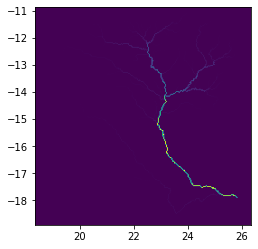

In [12]:
from rasterio.plot import show
# extract flow from WFlow

q = cbmi.bmimodels['WFL']._bmi.get_value('RiverRunoff')
cbmi.bmimodels['WFL'].grid.transform

show(q, transform=cbmi.bmimodels['WFL'].grid.transform, origin='lower')

In [238]:
def convert_Qs(Qx, Qy):
    """
    Qx and Qy are not exported correctly from LISFLOOD as they are cross-cell boundary fluxes. 
    In this routine they are transformed to match the grid of water depth. 
    The average over left-right cell edges is taken as estimate for the cell-averaged flow.
    
    """
    from scipy.signal import convolve2d as conv2d
    def reform(data):
        data = data[:, :-1]
        # add two lines with zeros
        data = np.append(data, np.zeros((2, data.shape[1])), axis=0)
        return data
    
    shape_x = Qx.shape[1] + 1
    Qx = Qx.flatten()
    Qy = Qy.flatten()
    x_conv = np.array(#[[0., 0., 0.],
                      [[.5, .5, 0.]],
                      #[0., 0., 0.]],
                     )
    y_conv = np.array([[.5,],
                      [.5],
                      [0.]],
                     )

    Qx = Qx[:shape_x*(len(Qx.flatten())//shape_x)].reshape((-1, shape_x))
    Qy = Qy[:shape_x*(len(Qy.flatten())//shape_x)].reshape((-1, shape_x))
    Qx = conv2d(Qx, x_conv, mode='same')
    Qy = conv2d(Qy, y_conv, mode='same')
    # add lines at bottom (south) and cut line at east
    Qx = reform(Qx)
    Qy = reform(Qy)
    return Qx, Qy
    
# H = cbmi.bmimodels['LFP']._bmi.get_var('H')
# qx = cbmi.bmimodels['LFP']._bmi.get_var('Qx').flatten()
# qy = cbmi.bmimodels['LFP']._bmi.get_var('Qy').flatten()

# x_conv = np.array(#[[0., 0., 0.],
#                   [[.5, .5, 0.]],
#                   #[0., 0., 0.]],
#                  )
# y_conv = np.array([[.5,],
#                       [.5],
#                       [0.]]
#                  )
# qx = qx[:348*(len(H.flatten())//348)].reshape((-1, 348))
# qy = qy[:348*(len(H.flatten())//348)].reshape((-1, 348))
# qx = conv2d(qx, x_conv, mode='same')
# qy = conv2d(qy, y_conv, mode='same')

# plt.figure(figsize=(30, 6))
# plt.subplot(121)
# plt.imshow(H[45:60, 100:140], vmax=4)
# plt.quiver(qx[45:60, 100:140], -qy[45:60, 100:140], scale=1000, color='r')

# plt.colorbar()

Qx_mod = [convert_Qs(qx, qy)[0] for qx, qy in zip(Qx, Qy)]
Qy_mod = [-convert_Qs(qx, qy)[1] for qx, qy in zip(Qx, Qy)]



In [220]:
print(qy.shape)
print(qx.shape)
print(H.shape)
print(len(H.flatten()))
print(len(H.flatten()) // 348)
348*(len(H.flatten())//348)
# 582*348

np.append(qy, np.zeros((2, qy.shape[1])), axis=0).shape

(582, 348)
(582, 348)
(584, 347)
202648
582


(584, 348)

In [429]:
import hvplot.xarray

def list_to_dataarray(data, time, x, y, name, attrs):
    return xr.DataArray(data,
                        name=name,
                        dims=('time', 'y', 'x'),
                        coords={'time': time,
                                'y': y,
                                'x': x
                               },
                        attrs=attrs
                       )

LFP_outputs = ['SGCQin', 'Qx', 'Qy']
LFP_attrs = [{'units': 'm**3 s**-1',
              'short_name': 'river_flow',
              'long_name': 'River Flow'
             },
#              {'units': 'm',
#               'short_name': 'water_depth',
#               'long_name': 'Water Depth'
#              },
             {'units': 'm**3 s**-1',
              'short_name': 'eastward_sea_water_velocity',
              #'long_name': '10 metre U wind component'
             },
             {'units': 'm**3 s**-1',
              'short_name': 'northward_sea_water_velocity',
              #'long_name': '10 metre V wind component'
             }
            ]


# extract x and y axis from grid definition

xi, yi = np.meshgrid(np.arange(Q[0].shape[1]), np.arange(Q[0].shape[0]))
xs = rasterio.transform.xy(cbmi.bmimodels['LFP'].grid.transform, yi[0,:].flatten(), xi[0,:].flatten())[0]
ys = rasterio.transform.xy(cbmi.bmimodels['LFP'].grid.transform, yi[:,0].flatten(), xi[:,0].flatten())[1]
datas = [np.array(Q),
#          np.array(H),
         np.array(Qx_mod),
         np.array(Qy_mod),
        ]
ds = xr.merge([list_to_dataarray(data, t,xs, ys, name, attrs) for data, name, attrs in zip(datas, LFP_outputs, LFP_attrs)])



In [341]:
%matplotlib inline
ds['Qy'].hvplot.quadmesh('x', 'y', cmap='viridis', rasterize=True, dynamic=True, frame_width=200, datashade=True)
# ds.to_netcdf('oneyear.nc')

:DynamicMap   [time]
   :RGB   [x,y]   (R,G,B,A)

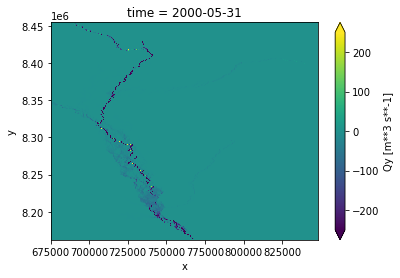

In [345]:
ds['Qy'][150].plot(vmin=-250, vmax=250)

masked_array(
  data=[[0.0, 0.0, 0.0, ..., --, --, --],
        [0.0, 0.0, 0.0, ..., --, --, --],
        [0.0, 0.0, 0.0, ..., --, --, --],
        ...,
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0]],
  mask=[[False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],
  fill_value=1e+20)

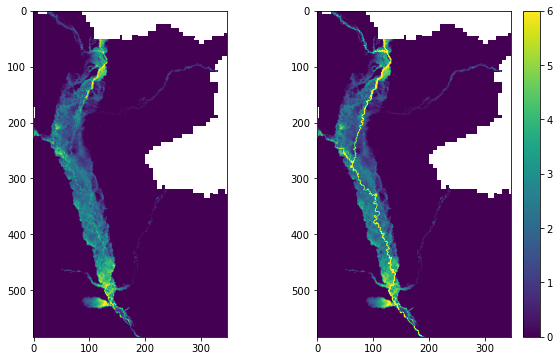

In [53]:
# ds['SGCQin'].hvplot.quadmesh('x', 'y', cmap='viridis', rasterize=True, dynamic=True, frame_width=200, data_shade=True)
z = cbmi.bmimodels['LFP']._bmi.get_var('SGCz')
z = np.ma.masked_array(z, z>90000)
# plt.imshow(z)
# plt.colorbar()
dem = cbmi.bmimodels['LFP']._bmi.get_var('DEM')
dem = np.ma.masked_array(dem, dem>90000)
H = cbmi.bmimodels['LFP']._bmi.get_var('H')
H = np.ma.masked_array(H, z.mask)
f = plt.figure(figsize=(10, 6))
ax1 = plt.subplot(121)
plt.imshow(np.maximum(H+z-dem,0), vmax=6.)
ax2 = plt.subplot(122)
plt.imshow(H, vmax=6.)

plt.colorbar()
H

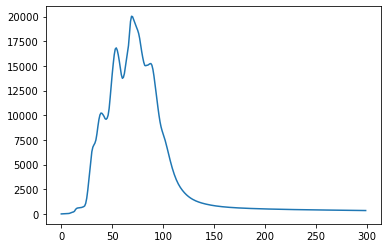

In [479]:
vals = []
for x, y in zip(x_to, y_to):
#     ds.sel(x=x, y=y)['SGCQin'][0:300].plot()
    vals.append(ds.sel(x=x, y=y)['SGCQin'].values)

vals = np.array(vals)

    

plt.plot(vals.sum(axis=0)[0:300])
# ts = ds.sel(x=x_to[3], y=y_to[3])
# ts['SGCQin'].plot() # .stack(point=['x', 'y'])

In [1]:
import sys
sys.path.append("/home/hcwinsemius/git/barotse/utils")
import xarray as xr
import fiona
import utils

fn = '/home/hcwinsemius/Barotse/Barotse_500m_MERIT/oneyear.nc'
ds = xr.open_dataset(fn)
cross_file = r'/home/hcwinsemius/git/barotse/gis/cross_sections.gpkg'
feats = fiona.open(cross_file)
Q = utils.discharge(ds['Qx'], ds['Qy'], feats, key='name')
Q

MissingDimensionsError: 'y' has more than 1-dimension and the same name as one of its dimensions ('time', 'y', 'x'). xarray disallows such variables because they conflict with the coordinates used to label dimensions.

In [483]:
def perpendicular(line, reverse=False):
    """
    determines the direction of a perpendicular line
    input: 
        line (fiona LineString) - line over which perpendicular direction needs to be determined
        reverse=False - if set to False (True), a 90 deg. counterclockwise (clockwise) direction is determined
    return:
        north, east: sign of the north east directions, can be -1 (south, west), 1 (north, east) or 0 (no direction)
        The assumption is thus made that flow field or velocity field are stored with positive numbers 
        being east and north direction oriented, and negative number west and south.
    """
    
    c1, c2 = line
    xdiff = c2[0] - c1[0]
    ydiff = c2[1] - c1[1]
    if reverse:
        north = np.sign(xdiff)
        east = -np.sign(ydiff)
    else:
        north = -np.sign(xdiff)
        east = np.sign(ydiff)
    return north, east

def discharge(da_x, da_y, feats, key='name', reverse=False):
    qs = [discharge_f(da_x, da_y, feat, key, reverse=reverse) for feat in feats]
#     import pdb;pdb.set_trace()
    qs = [i for i in qs if i is not None] 
    return xr.merge(qs)
        
def discharge_f(da_x, da_y, feature, key='name', reverse=False):
    """
    Computes the flow over a cross-section line from two x-direction and y-direction flow fields
    """
    if feature is not None:
        if feature['geometry']['type'] != 'LineString':
            raise ValueError('Feature other than LineString found')
        if len(feature['geometry']['coordinates']) != 2:
            raise IndexError('Non-straight lines found in cross-sections. Each cross-section line may only contain two coordinates')
        # determine the orientation of flow first, as perpendicular to the line direction
        north, east = perpendicular(feature['geometry']['coordinates'], reverse=reverse)
        if north == -1:
            north_south_conv = np.array([[0., -1., 0.], [0., 1, 0.], [0., 0., 0]])
        else:
            north_south_conv = np.array([[0., 0., 0.], [0., 1, 0.], [0., -1., 0]])
        if east == -1:
            west_east_conv = np.array([[0., 0., 0.], [0., 1, -1.], [0., 0., 0]])
        else:
            west_east_conv = np.array([[0., 0., 0.], [-1., 1, 0.], [0., 0., 0]])
        # rasterize the line
        image = features.rasterize([(feature['geometry'], 1)],
                               out_shape=cbmi.bmimodels['LFP'].grid.shape,
                               transform=cbmi.bmimodels['LFP'].grid.transform,
                               all_touched=True
                              )
        # find cells that should be considered when determining flow in south-north and west-east direction
        # give these cells a number to determine if flow is negative or positive
        north_south_cells = np.maximum(conv2d(image, north_south_conv, mode='same'), 0)*north
        west_east_cells = np.maximum(conv2d(image, west_east_conv, mode='same'), 0)*east
        cs = xr.DataArray(image, name='cross_section',
                          dims=('y', 'x'),
                          coords={'y': ds['y'],
                                  'x': ds['x'],
                                 },
                          )
        ns = xr.DataArray(north_south_cells, name='north_south',
                          dims=('y', 'x'),
                          coords={'y': ds['y'],
                                  'x': ds['x'],
                                 },
                          )
        we = xr.DataArray(west_east_cells, name='west_east',
                          dims=('y', 'x'),
                          coords={'y': ds['y'],
                                  'x': ds['x'],
                                 },
                          )
        flow_directions = xr.merge([cs, ns, we])
        flow_y = (ds['Qy'] * flow_directions['north_south']).sum(dim=('x', 'y'))
              
        flow_x = (ds['Qx'] * flow_directions['west_east']).sum(dim=('x', 'y'))
        flow = flow_x + flow_y
        flow.attrs['units'] = da_x.units
        flow.attrs['short_name'] = 'river_discharge'
        flow.name = feature['properties']['name']
        return flow
    else:
        return None

import fiona
fn = r'/home/hcwinsemius/git/barotse/gis/cross_sections.gpkg'
# open geopackage
feats = fiona.open(fn)
# feats[2]['properties']['name']
Q = discharge(ds['Qx'], ds['Qy'], feats)

# i = 2
# f = feats[i]
# q = discharge(ds['Qx'], ds['Qy'], f, reverse=False)
# q.plot()


> <ipython-input-483-66e34c48956d>(83)discharge_f()
-> flow.name = feature['properties']['name']
(Pdb) flow
<xarray.DataArray (time: 365)>
array([    0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
          54.18269895,   143.82489651,   255.38164179,   362.53028407,
        1020.53831298,  4237.82098637,  5590.30046471,  6396.07684188,
        7128.24258566,  7663.33196026,  8138.86901862,  8488.27540131,
        8

(Pdb) flow.attrs['units'] = da_x.units
(Pdb) flow
<xarray.DataArray (time: 365)>
array([    0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
          54.18269895,   143.82489651,   255.38164179,   362.53028407,
        1020.53831298,  4237.82098637,  5590.30046471,  6396.07684188,
        7128.24258566,  7663.33196026,  8138.86901862,  8488.27540131,
        8730.74994822,  8878.91892632,  8961.78924115,  9004.303434

BdbQuit: 

Affine(500.0, 0.0, 675000.0,
       0.0, -500.0, 8454500.0)

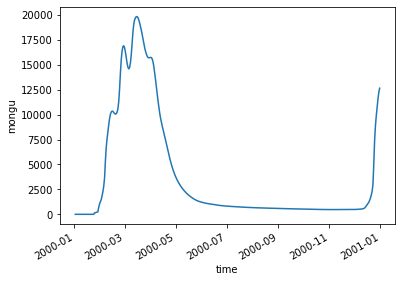

In [517]:
Q['mongu'].plot()
Q['senanga']
x, y = ds['x'].values, ds['y'].values
res_x, res_y = np.abs((x[-1]-x[0])/(len(x)-1)), np.abs((y[-1]-y[0])/(len(y)-1))
xmin, xmax = x.min()-res_x*.5, x.max()+res_x*.5
ymin, ymax = y.min()-res_y*.5, y.max()+res_y*.5
height, width = ds['Qx'][0].shape
res_y, ymin, ymax
rasterio.transform.from_bounds(xmin, ymin, xmax, ymax, width, height)

In [469]:
# ds_w = xr.open_dataset(r'/home/hcwinsemius/Barotse/zambezi_4km/run_default/outmaps.nc')
ds_w.close()

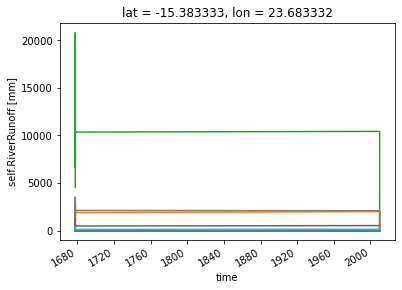

In [467]:
for x, y in zip(x_from, y_from):
    ds_w.sel(lon=x, lat=y)['run'][0:100].plot()
    #ts_w['run'][0:300].plot()

In [438]:
cbmi.finalize()# ds_w['run'][0:300, 110, 110] #, 300, 300].plot()

2020-04-30 13:15:48,390 - GLOFRIM - INFO - finalize models bmi. Close loggers.
2020-04-30 13:15:48,391 - GLOFRIM.WFL - INFO - finalize bmi. Close logger.
2020-04-30 13:15:48,392 - wflow_sbm.ini - wflow_sbm - INFO - Saving initial conditions...
2020-04-30 13:15:48,396 - wflow_sbm.ini - wf_DynamicFramework - INFO - Saving summary maps to disk...
2020-04-30 13:15:48,416 - GLOFRIM.LFP - INFO - finalize bmi. Close logger.


In [24]:
# ds_w['run'][200].plot(vmax=2)

TODO: Check how much volume is extracted from Wflow per time step (day), and compare that against the volume inserted in LISFLOOD per day.

TODO: Collect all results in an Xarray DataArray and plot and store them
